In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time
import random
import math
import joblib

In [2]:
X_train, y_train = np.load("X_train.npy"), np.load("Y_train.npy")
X_test, y_test = np.load("X_test.npy"), np.load("Y_test.npy")

In [3]:
X_train = pd.DataFrame(X_train.reshape(X_train.shape[0],-1))
X_test = pd.DataFrame(X_test.reshape(X_test.shape[0],-1))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/6, stratify=y_train,random_state=42)

X_train.reset_index(inplace=True,drop=True)
X_val.reset_index(inplace=True,drop=True)

In [5]:
y_cols = [str(i) for i in range(max(y_train)+1)]

print("Length of train and validation set respectively: ")
len(X_train),len(X_val)

Length of train and validation set respectively: 


(50000, 10000)

In [35]:
def display_img(data_df:pd.DataFrame):
    display_df = data_df.sample(n=20)
    fig, axs = plt.subplots(4,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.005)

    axs = axs.ravel()
    X_cols = display_df.columns[1:]
    for i in range(20):
        axs[i].imshow(np.expand_dims(display_df.iloc[i][X_cols].values,1).reshape((28,28)),cmap="Greys")
        axs[i].set_title(f"Label: {y_cols[display_df.iloc[i]['label']]}")

In [6]:
train_data = pd.concat([X_train,pd.DataFrame(y_train,columns=['label'])],axis=1)
test_data = pd.concat([X_test,pd.DataFrame(y_test,columns=['label'])],axis=1)

## PLOTTING DATA BEFORE PCA

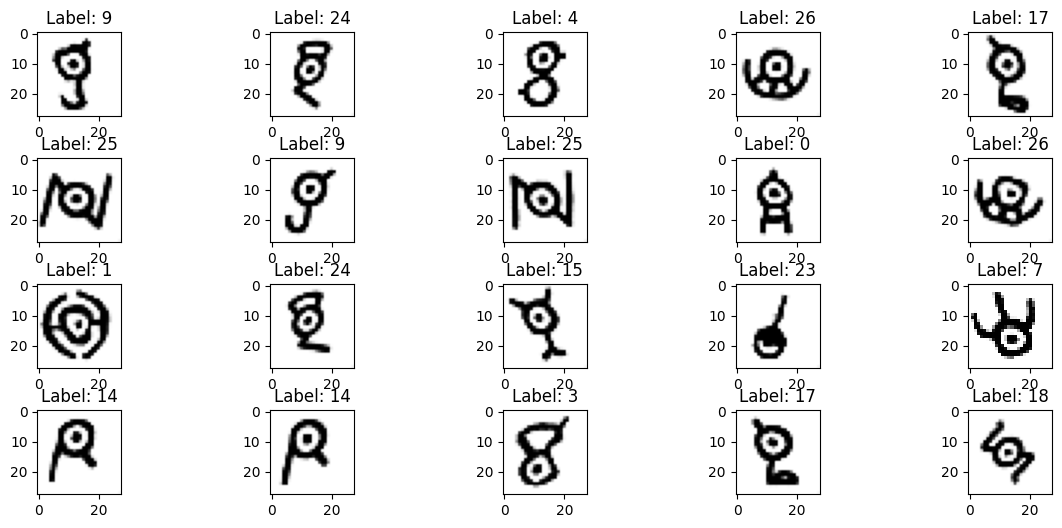

In [37]:
display_img(train_data)

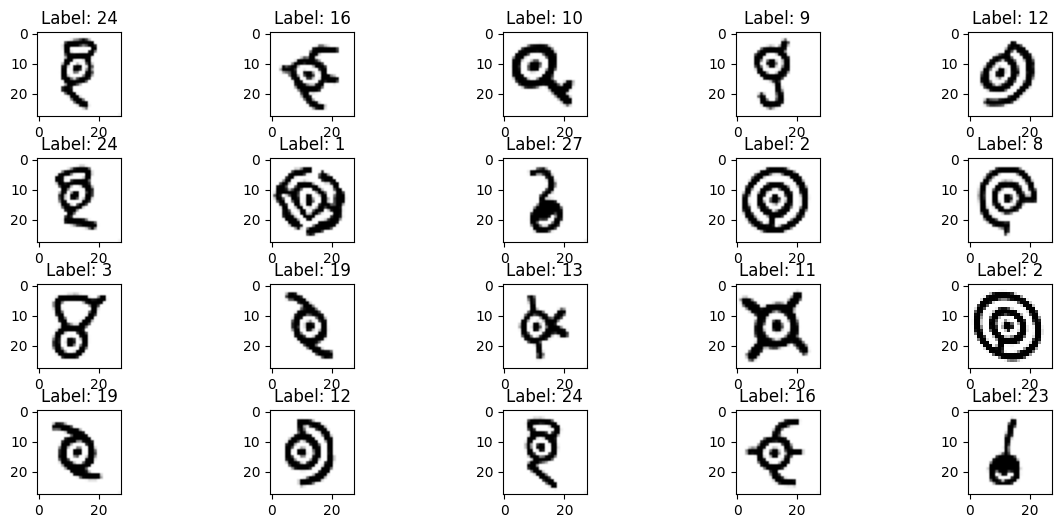

In [38]:
display_img(test_data)

## RANDOM FOREST CLASSIFIER FOR THE DATASET WITHOUT PCA

In [7]:
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

In [68]:
start = time.time()
rf_model = RandomForestClassifier(n_jobs=-1,random_state=42,n_estimators=50)

rf_model.fit(X_train,y_train)
print(f"It took {round(time.time()-start,3)} seconds")

It took 1.703 seconds


In [69]:
print("Validation accuracy of RF Model: ",rf_model.score(X_val,y_val))
print("Test accuracy of RF Model: ",rf_model.score(X_test,y_test))

Validation accuracy of RF Model:  1.0
Test accuracy of RF Model:  0.9999


## APPLYING PCA

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_scaled = pca.fit_transform(X_train)

In [9]:
plt.style.use('dark_background')
explained_var = pca.explained_variance_ratio_
cum_var = explained_var.cumsum()

## 95% EXPLAINED VARIANCE

## Q1: Getting the required number of PCA components that explain 95% of the variance. So we need `186` components from `784` components to explain `95%` of the variance


In [10]:
#Getting the required number of PCA components that explain 95% of the variance
req_comp = np.where(cum_var>=0.95)[0][0] + 1
print(f"The number of required PCA components: ",req_comp)

The number of required PCA components:  186


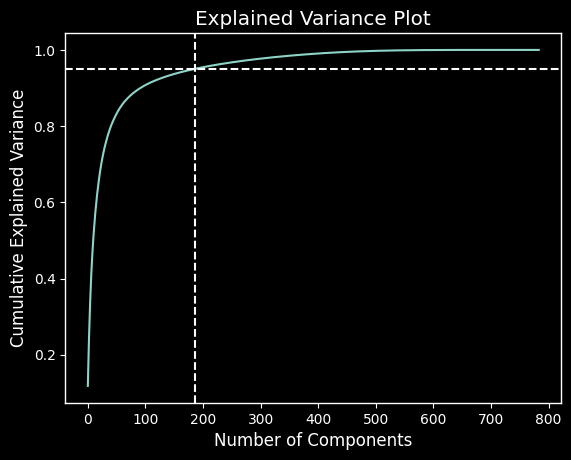

In [50]:
plt.style.use("dark_background")
plt.plot(cum_var)
plt.axhline(0.95,linestyle='--')
plt.axvline(req_comp,linestyle='--')
plt.title("Explained Variance Plot")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(visible=None)

In [11]:
pca_trans = PCA(n_components=req_comp)

X_train_scaled = pca_trans.fit_transform(X_train)
X_val_scaled = pca_trans.transform(X_val)
X_test_scaled = pca_trans.transform(X_test)

In [12]:
X_recovered_train = pca_trans.inverse_transform(X_train_scaled)
X_recovered_val = pca_trans.inverse_transform(X_val_scaled)

## Q3: PLOTTING IMAGES WITH AND WITHOUT PCA FOR COMPARISON

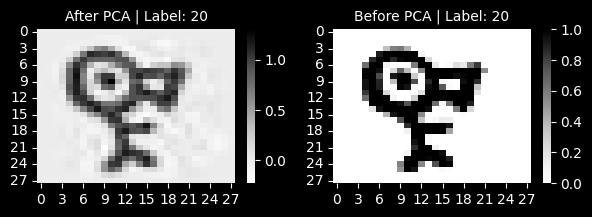

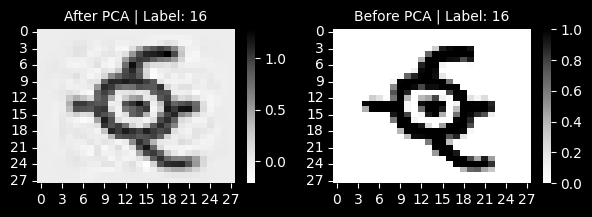

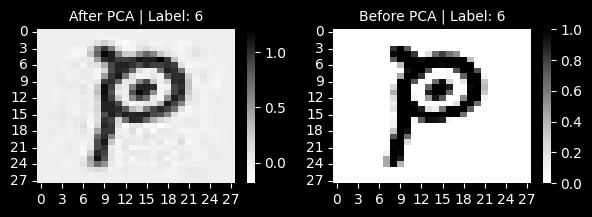

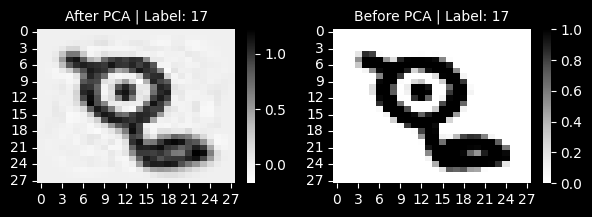

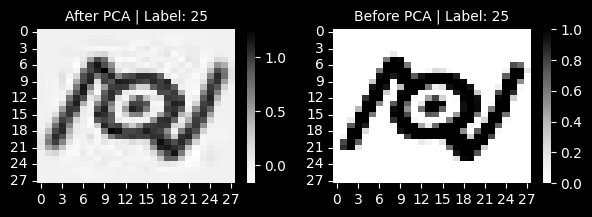

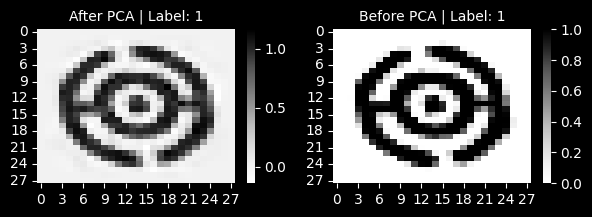

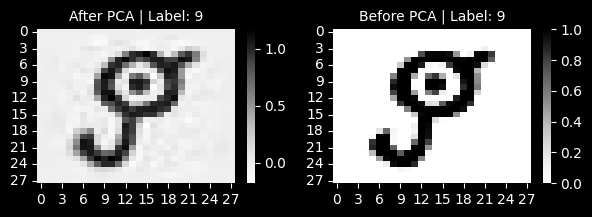

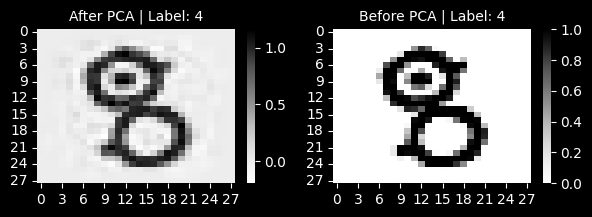

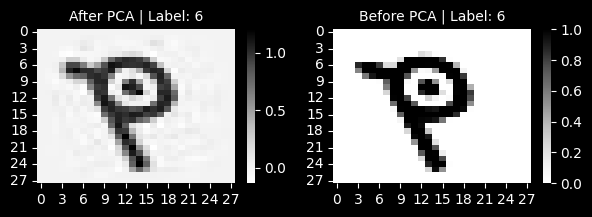

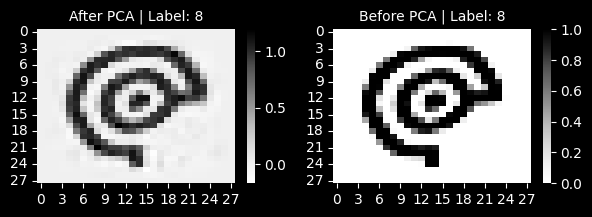

In [53]:
random_idxs = np.random.randint(low=0,high=len(X_train),size=10)

for idx in random_idxs:
    fig, axs = plt.subplots(1, 2, figsize=(7, 2))
    sns.heatmap(X_train.loc[idx].values.reshape(28,28),ax=axs[1],cmap='Greys')
    sns.heatmap(X_recovered_train[idx].reshape(28,28),ax=axs[0],cmap='Greys')
    axs[0].set_title(f"After PCA | Label: {y_cols[y_train[idx]]}",fontsize=10)
    axs[1].set_title(f"Before PCA | Label: {y_cols[y_train[idx]]}",fontsize=10)

In [70]:
start = time.time()
pca_rf_model = RandomForestClassifier(n_jobs=-1,random_state=42,n_estimators=50)
pca_rf_model.fit(X_train_scaled,y_train)
print(f"It took {round(time.time()-start,2)} seconds")

It took 3.95 seconds


In [71]:
print("Validation accuracy of RF Model: ",pca_rf_model.score(X_val_scaled,y_val))
print("Test accuracy of RF Model: ",pca_rf_model.score(X_test_scaled,y_test))

Validation accuracy of RF Model:  0.9999
Test accuracy of RF Model:  1.0


| Model           | Val Accuracy Score  | Test Accuracy Score | Time taken(s) |
| ----------------|---------------------|----------------------|------- |
| RF WITHOUT PCA     |    1.00              | 1.0                |1.703
| RF WITH PCA  | 0.99                 |1.0                 |3.95

# Q2: OBSERVATIONS
* RF forest algorithm without PCA took less time as compared to RF with PCA. This is counterintuitive as dimensionality reduction `784` to `186` increases the fitting time. But Random forest exploits the variation among the data to build decision trees and data with higher covariance facilitates building decision trees, as we can split easily. But PCA reduces the variation among the data and very low covariance. This makes the decision tree split harder, thus the decision trees needs to be wider and have higher depth, which increases the fitting time
* Also, the accuracy of RF with PCA is similar to that without PCA algorithm, because we have components that explain only `95%` of variance. But the accuracy only takes a marginal hit and we can say that they are almost similar.

## EXPLAINED VARIANCE FROM FIRST TWO COMPONENTS

## Q5: PLOTTING `1000` IMAGES AFTER DIMENSIONALITY REDUCTION USING PCA, T-SNE, LLE AND MDS

## PCA PLOTS

In [86]:
pca_2d = PCA(n_components=2)

X_train_2d = pca_2d.fit_transform(X_train)

## Q4 EXPLAINED VARIANCE FROM ONLY TWO COMPONENTS

In [87]:
comps = 2
print(f"Variance explained by first two {comps} is {round(sum(pca_2d.explained_variance_ratio_),3)} ")

Variance explained by first two 2 is 0.18 


In [88]:
import random
num_images = 1000

comb_list = list(zip(X_train_2d,y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot = [td for (td,l) in selected_list]
y_2d_plot = [l for (td,l) in selected_list]

In [89]:
X_2d_plot = np.array(X_2d_plot)
y_2d_plot = np.array(y_2d_plot)

100%|██████████| 28/28 [00:00<00:00, 52.57it/s]


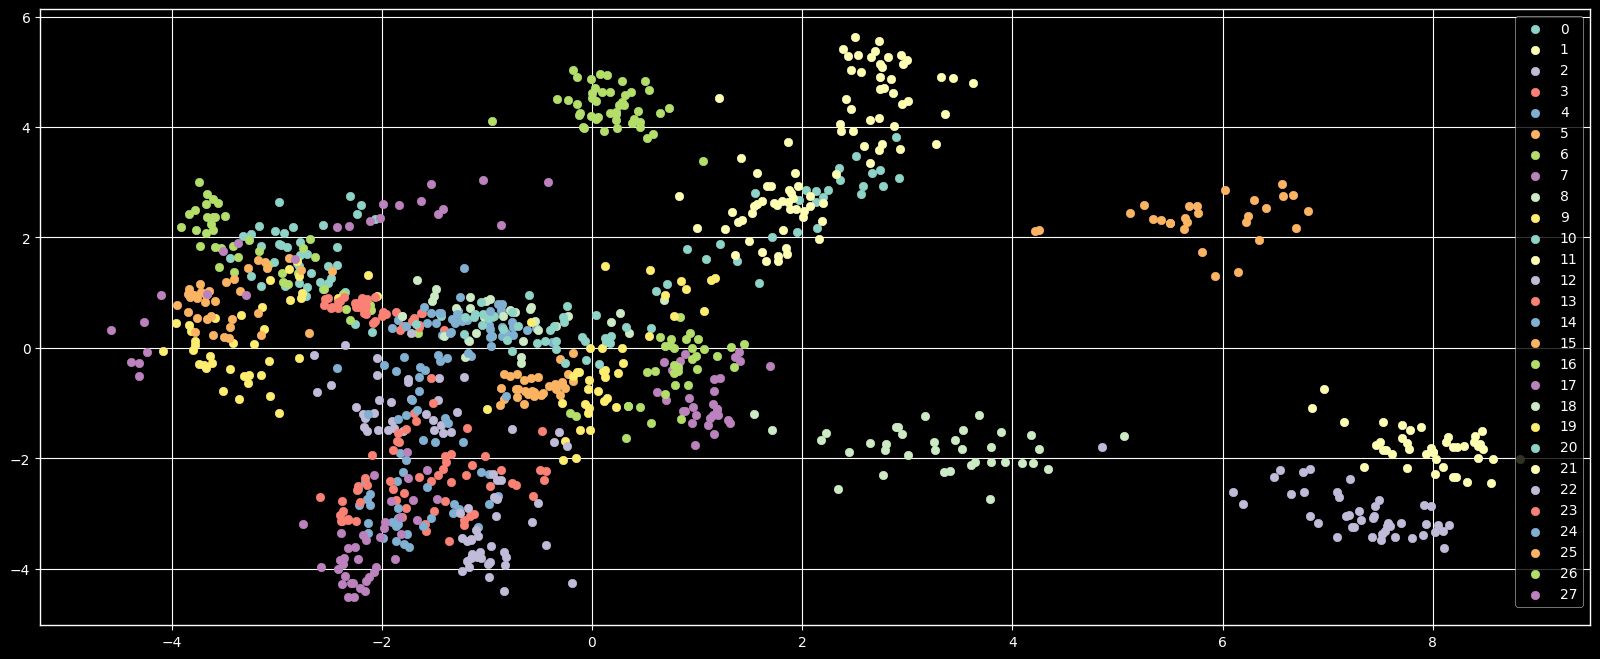

In [99]:
from tqdm import tqdm
fig,axs = plt.subplots(1,figsize=(20,8))
for i in tqdm(np.unique(y_2d_plot)):
    axs = plt.gca()
    idxs = np.where(y_2d_plot==i)
    X_2d = X_2d_plot[idxs]
    axs.scatter(X_2d[:,0],X_2d[:,1],label=y_cols[i])
axs.legend()
plt.title("PCA Plot")
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.show()

100%|██████████| 28/28 [00:00<00:00, 634.31it/s]


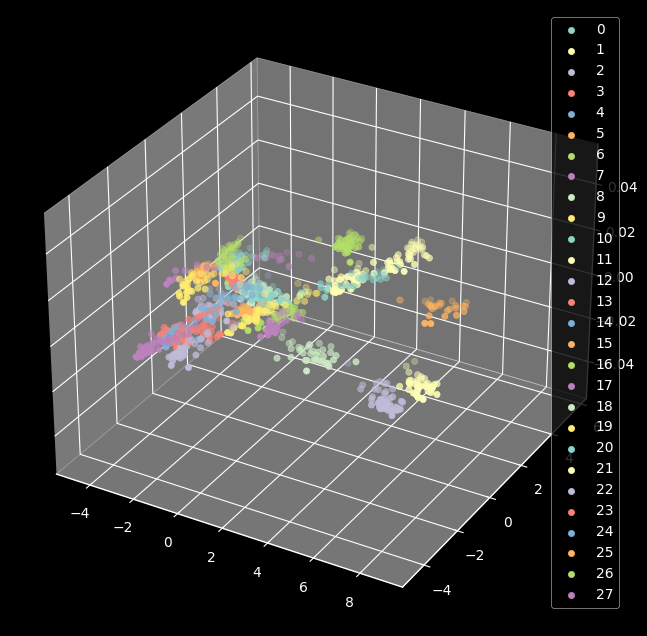

In [100]:
fig = plt.figure(figsize=(10,8))
axs = fig.add_subplot(projection='3d')
for i in tqdm(np.unique(y_2d_plot)):
    axs = plt.gca()
    idxs = np.where(y_2d_plot==i)
    X_2d = X_2d_plot[idxs]
    axs.scatter(X_2d[:,0],X_2d[:,1],label=y_cols[i])
axs.legend()
plt.show()

## T-SNE

In [72]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=50)

X_tsne = tsne.fit_transform(X_train)

/home/athekunal/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/athekunal/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [73]:
import numpy as np

with open('TSNE.npy', 'wb') as f:
    np.save(f, X_tsne,allow_pickle=True)

with open('TSNE.npy', 'rb') as f:
    X_tsne = np.load(f,allow_pickle=True)

In [74]:
num_images = 1000

comb_list = list(zip(X_tsne,y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot_tsne = [td for (td,l) in selected_list]
y_2d_plot_tsne = [l for (td,l) in selected_list]

In [75]:
X_2d_plot_tsne = np.array(X_2d_plot_tsne)
y_2d_plot_tsne = np.array(y_2d_plot_tsne)

100%|██████████| 28/28 [00:00<00:00, 826.82it/s]


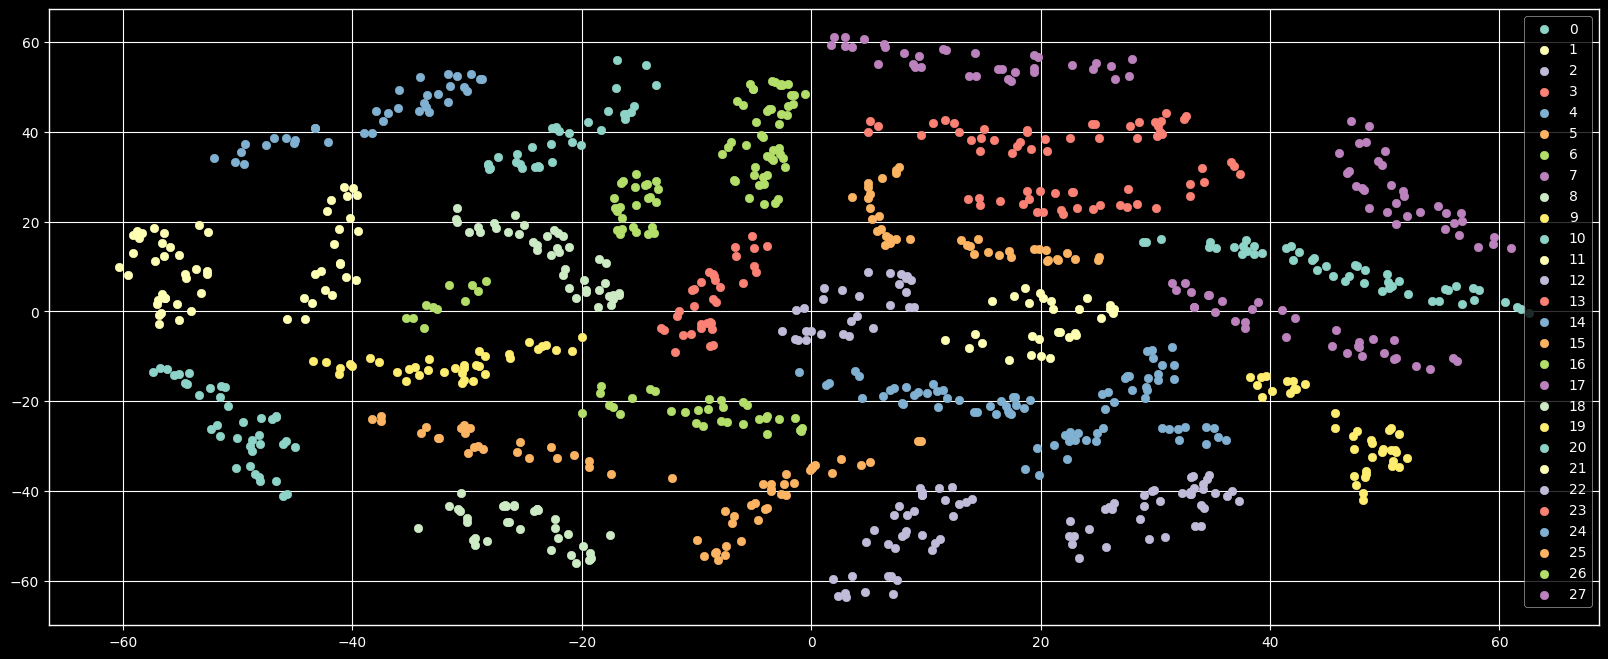

In [101]:
from tqdm import tqdm
fig,axs = plt.subplots(1,figsize=(20,8))
for i in tqdm(np.unique(y_2d_plot_tsne)):
    axs = plt.gca()
    idxs = np.where(y_2d_plot_tsne==i)
    X_2d = X_2d_plot_tsne[idxs]
    axs.scatter(X_2d[:,0],X_2d[:,1],label=y_cols[i])
axs.legend()
plt.title("T-SNE Plot")
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.show()

100%|██████████| 28/28 [00:00<00:00, 548.39it/s]


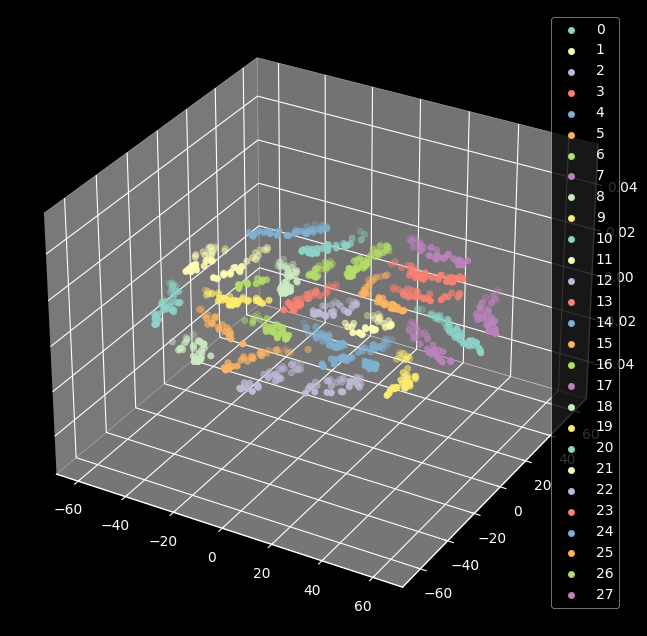

In [102]:
fig = plt.figure(figsize=(10,8))
axs = fig.add_subplot(projection='3d')
for i in tqdm(np.unique(y_2d_plot_tsne)):
    axs = plt.gca()
    idxs = np.where(y_2d_plot_tsne==i)
    X_2d = X_2d_plot_tsne[idxs]
    axs.scatter(X_2d[:,0],X_2d[:,1],label=y_cols[i])
axs.legend()
plt.show()

## LLE

In [107]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_neighbors=10,n_jobs=-1)

X_lle = lle.fit_transform(X_train)

In [108]:
import numpy as np

with open('LLE.npy', 'wb') as f:
    np.save(f, X_lle,allow_pickle=True)

with open('LLE.npy', 'rb') as f:
    X_lle = np.load(f,allow_pickle=True)

In [109]:
num_images = 1000

comb_list = list(zip(X_lle,y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot_lle = [td for (td,l) in selected_list]
y_2d_plot_lle = [l for (td,l) in selected_list]

X_2d_plot_lle = np.array(X_2d_plot_lle)
y_2d_plot_lle = np.array(y_2d_plot_lle)

## PLEASE REVIEW THE Q-5 ANSWERS TO SEE WHY LLE DIDN'T PERFORM WELL

100%|██████████| 28/28 [00:00<00:00, 855.81it/s]


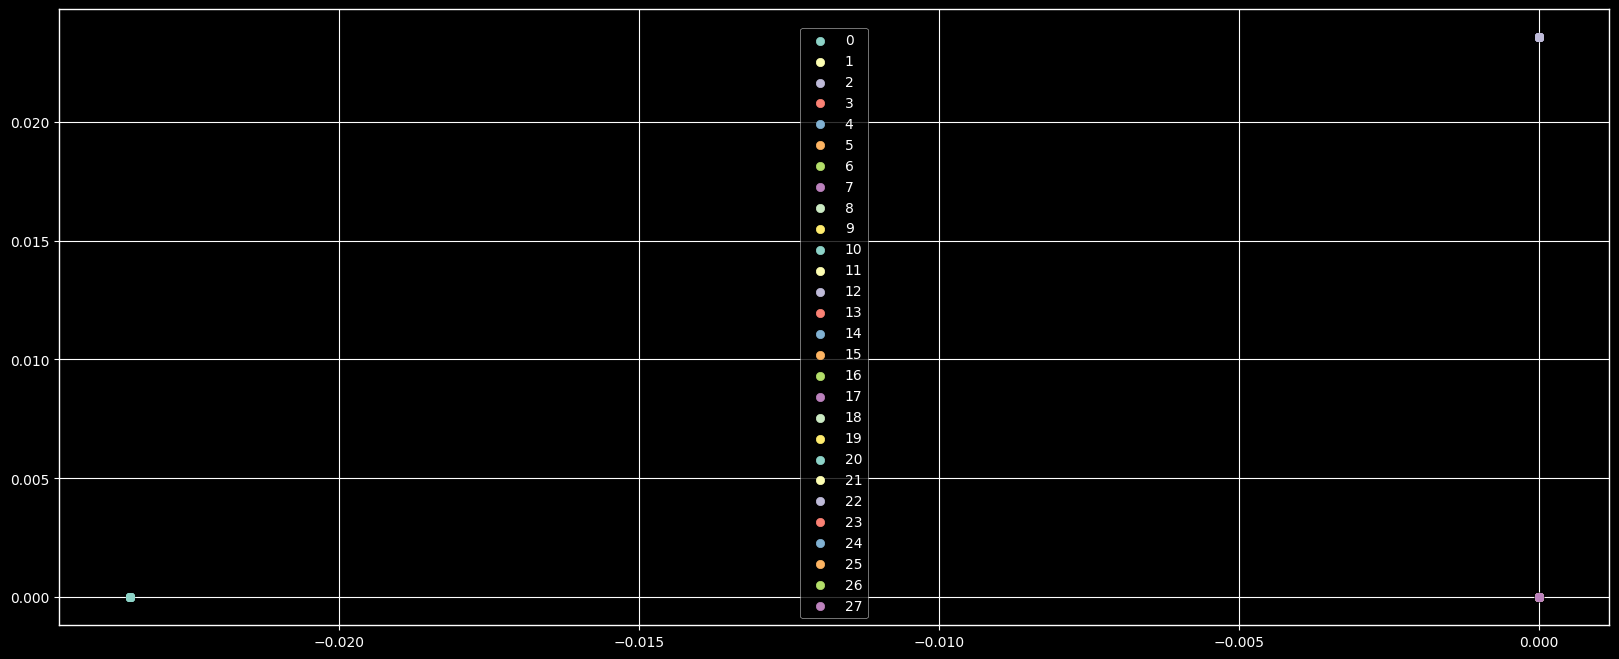

In [110]:
fig,axs = plt.subplots(1,figsize=(20,8))
for i in tqdm(np.unique(y_2d_plot_lle)):
    axs = plt.gca()
    idxs = np.where(y_2d_plot_lle==i)
    X_2d = X_2d_plot_lle[idxs]
    axs.scatter(X_2d[:,0],X_2d[:,1],label=y_cols[i])
axs.legend()
plt.title("LLE Plot")
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.show()

## MDS

In [13]:
from sklearn.manifold import MDS
import random
mds = MDS()
X_mds = mds.fit_transform(X_train.sample(frac=1/10,random_state=42))

In [68]:
import numpy as np

with open('MDS.npy', 'wb') as f:
    np.save(f, X_mds,allow_pickle=True)

with open('MDS.npy', 'rb') as f:
    X_mds = np.load(f,allow_pickle=True)

In [73]:
num_images = 1000

comb_list = list(zip(X_mds.tolist(),y_train))
selected_list = random.sample(comb_list,num_images)
X_2d_plot_mds = [td for (td,l) in selected_list]
y_2d_plot_mds = [l for (td,l) in selected_list]

X_2d_plot_mds = np.array(X_2d_plot_mds)
y_2d_plot_mds = np.array(y_2d_plot_mds)

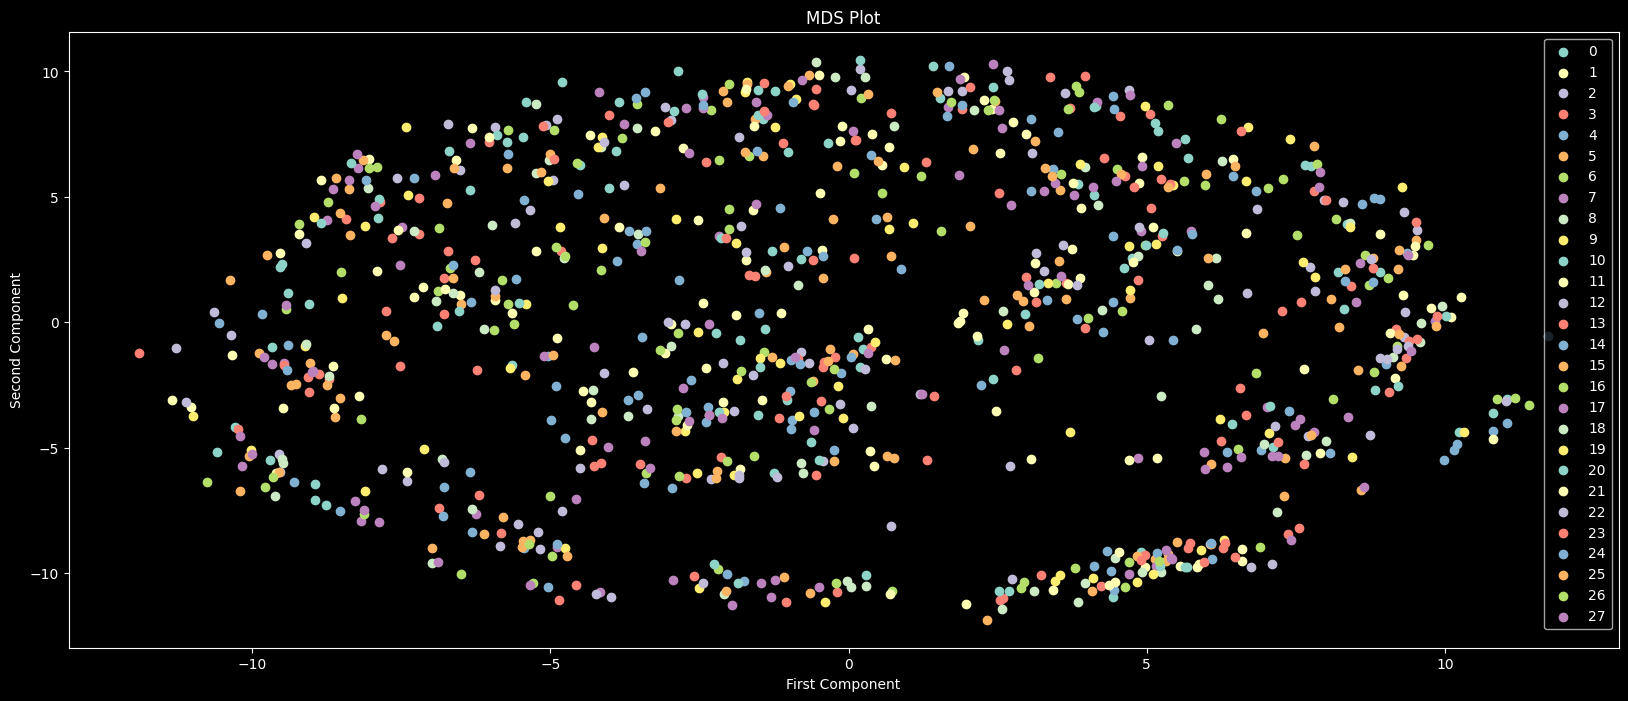

In [17]:
fig,axs = plt.subplots(1,figsize=(20,8))
for i in np.unique(y_2d_plot_mds):
    axs = plt.gca()
    idxs = np.where(y_2d_plot_mds==i)
    X_2d = X_2d_plot_mds[idxs]
    axs.scatter(X_2d[:,0],X_2d[:,1],label=y_cols[i])
axs.legend()
plt.title("MDS Plot")
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.show()


## Q-5
1. PCA captures the linear relationship in data and we use KernelPCA for non-linear relationship. But images have non-linear relationship, that's why PCA was not able to cluster those images properly, hence the scatter plot is not well separated
2. The clusters are effectively separated by T-SNE. The 'perplexity' parameter in T-SNE is a hyperparameter; if we increase it, the clusters get denser because it increases the forces that pull similar points together and push dissimilar points apart. Thus, we have chosen a value of 50 to represent the cluster.
3. LLE completely fails to generate the plot for clustering the dataset. Even increasing the `n_neighbors` parameter didn't help to assuage the clustering. This may be due to failure to capture local relationship in LLE and the embeddings are failed to be generated.
4. MDS similar to PCA only captures linear relationships, hence it is unable segment the images properly.

## KMeans

In [13]:
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']

In [14]:
X_train_scaled_df = pd.DataFrame(X_train_scaled)
train = pd.concat([X_train_scaled_df,y_train],axis=1)

sample_data = train.groupby('label').apply(lambda x:x.sample(frac=1/5)).reset_index(drop=True)

In [15]:
sample_data = sample_data.sample(frac=1)
X_kmeans_train = sample_data[sample_data.columns[:-1]]
y_kmeans_train = sample_data['label']

In [25]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm

In [27]:
num_clusters = [i for i in range(20,35)]

kmeans_dicts = {}
#Iterating over different k-values to find the adequate number of clusters
for clusters in tqdm(num_clusters):
    kmeans = KMeans(n_clusters=clusters,random_state=42)
    kmeans.fit(X_kmeans_train)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_kmeans_train, cluster_labels)
    kmeans_dicts.update({str(clusters):[kmeans.inertia_,silhouette_avg]})

100%|██████████| 15/15 [01:20<00:00,  5.39s/it]


In [28]:
import pickle 

with open('KMeans.pkl', 'wb') as f:
    pickle.dump(kmeans_dicts, f)
        
with open('KMeans.pkl', 'rb') as f:
    kmeans_dicts = pickle.load(f)

In [29]:
inertia_vals = [val[0] for val in kmeans_dicts.values()]
silhoutte_coeffs = [val[1] for val in kmeans_dicts.values()]

Text(0.5, 1.0, 'Inertia Values vs. Number of Centroids')

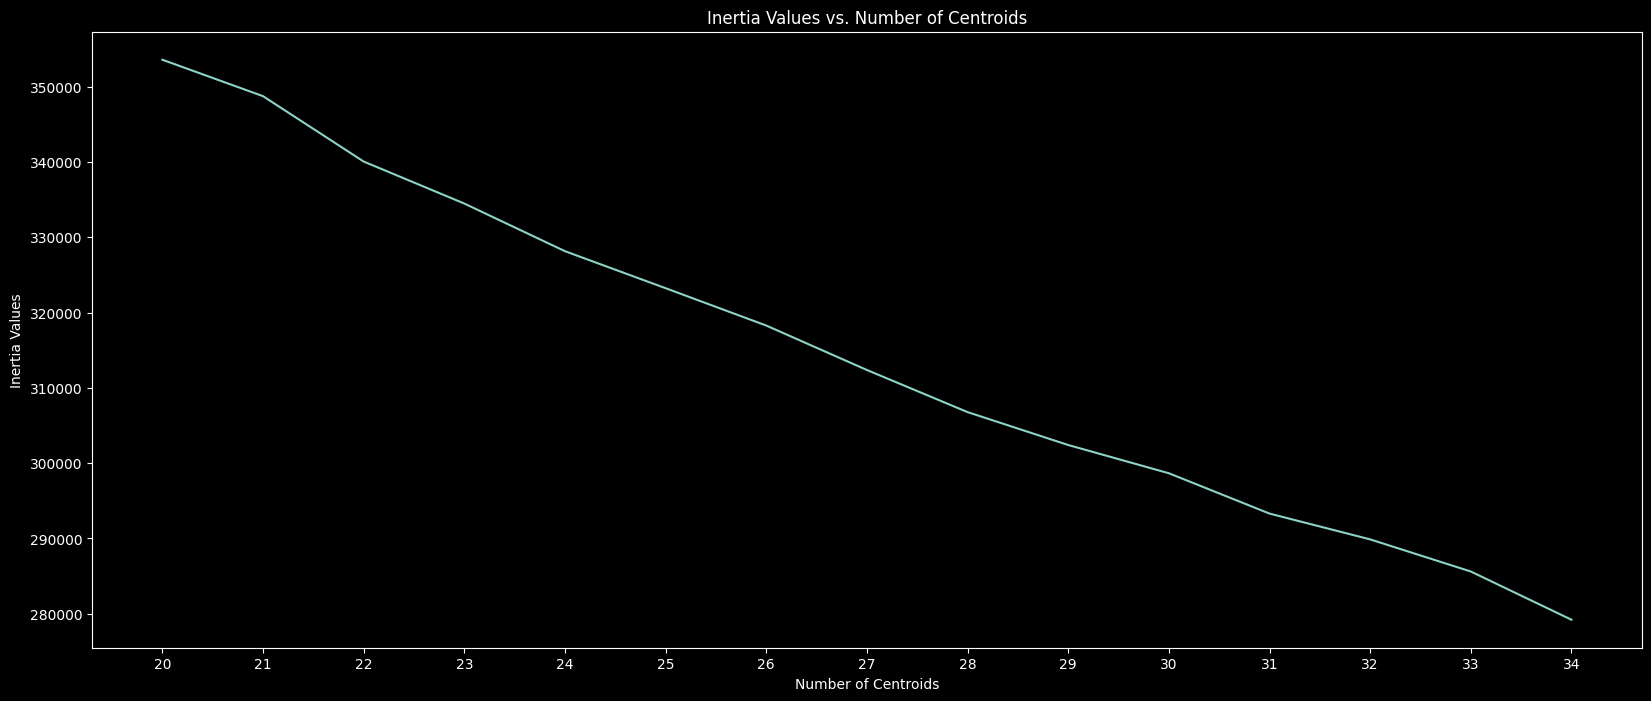

In [30]:
num_clusters = [str(i) for i in num_clusters]
plt.figure(figsize=(20,8))
plt.plot(num_clusters,inertia_vals)
plt.xlabel("Number of Centroids")
plt.ylabel("Inertia Values")
plt.title("Inertia Values vs. Number of Centroids")

Text(0.5, 1.0, 'Silhoutte Coefficients vs. Number of Centroids')

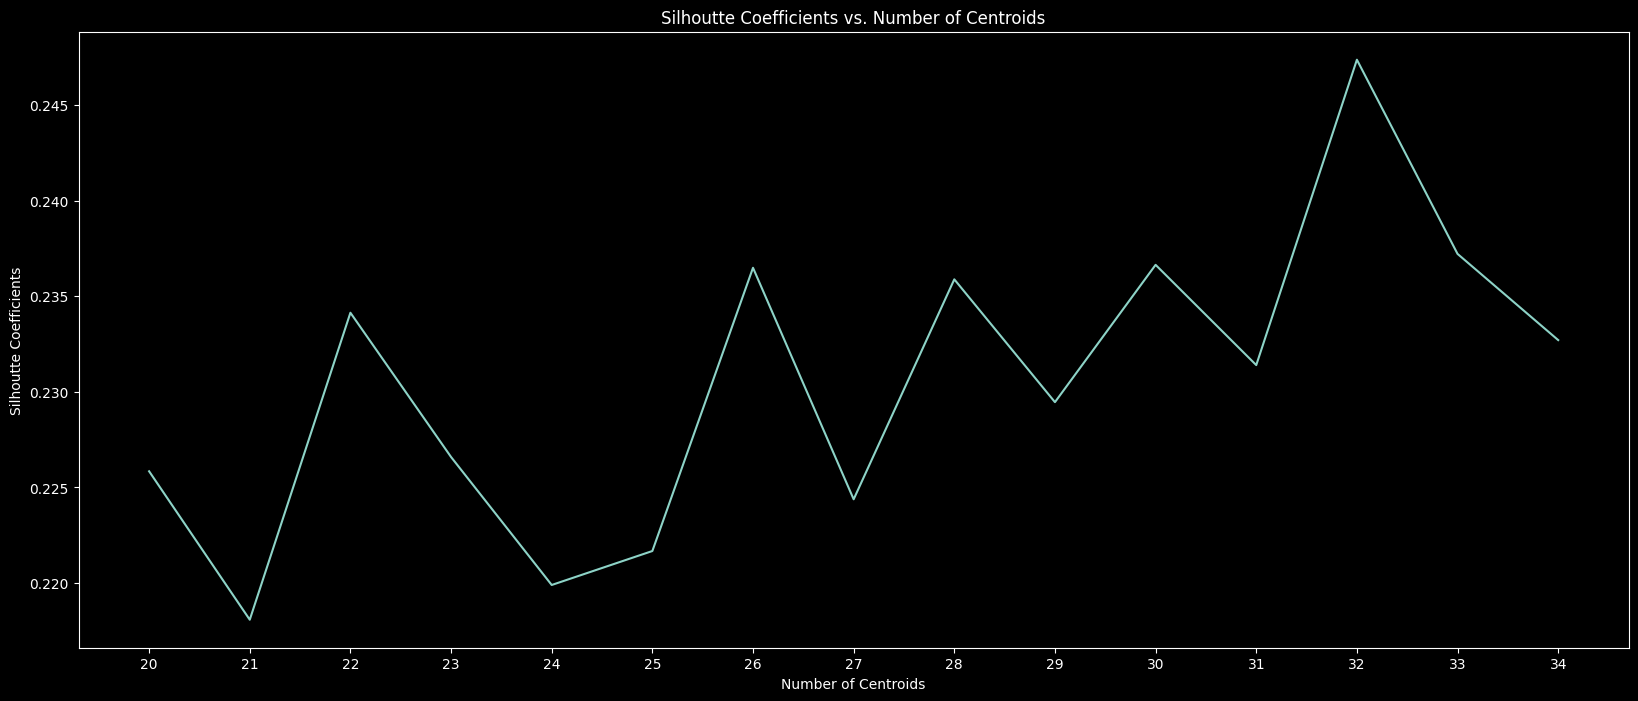

In [31]:
plt.figure(figsize=(20,8))
plt.plot(num_clusters,silhoutte_coeffs)
plt.xlabel("Number of Centroids")
plt.ylabel("Silhoutte Coefficients")
plt.title("Silhoutte Coefficients vs. Number of Centroids")

In [34]:
print(f"The best number of clusters is {int(num_clusters[0])+np.argmax(silhoutte_coeffs)}")

The best number of clusters is 32


In [35]:
sample_data = train.groupby('label').apply(lambda x:x.sample(frac=1/50)).reset_index(drop=True)
sample_data = sample_data.sample(frac=1)
X_sub_kmeans_train = sample_data[sample_data.columns[:-1]]
y_sub_kmeans_train = sample_data['label']

In [36]:
#Reference: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import matplotlib.cm as cm

def plot_silhoutte(n_clusters:int,X):
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    clusterer.fit(X_kmeans_train)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    for idx,y in enumerate(y_cols):
        ax2 = plt.gca()
        sub_df = sample_data[sample_data.label==idx]
        sub_vals = sub_df.values
        ax2.scatter(sub_vals[:,0],sub_vals[:,1],label=y, marker=".", s=30, lw=0, alpha=0.7, edgecolor="k")
   
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.legend()
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    plt.show()

For n_clusters = 28 The average silhouette_score is : 0.23876782355773832


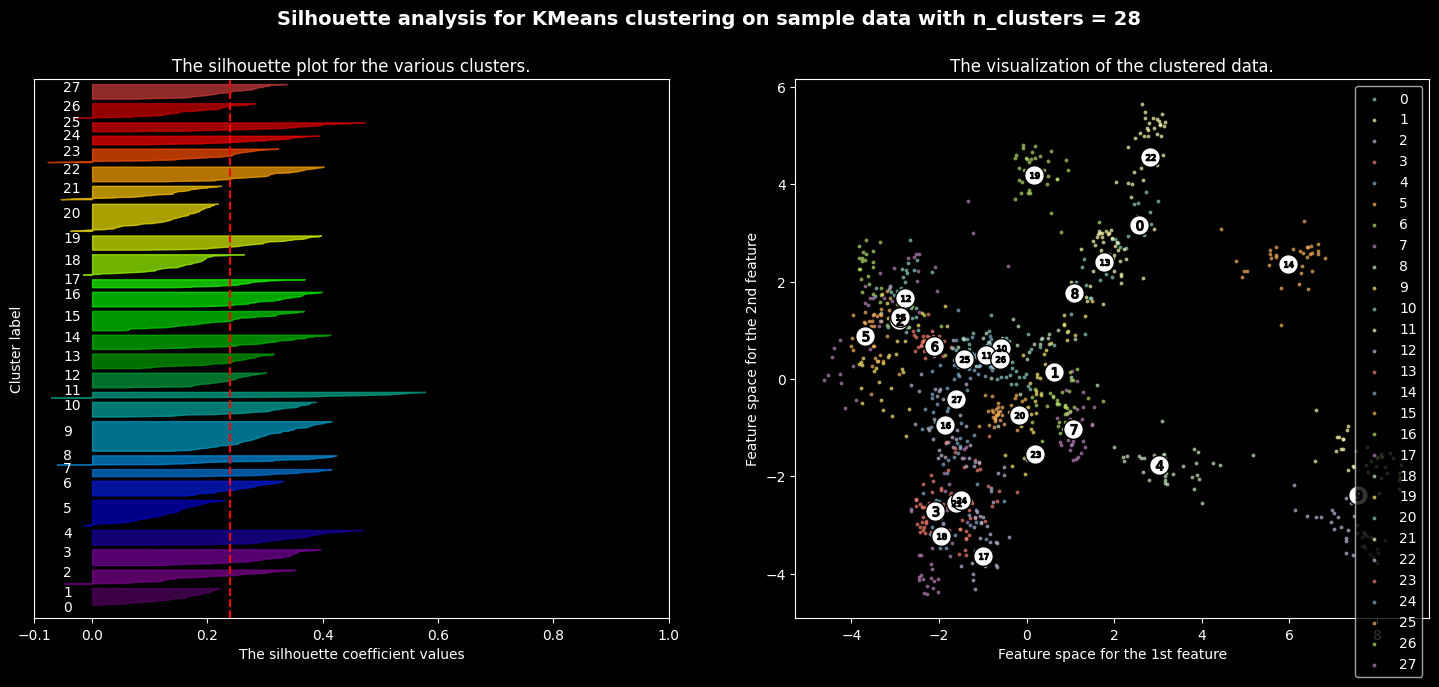

In [37]:
plot_silhoutte(28,X_sub_kmeans_train.values)

For n_clusters = 32 The average silhouette_score is : 0.25458079376873827


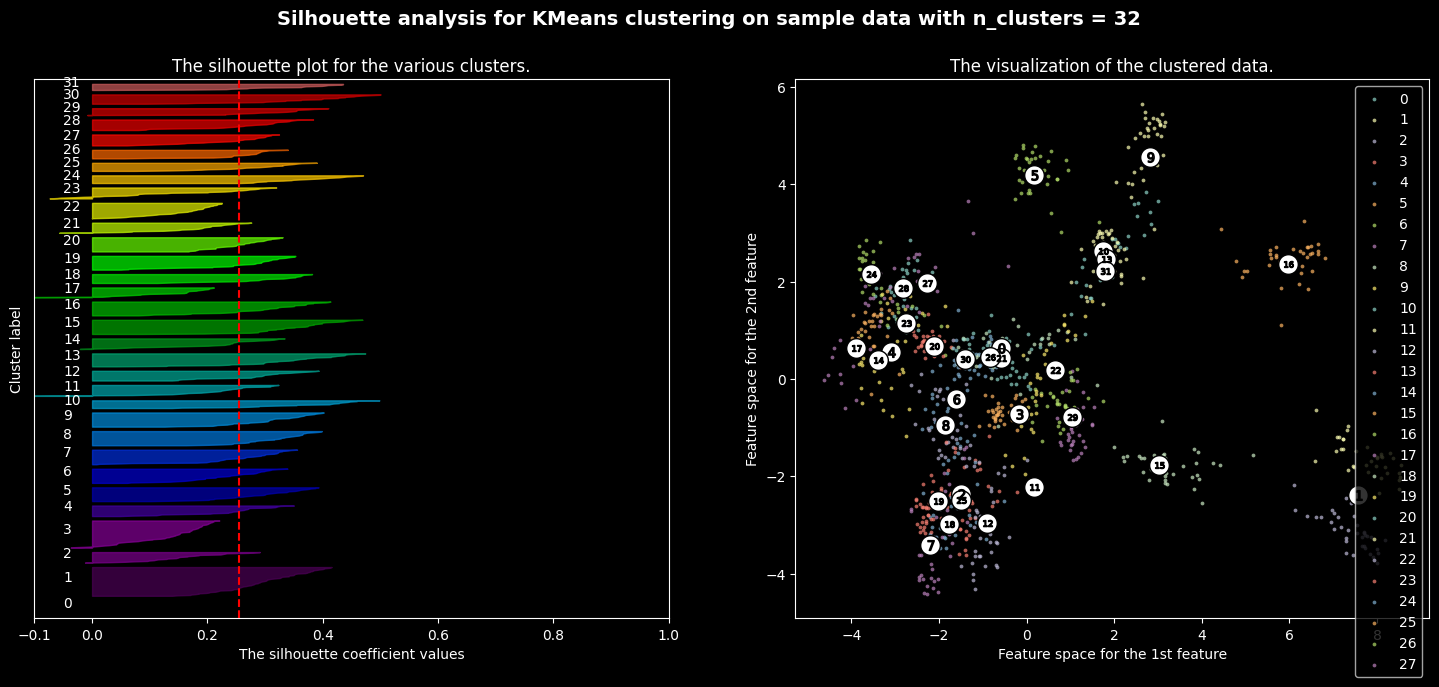

In [38]:
plot_silhoutte(32,X_sub_kmeans_train.values)

For n_clusters = 33 The average silhouette_score is : 0.23794463251657744


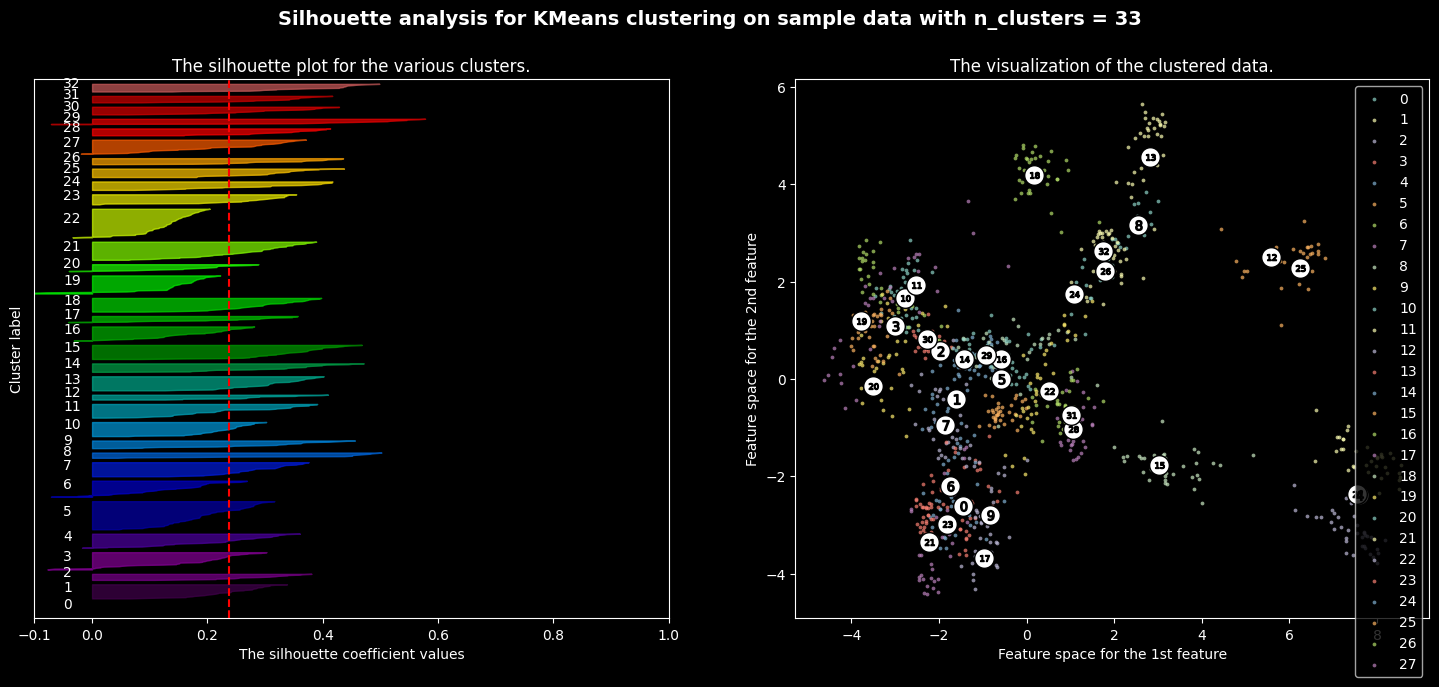

In [39]:
plot_silhoutte(33,X_sub_kmeans_train.values)

For n_clusters = 31 The average silhouette_score is : 0.2339632892157823


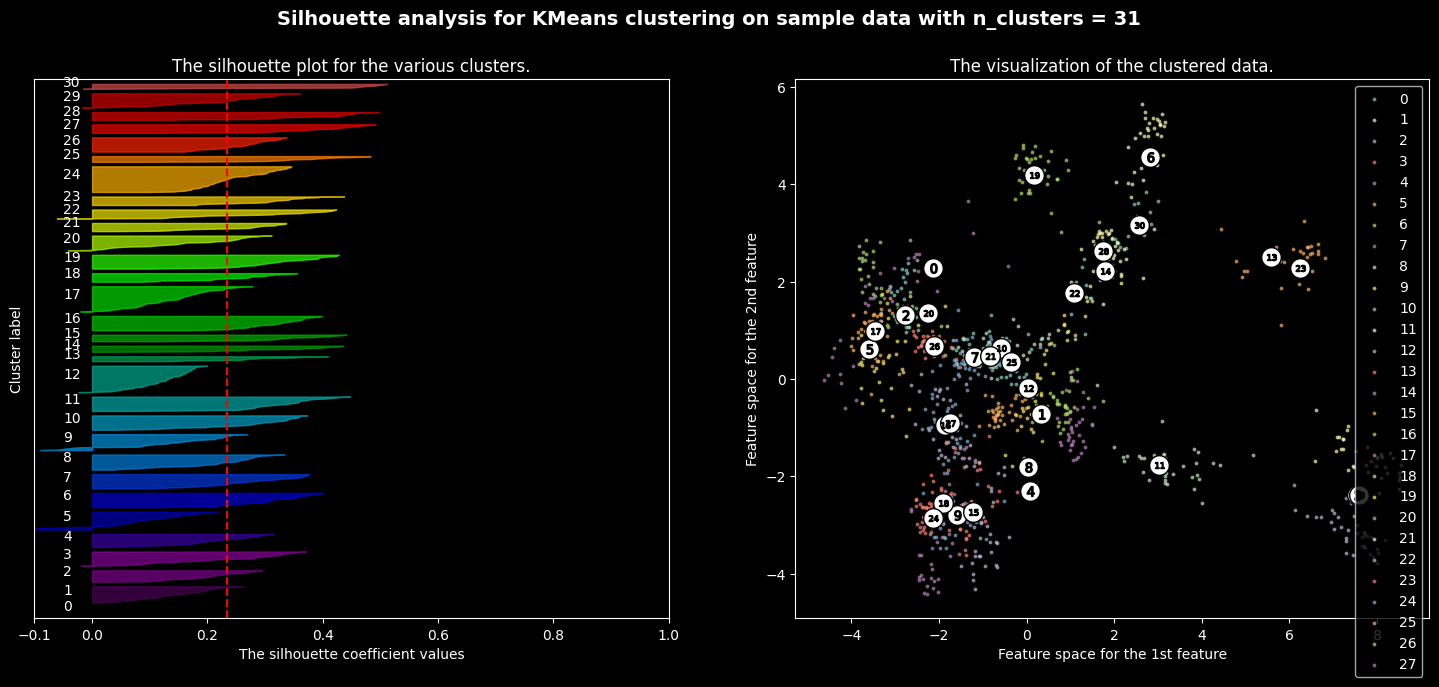

In [40]:
plot_silhoutte(31,X_sub_kmeans_train.values)

For n_clusters = 35 The average silhouette_score is : 0.24889094555161345


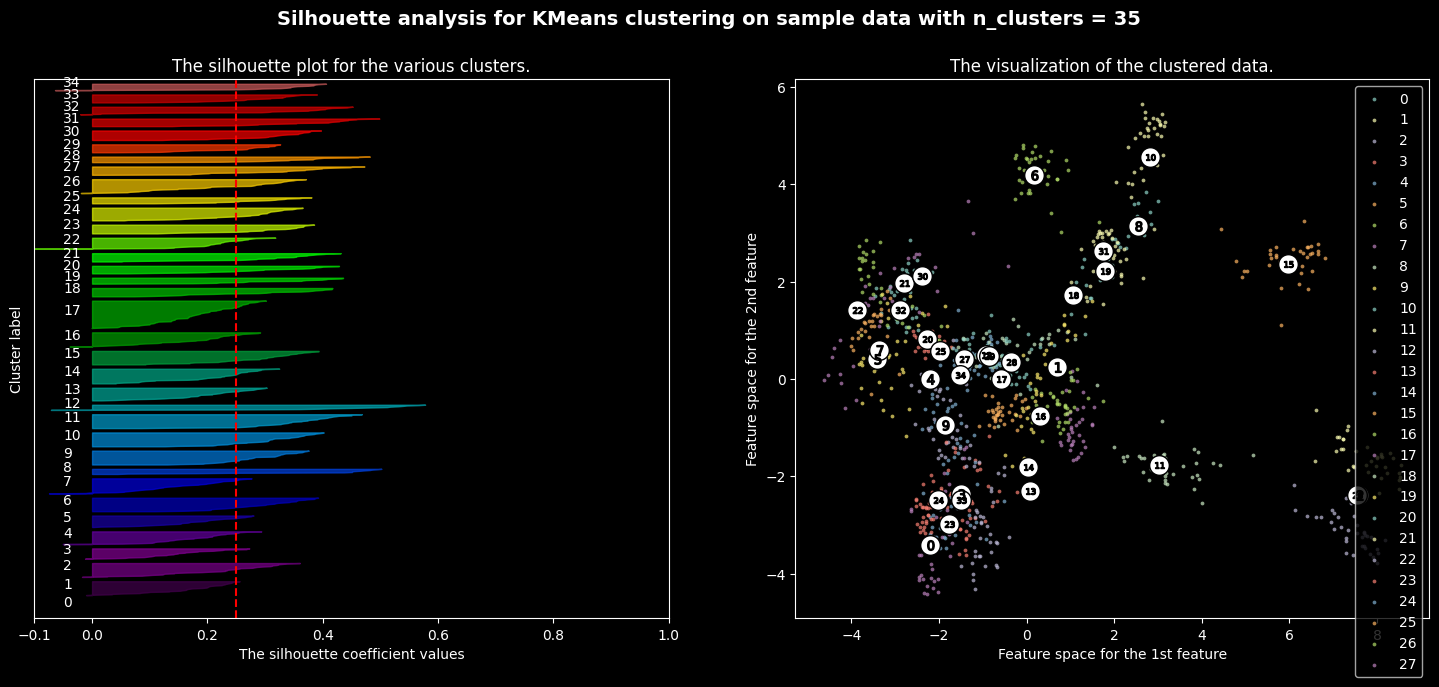

In [41]:
plot_silhoutte(35,X_sub_kmeans_train.values)

For n_clusters = 20 The average silhouette_score is : 0.23019328884880477


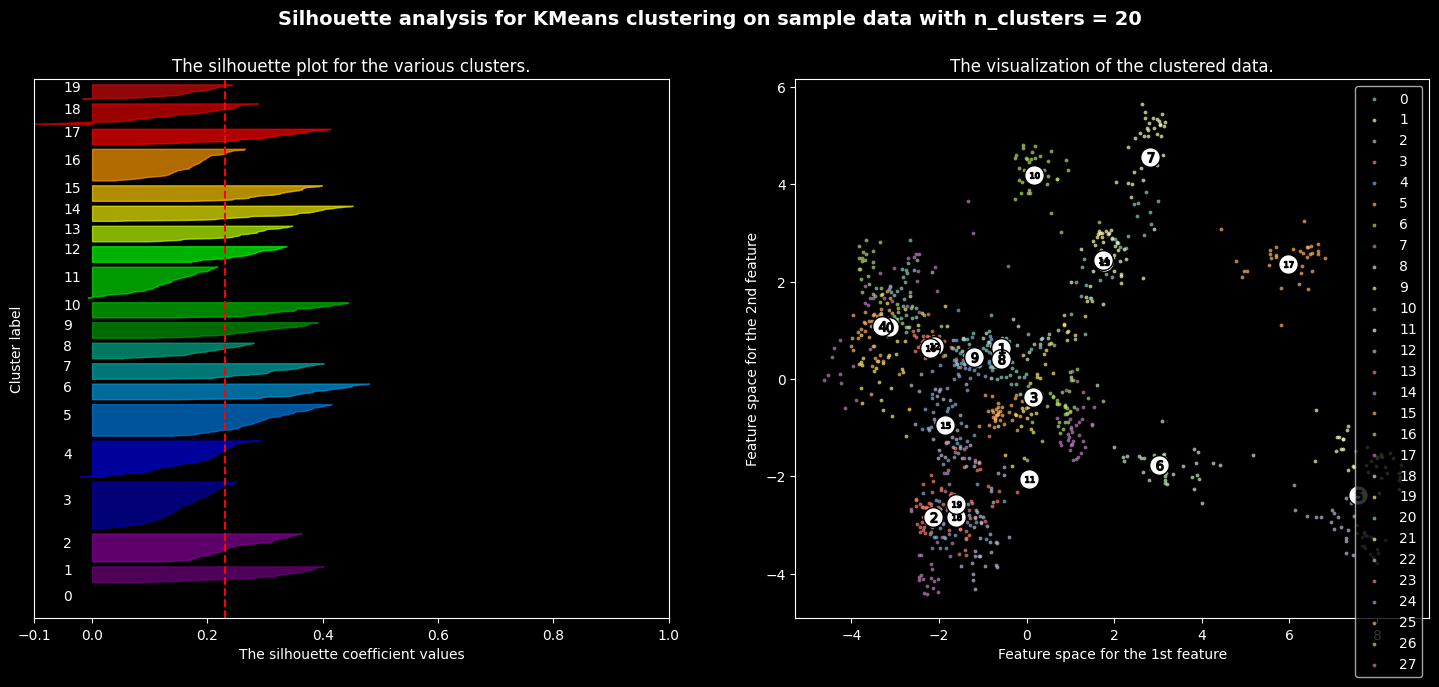

In [42]:
plot_silhoutte(20,X_sub_kmeans_train.values)

# Q7: 
From different clusters for KMeans, `32` turns out to be the best number of clusters as per the silhoutte score. Also, if we plot the silhoutte diagram, `32` number of clusters gives the most uniforma silhoutte plots as compared to other number of clusters. We are also visualizing the scatter plots with different cluster centers and `32` turns out to be the goldilock number of clusters to represent the adequate number of clusters. The inertia value is not very effective to determine the number of clusters as it keeps on decreasing with increasing cluster values. The elbow is hard to identify hence we are going for silhoutte score 

## Q7: VISUALIZE IN CLUSTERS IMAGES 

In [43]:
best_kmeans = KMeans(n_clusters=32)
best_kmeans.fit(X_kmeans_train)

cluster_labels = best_kmeans.predict(X_kmeans_train)

In [44]:
kmeans_train_df = pd.DataFrame(X_kmeans_train,columns=[i for i in range(X_train_scaled.shape[1])])
kmeans_train_df['label'] = y_kmeans_train
kmeans_train_df['kmeans_label'] = cluster_labels

Cluster 0


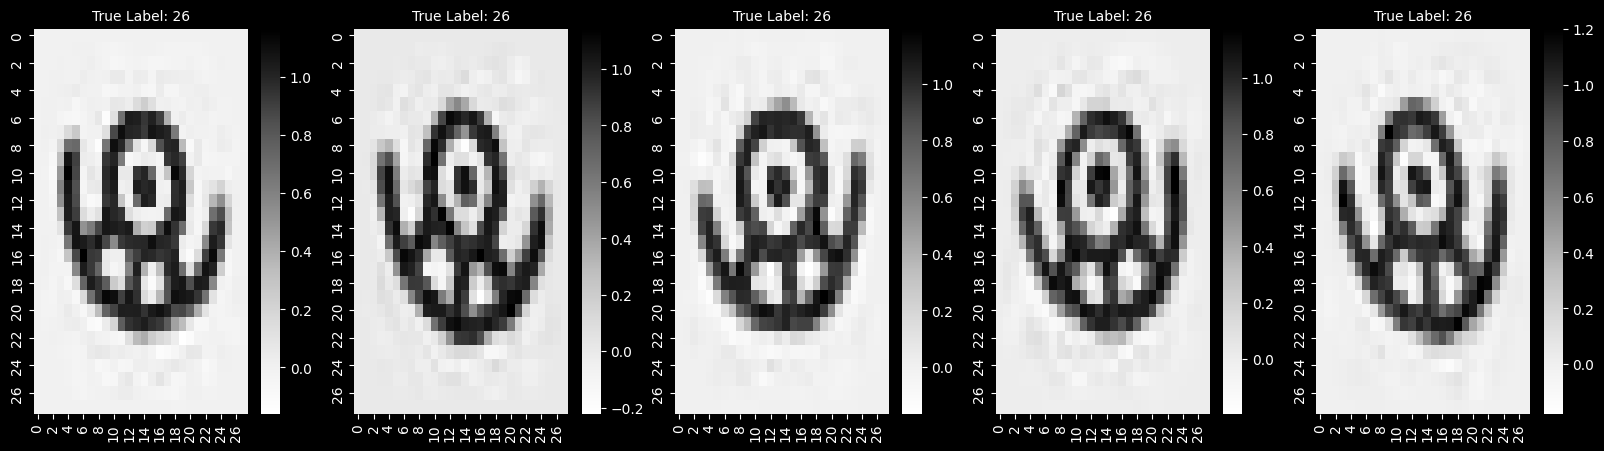

Cluster 1


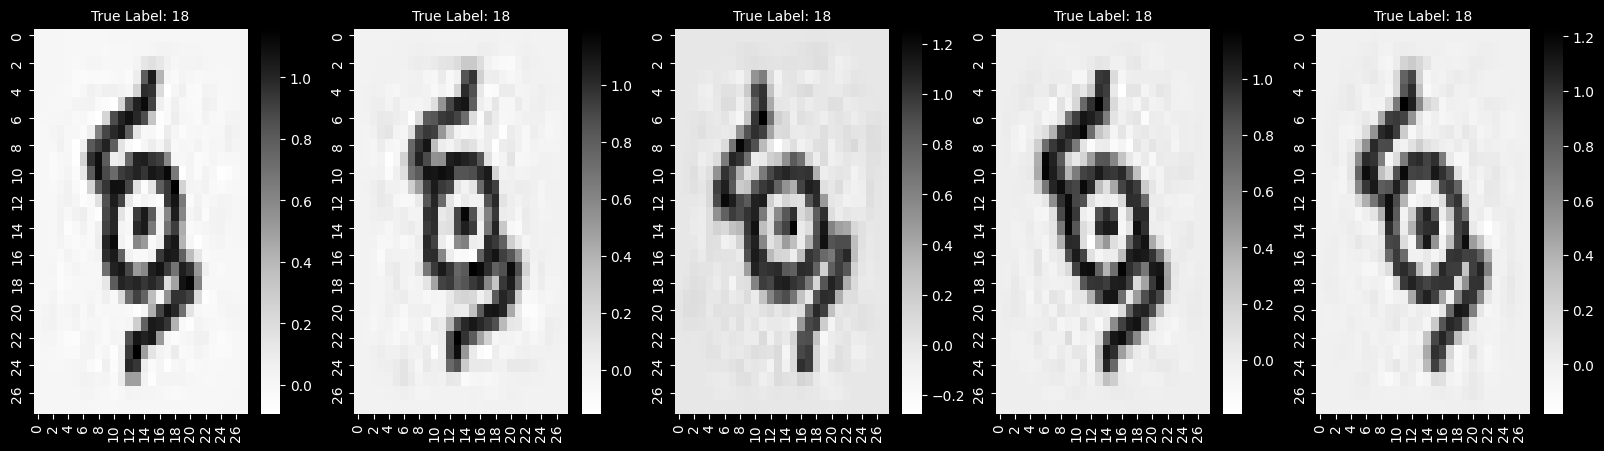

Cluster 2


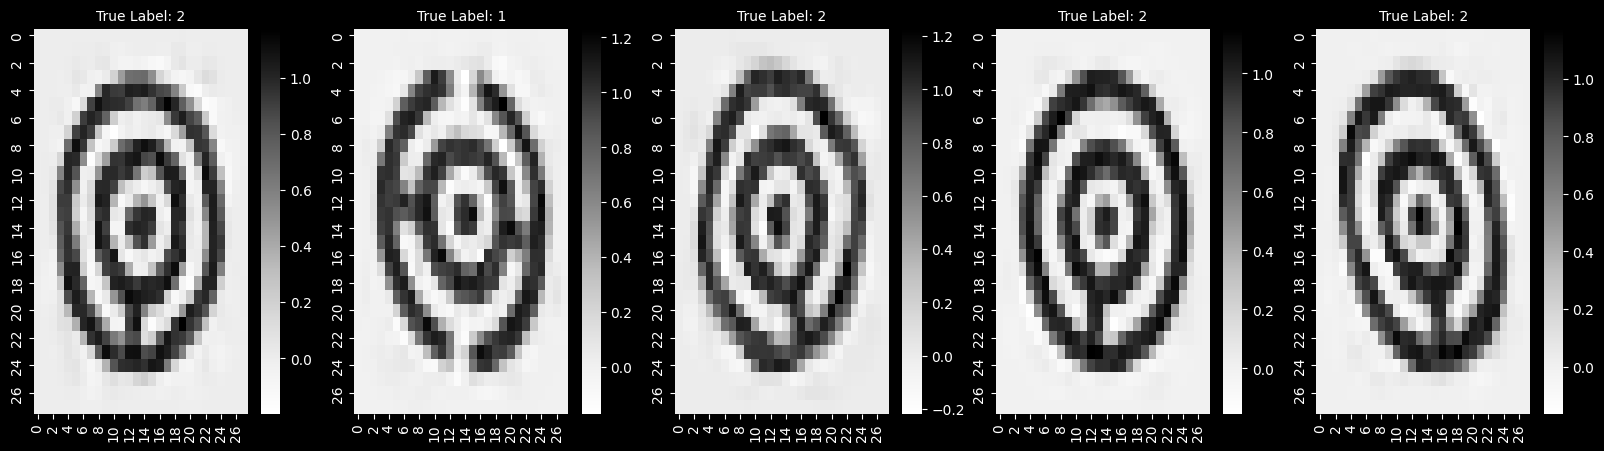

Cluster 3


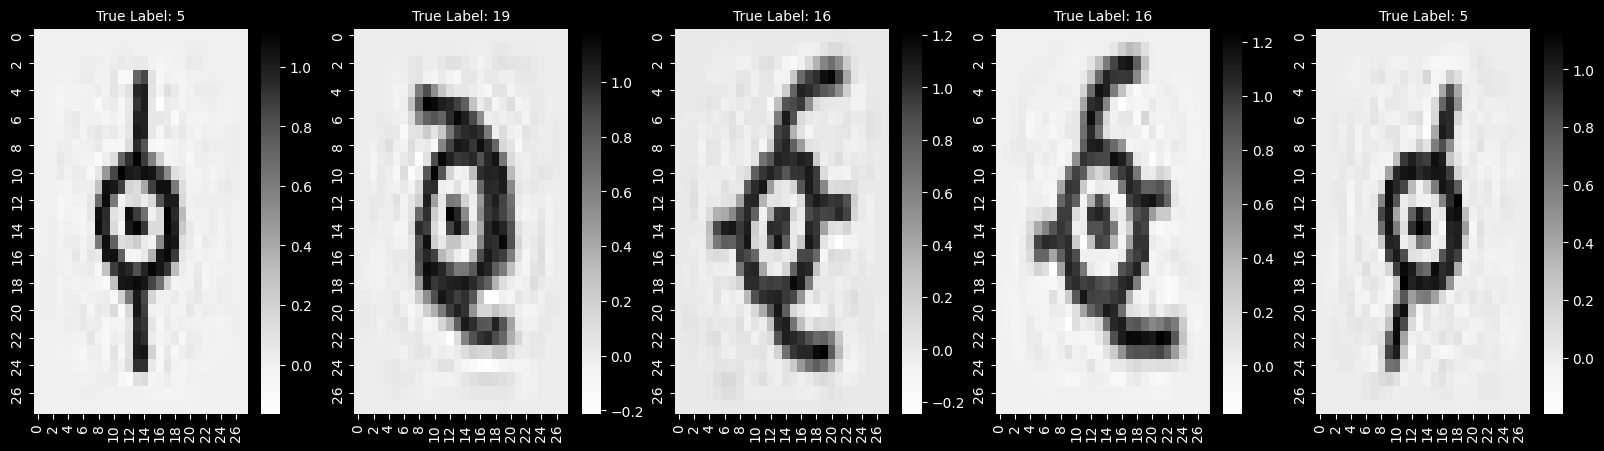

Cluster 4


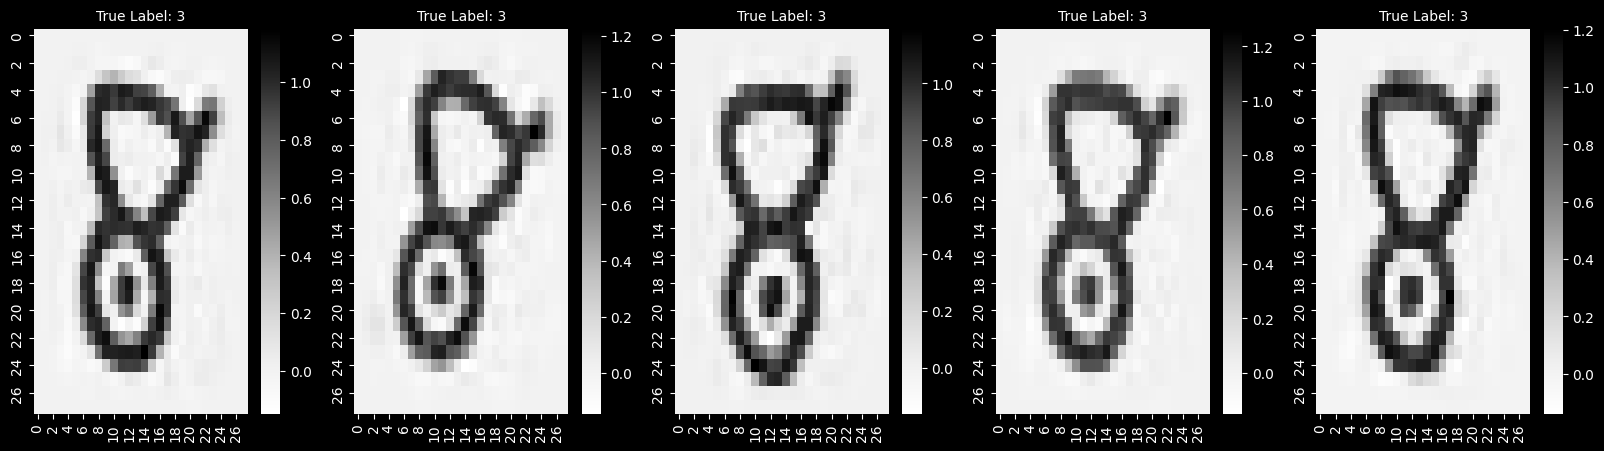

Cluster 5


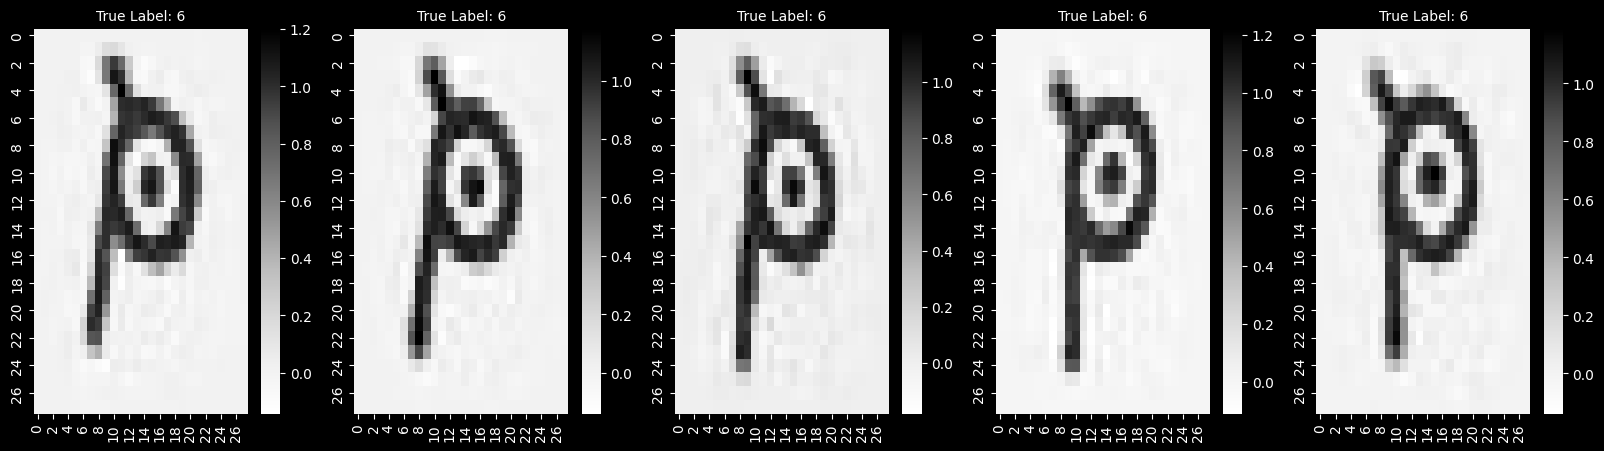

Cluster 6


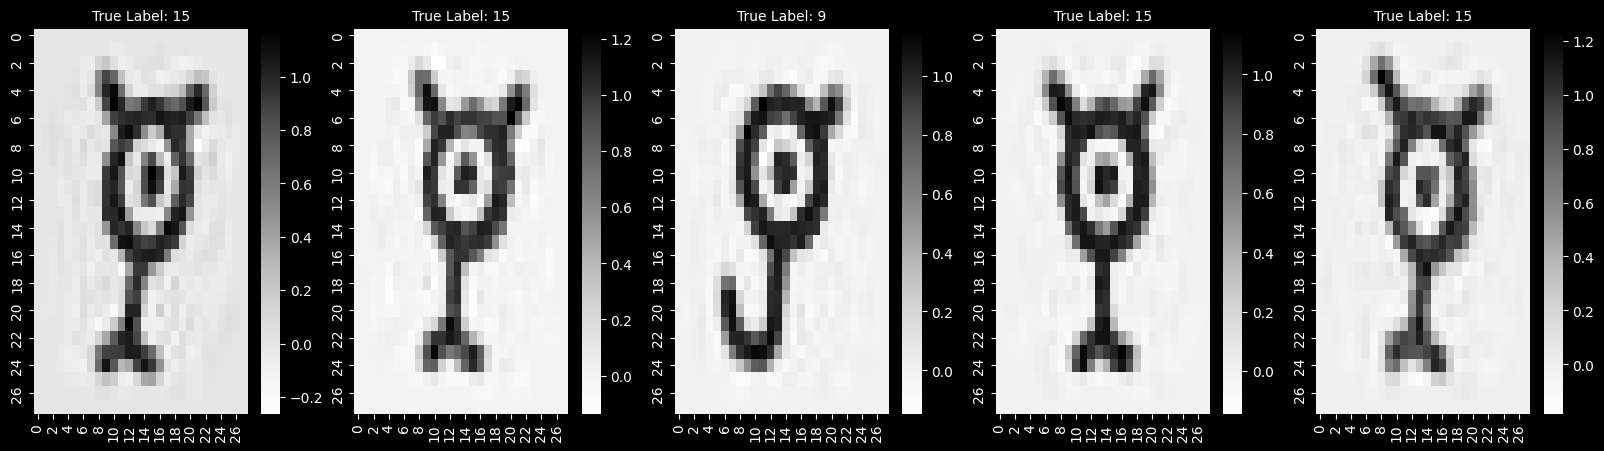

Cluster 7


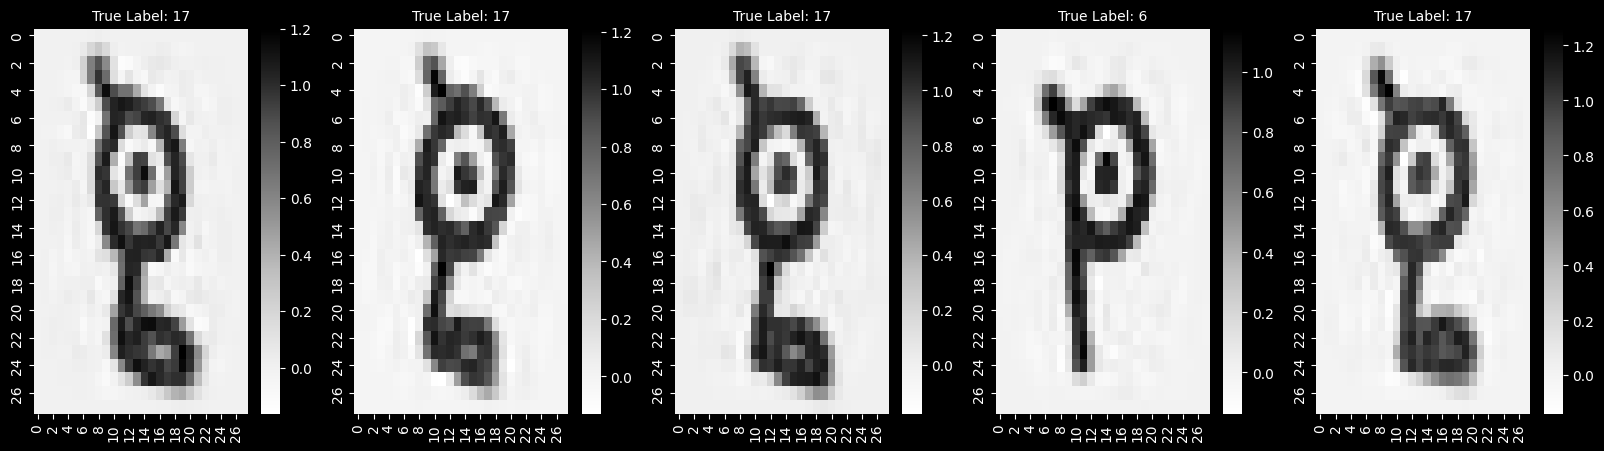

Cluster 8


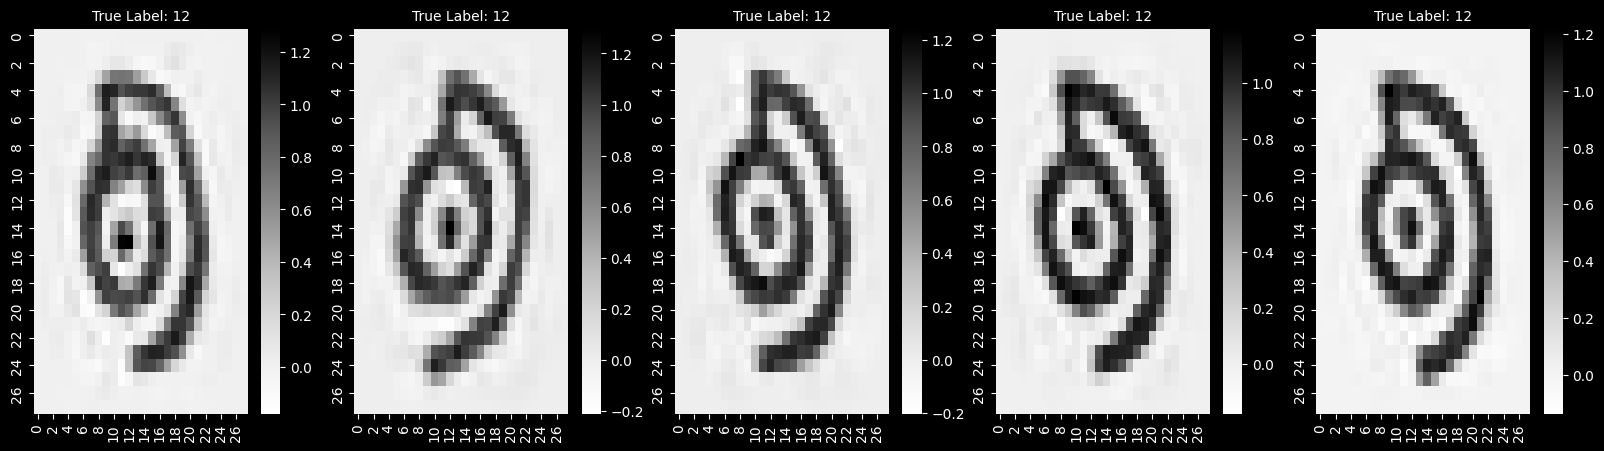

Cluster 9


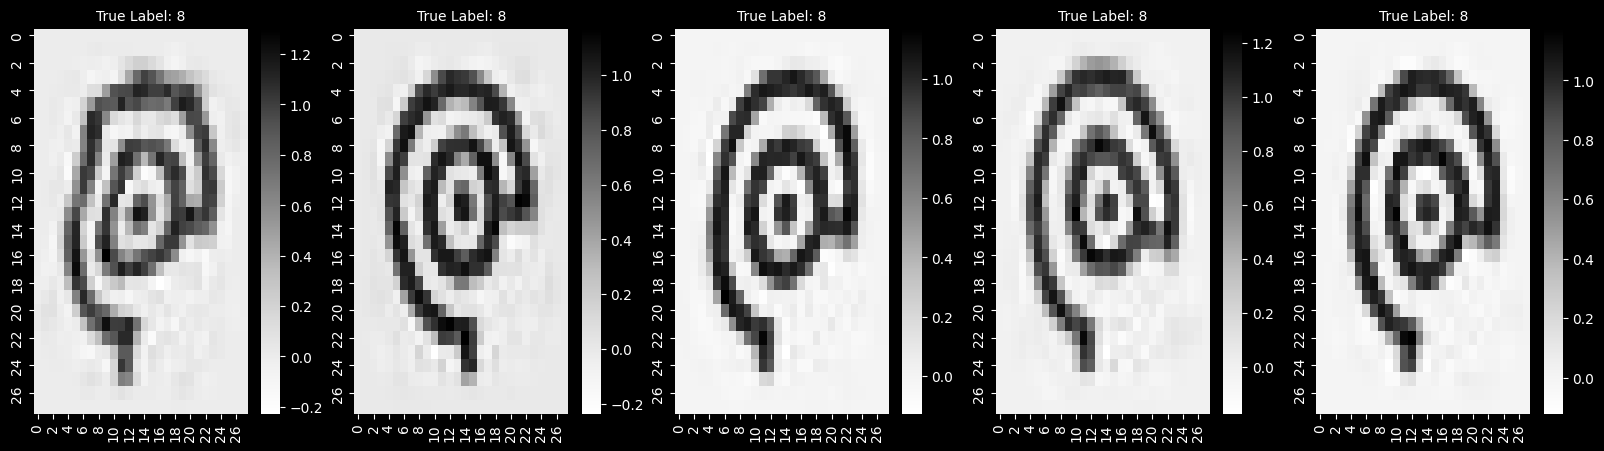

Cluster 10


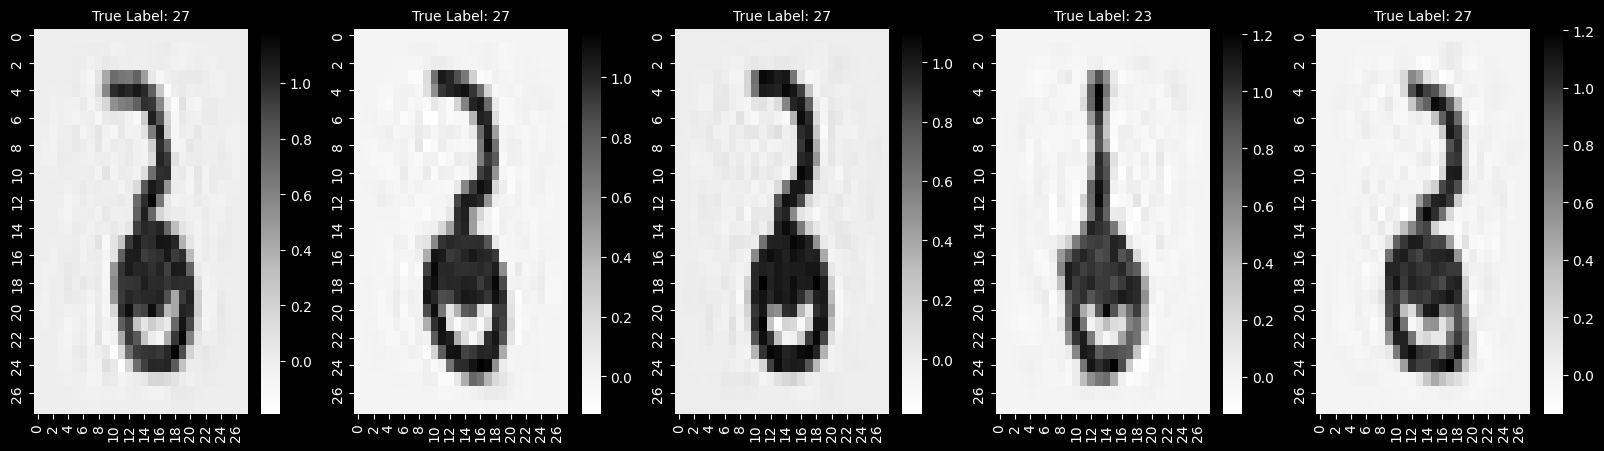

Cluster 11


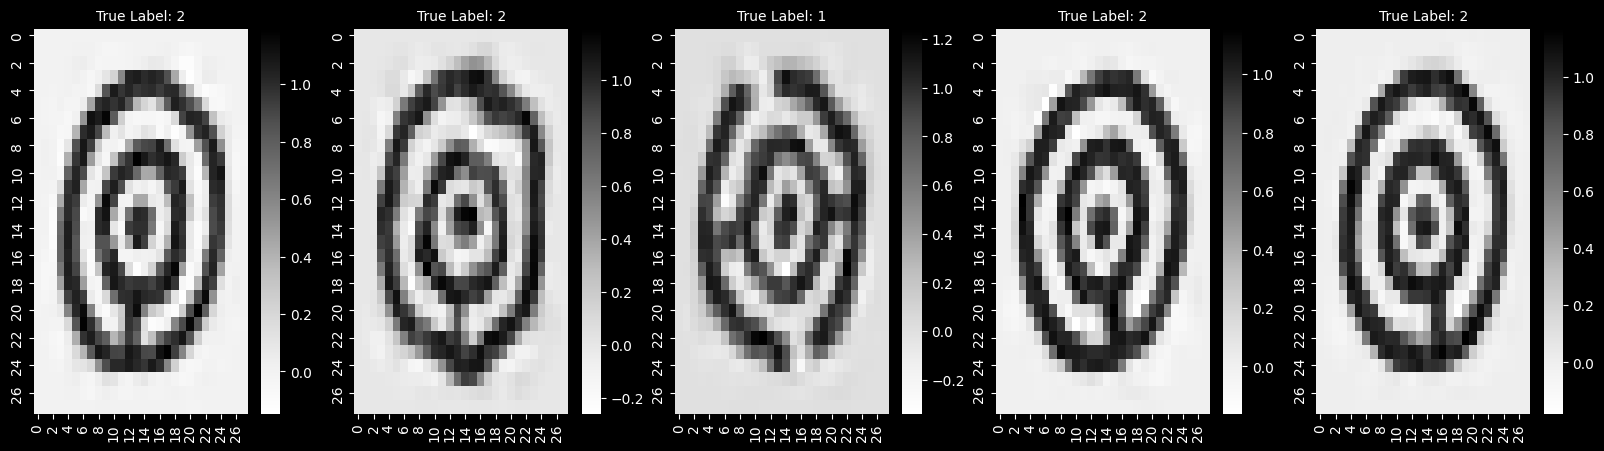

Cluster 12


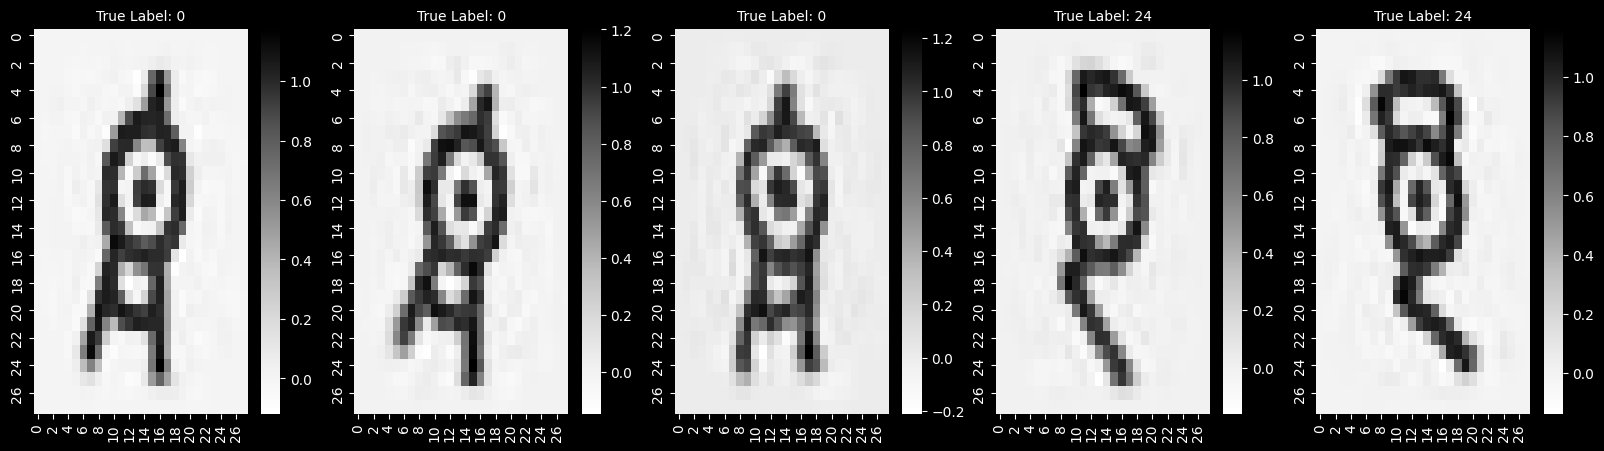

Cluster 13


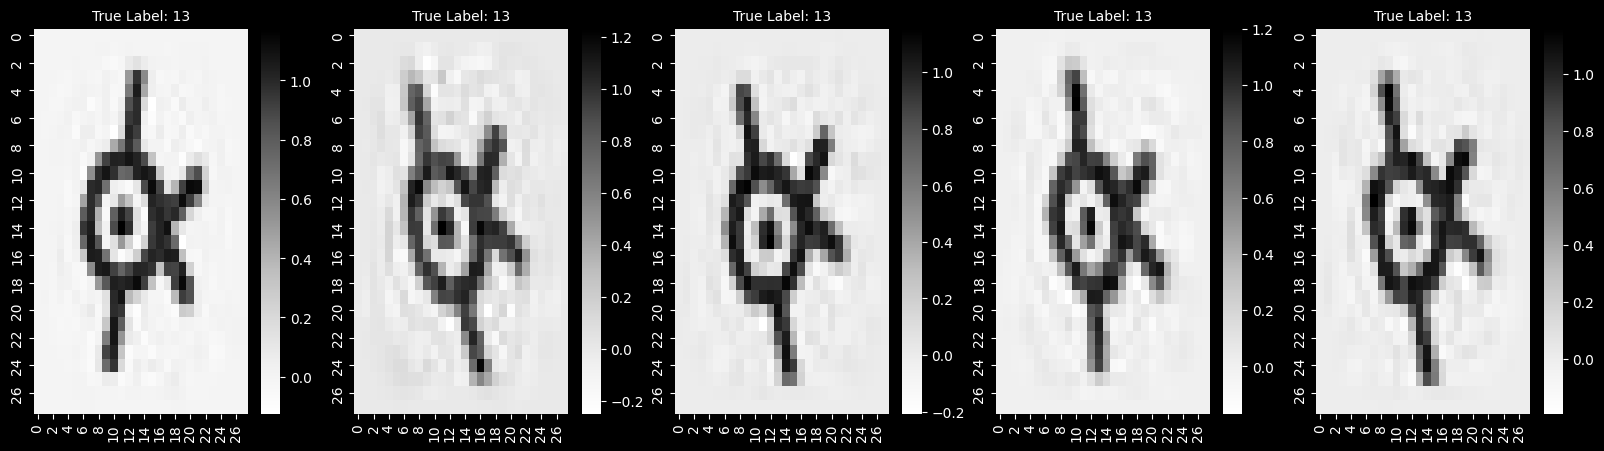

Cluster 14


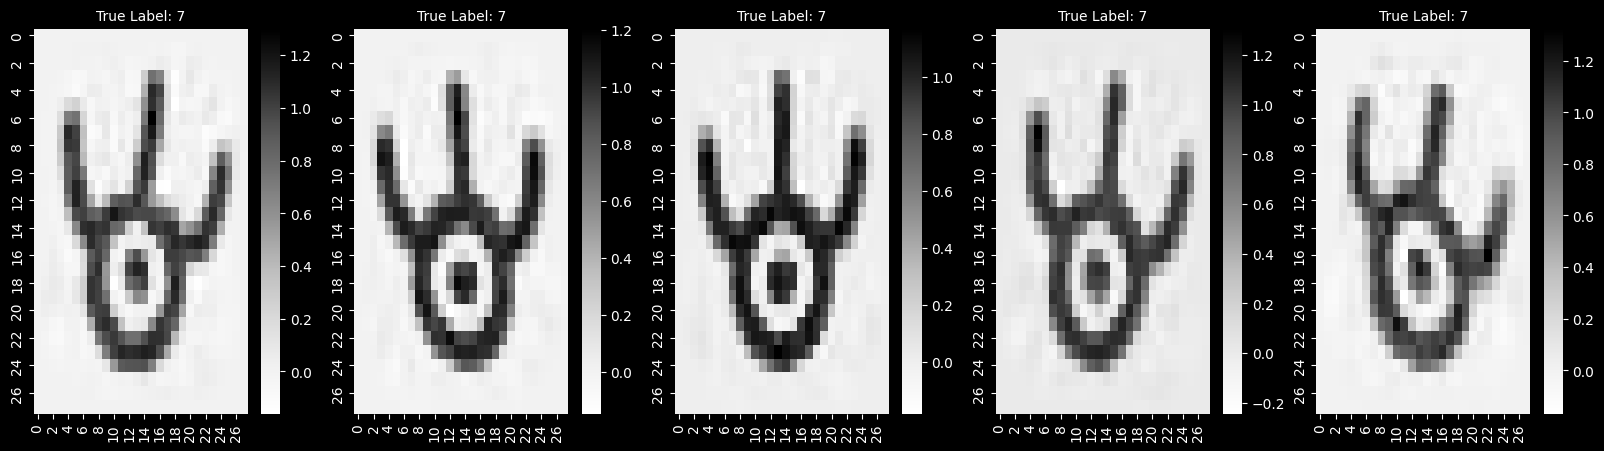

Cluster 15


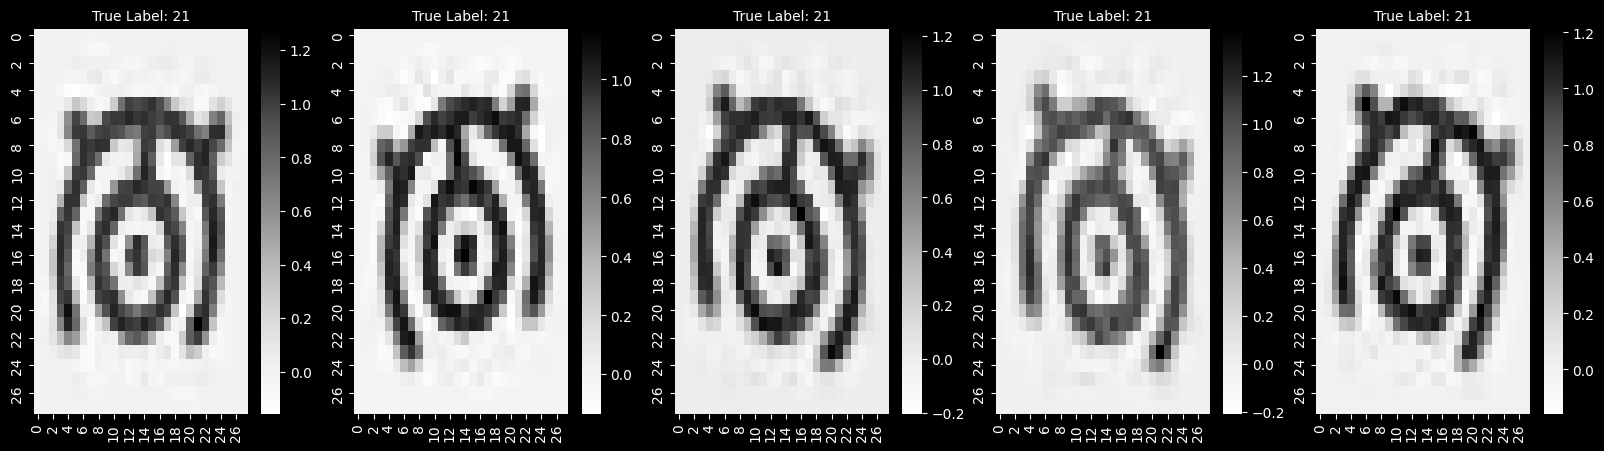

Cluster 16


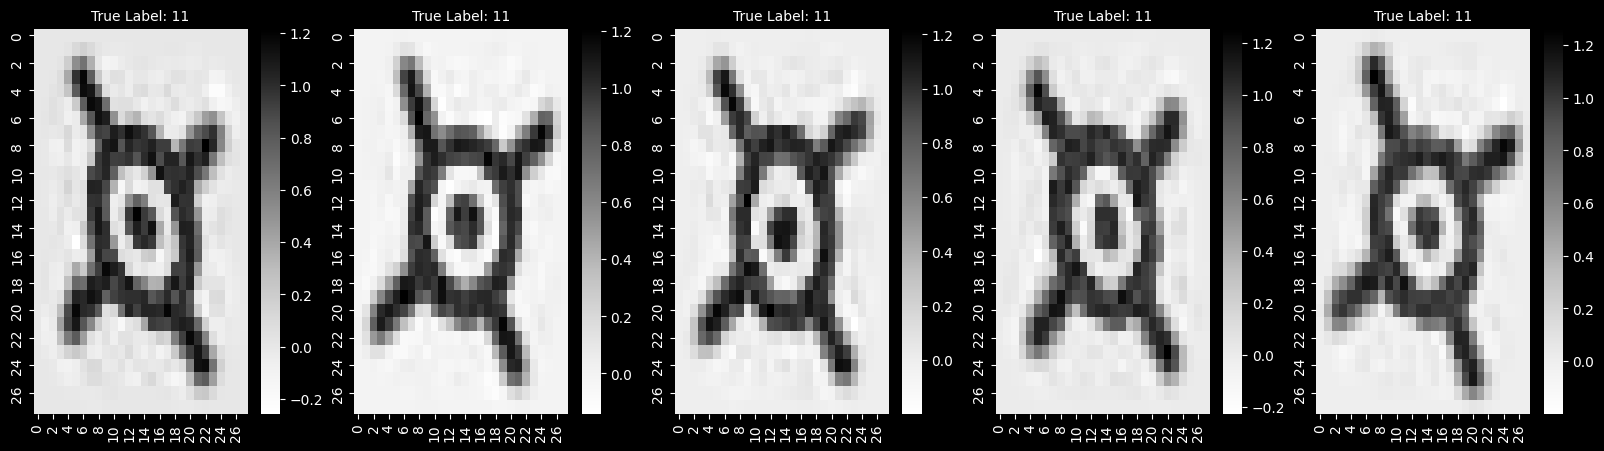

Cluster 17


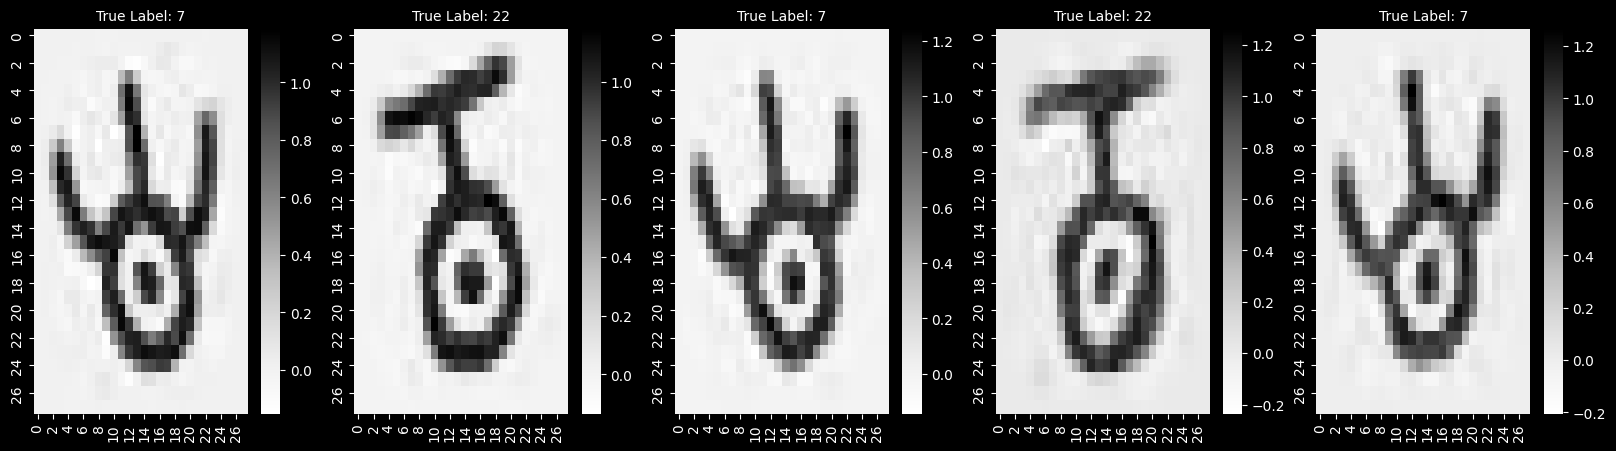

Cluster 18


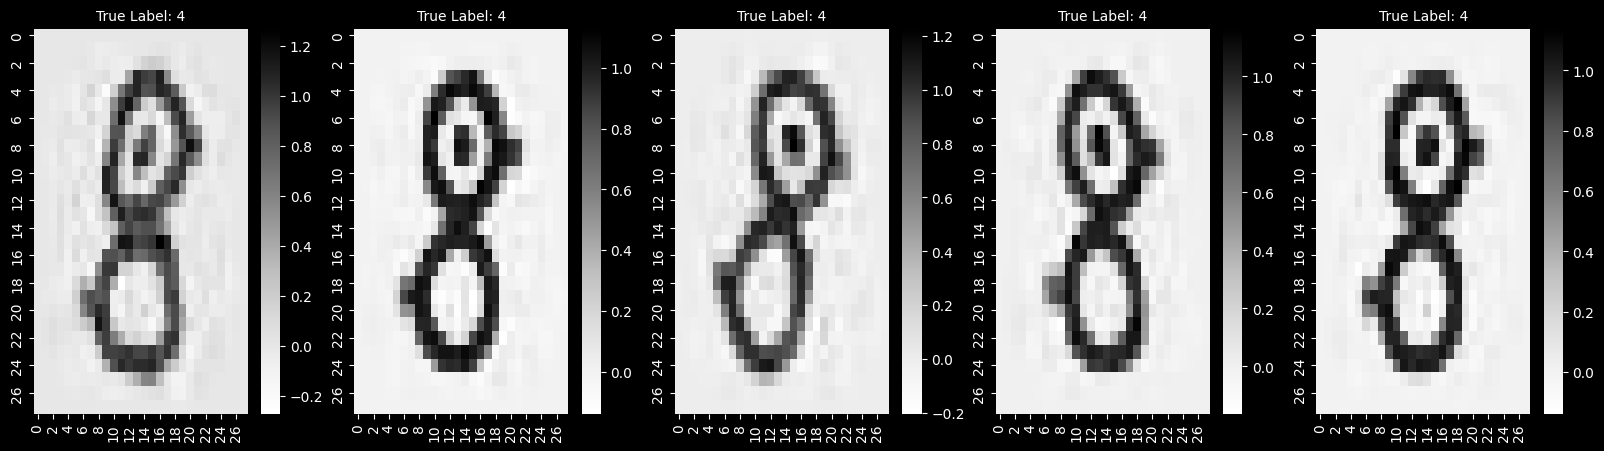

Cluster 19


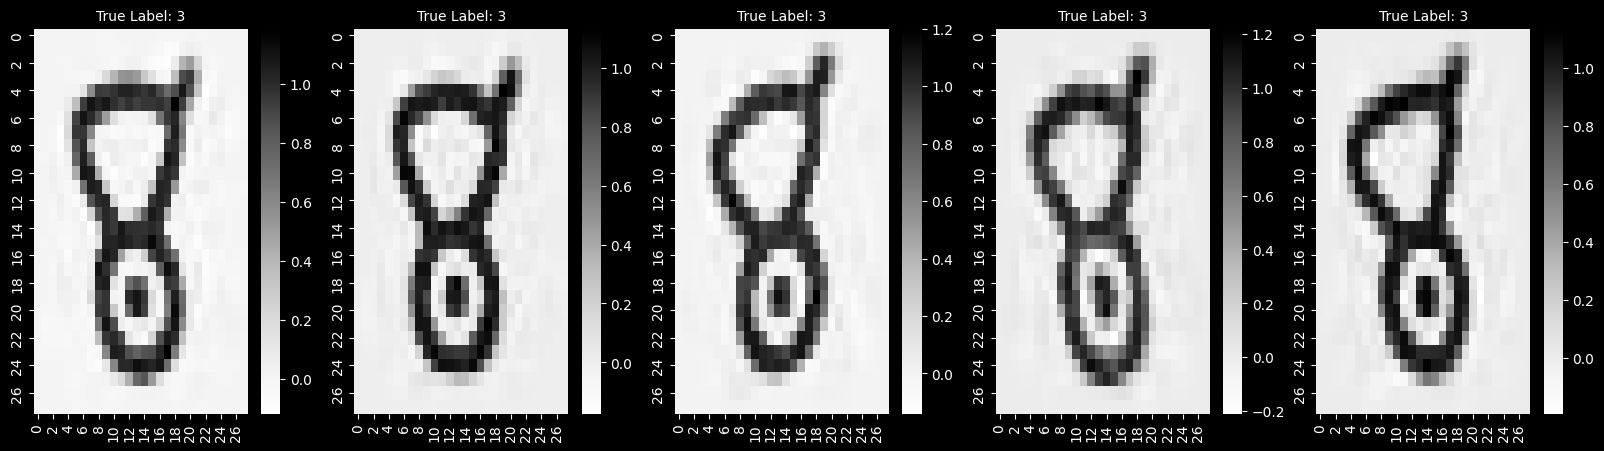

Cluster 20


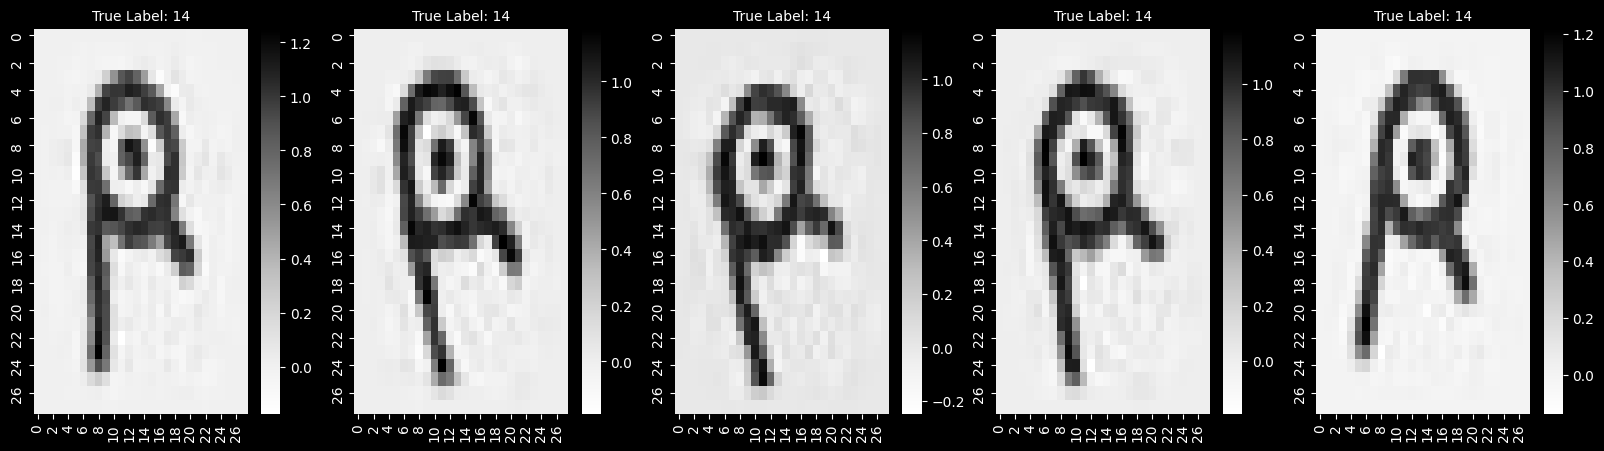

Cluster 21


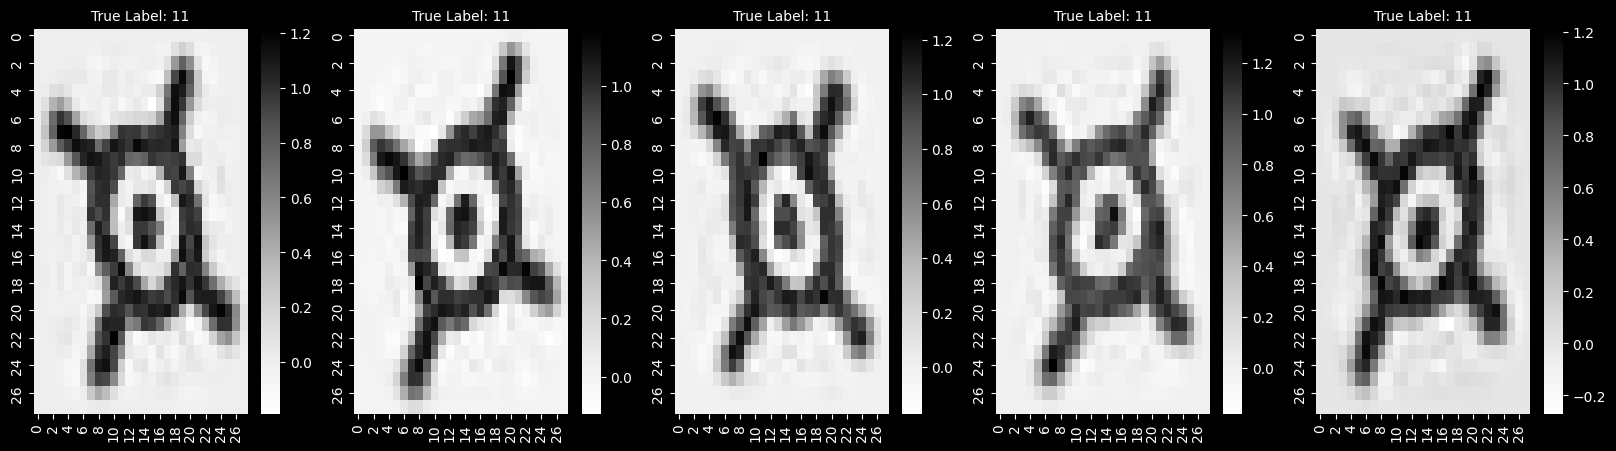

Cluster 22


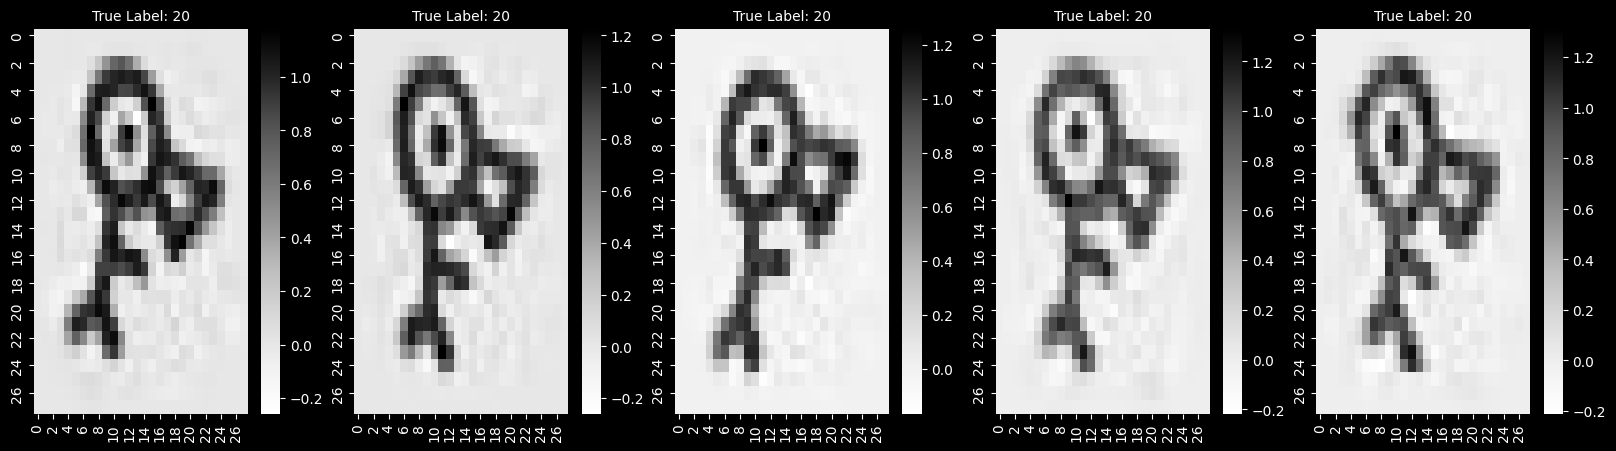

Cluster 23


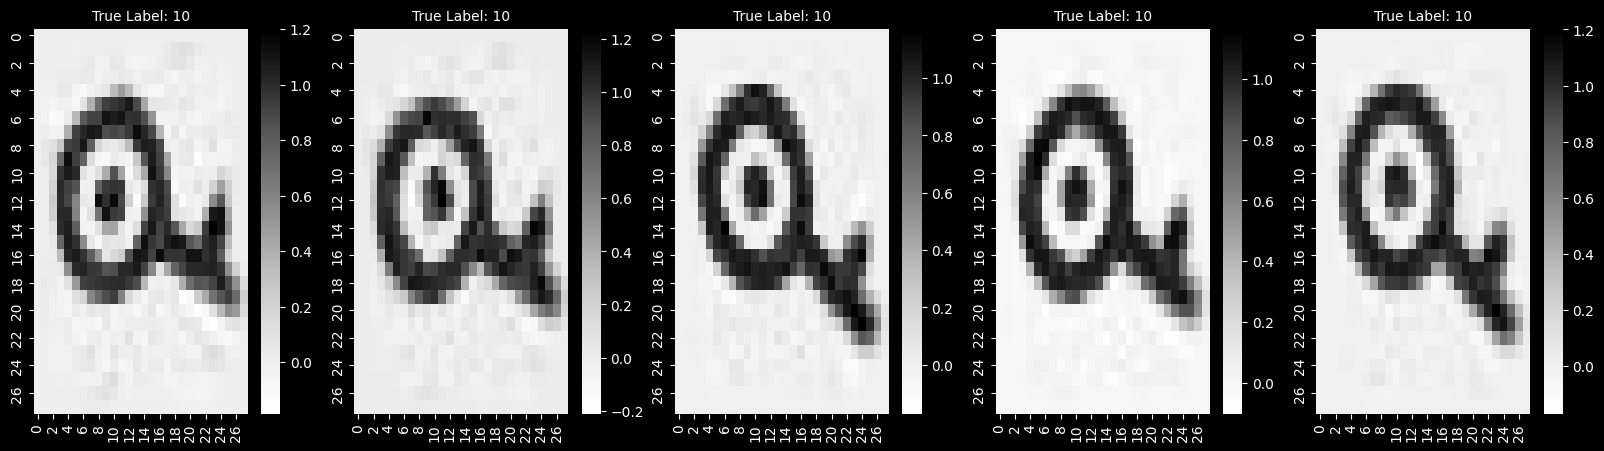

Cluster 24


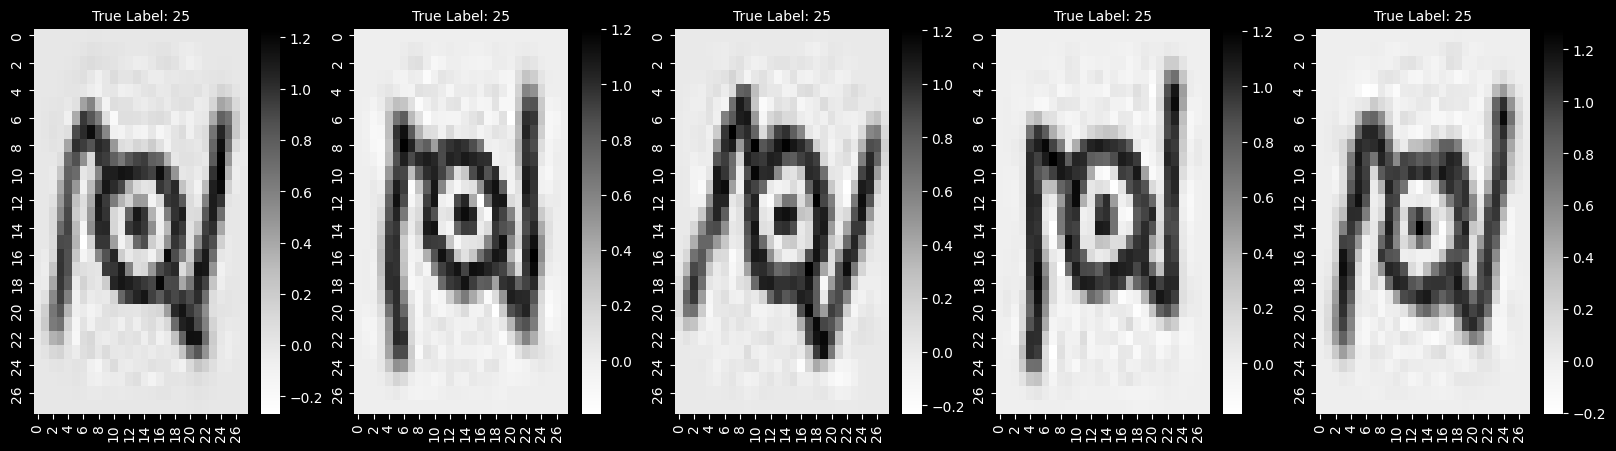

Cluster 25


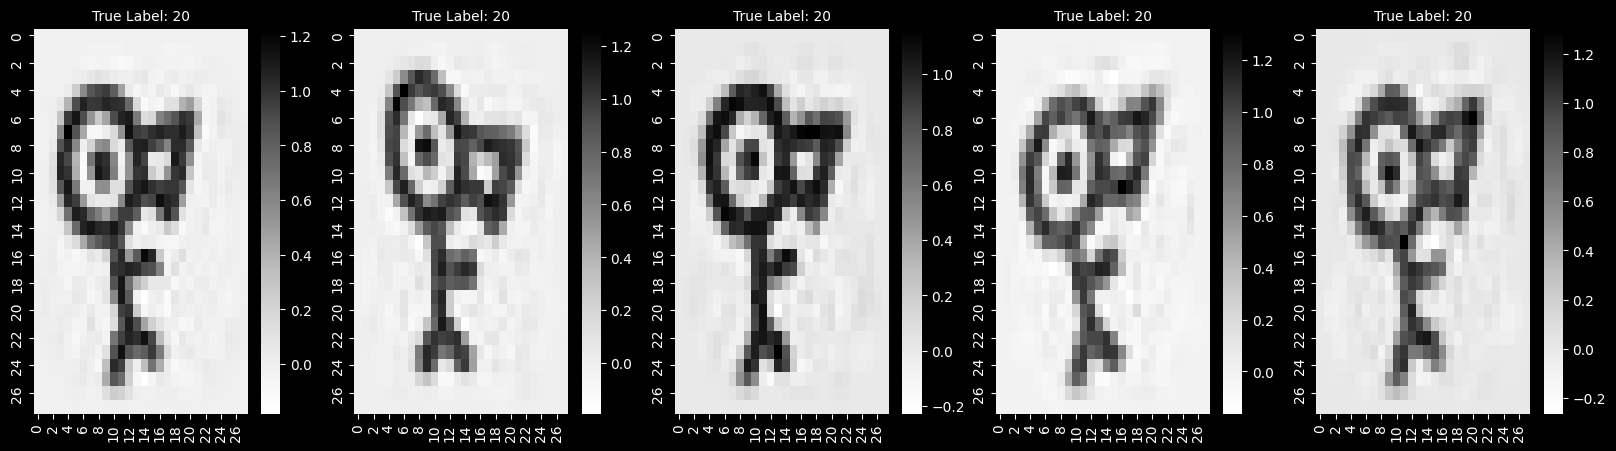

Cluster 26


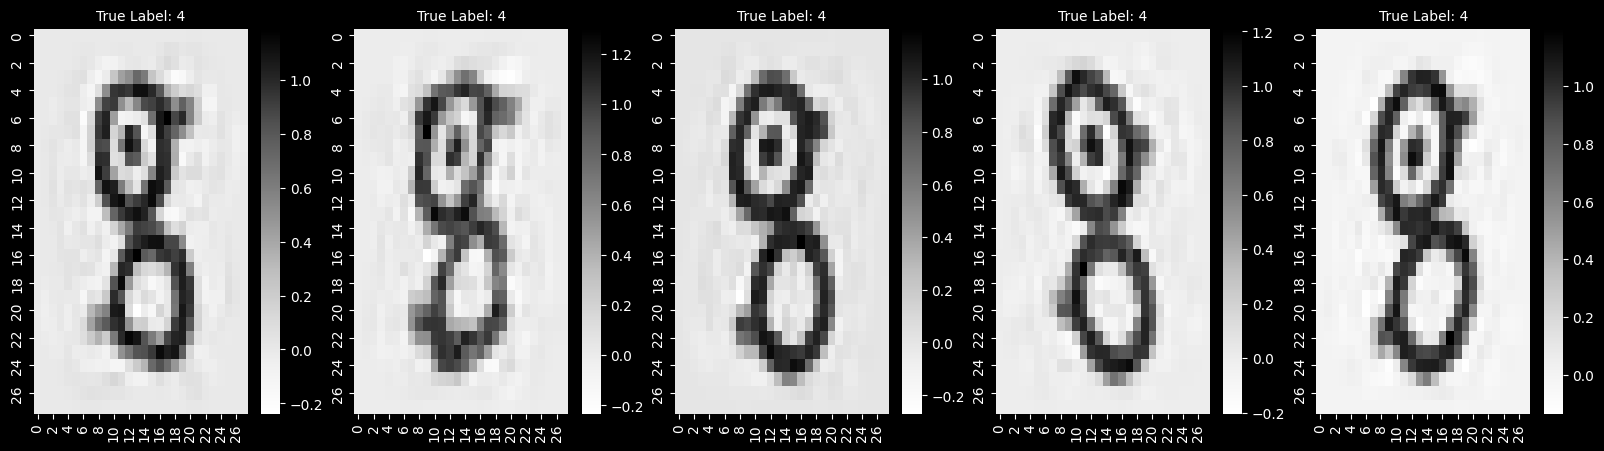

Cluster 27


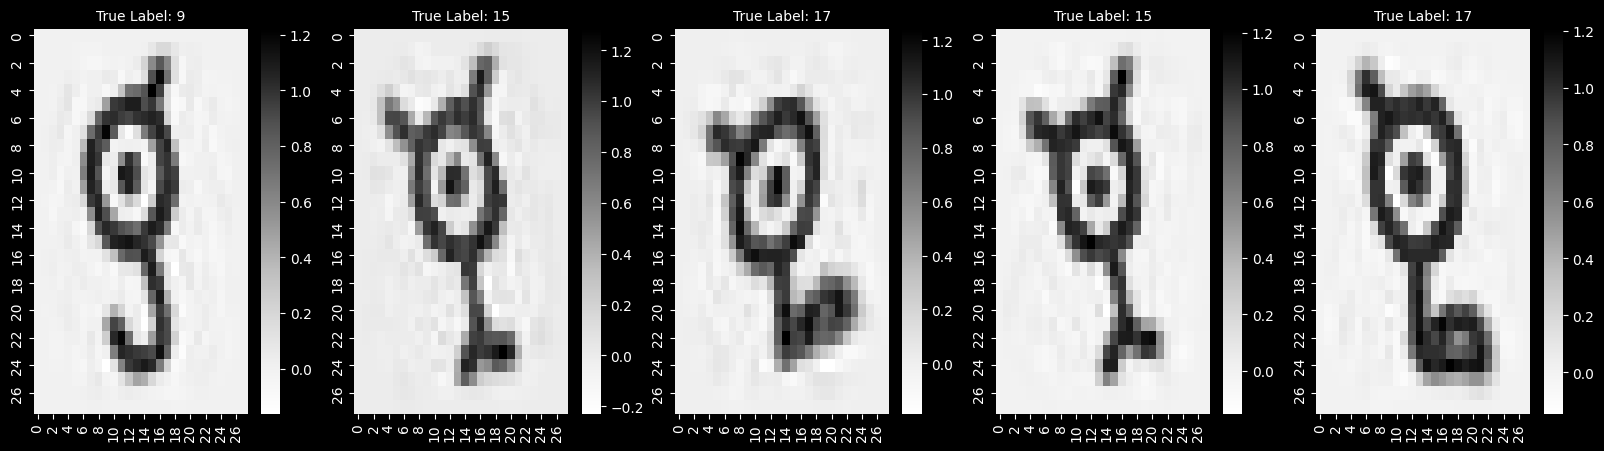

Cluster 28


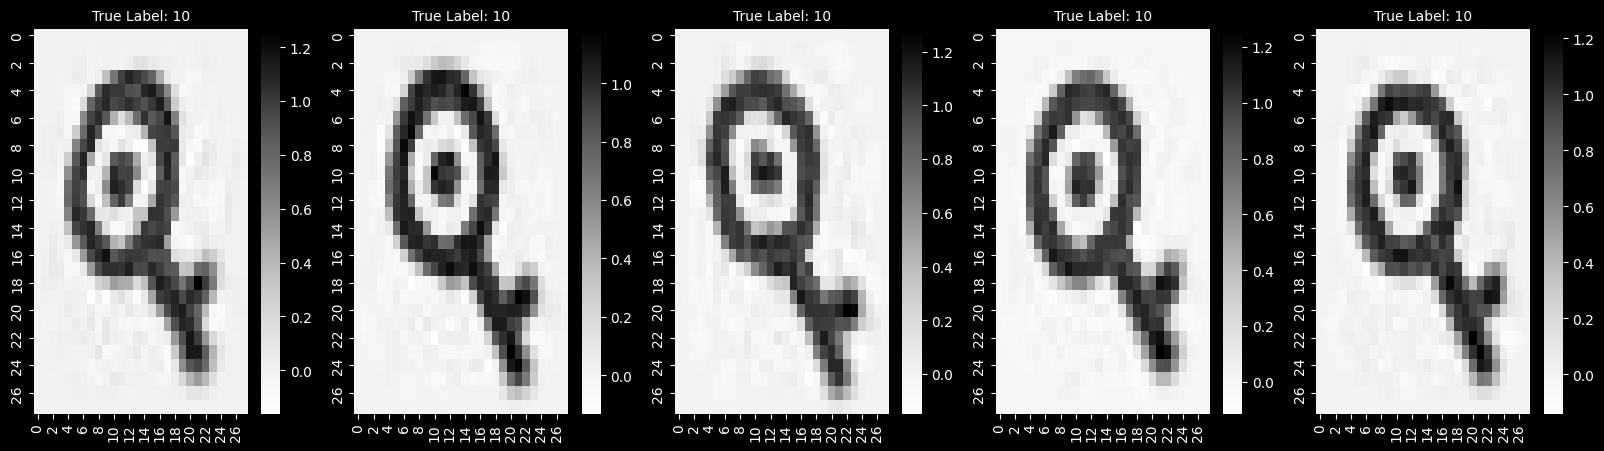

Cluster 29


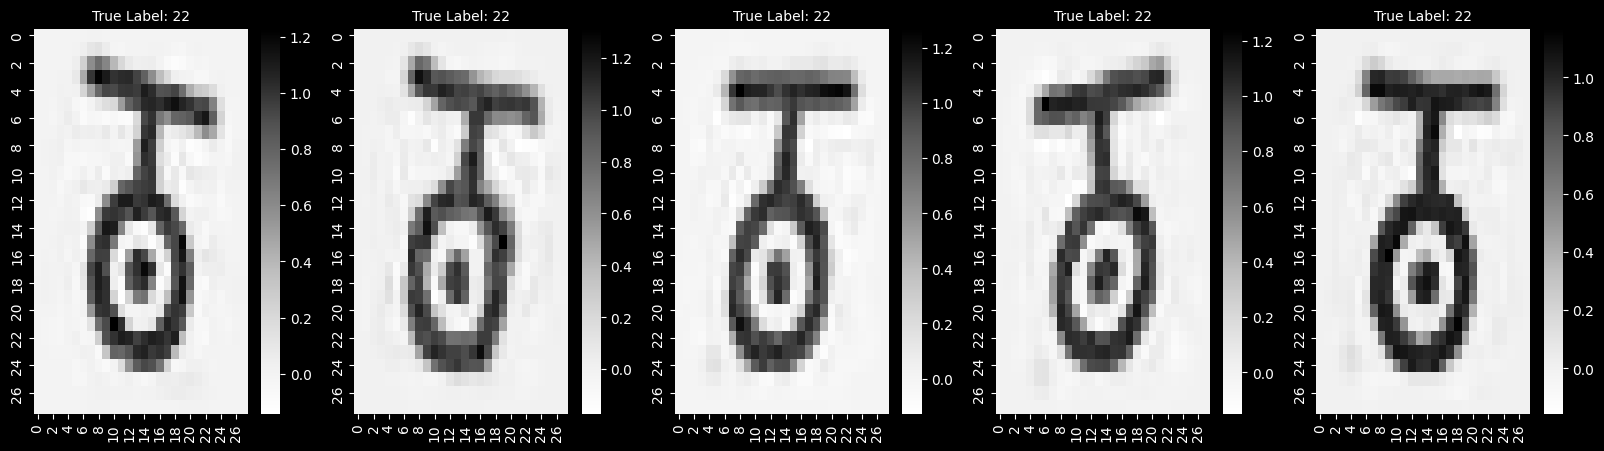

Cluster 30


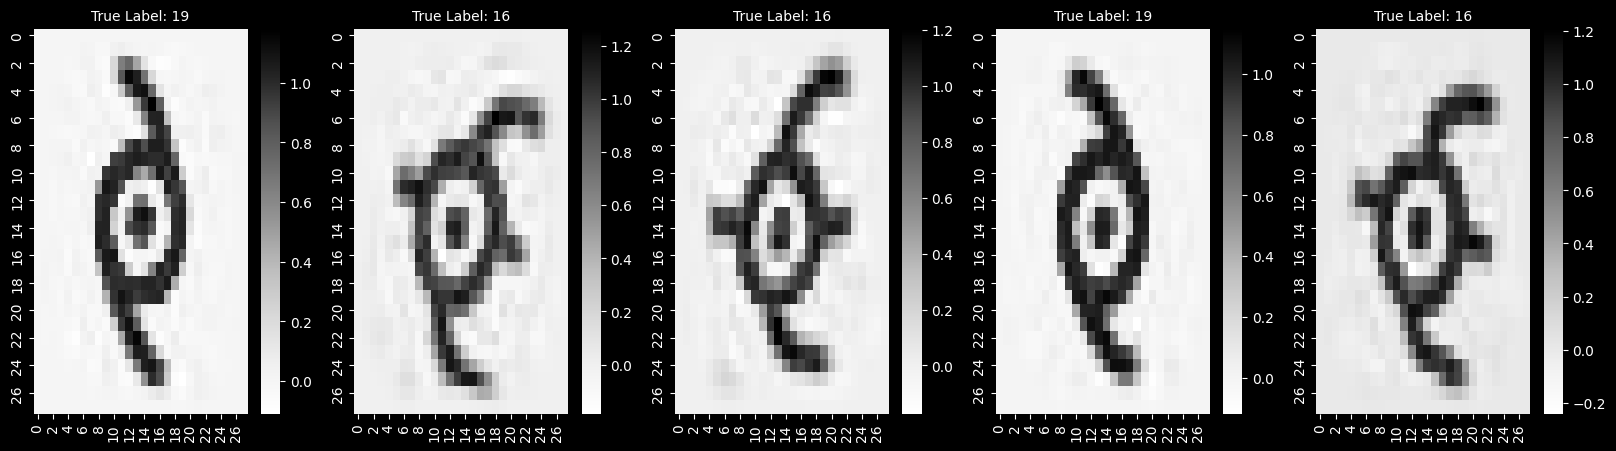

Cluster 31


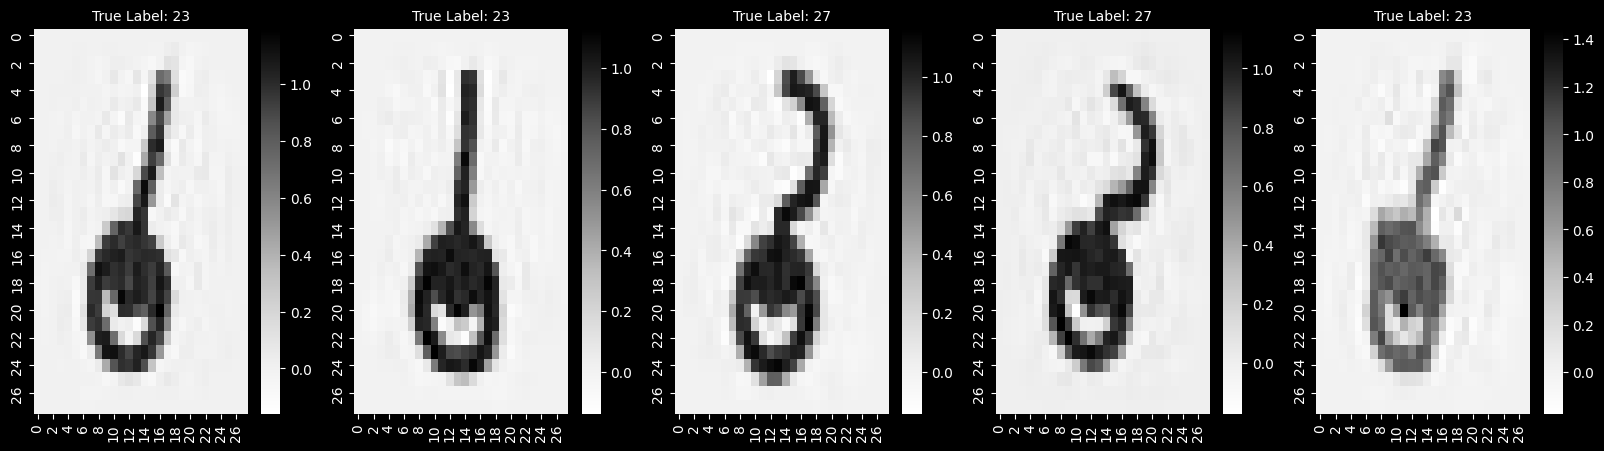

In [45]:
num_imgs = 5
for klabels in kmeans_train_df.groupby("kmeans_label"):
    klabels_ = klabels[1]
    X_vals = klabels_[klabels_.columns[:-2]].values
    X_vals = pca_trans.inverse_transform(X_vals)
    y_vals = klabels_['label'].values
    fig,ax = plt.subplots(1,num_imgs,figsize=(20,5))
    print(f"Cluster {klabels[0]}")
    for i in range(num_imgs):
        sns.heatmap(X_vals[i].reshape(28,28),cmap='Greys',ax=ax[i])
        ax[i].set_title(f"True Label: {y_cols[y_vals[i]]}",fontsize=10)
    plt.show()

## For Q-7
We are visualizing the intra-cluster images and we can see that the clusters have similar images and it also captures some distortion in the image. Sometimes it messes up the orientation of the image which is expected as it is hard to capture those variations. But overall K-Means does a good job to cluster around 32 cluster centers.

## GAUSSIAN MIXTURE MODELS

In [46]:
X_train_scaled_df = pd.DataFrame(X_train_scaled)
train = pd.concat([X_train_scaled_df,y_train],axis=1)
sample_data_gmm = train.groupby('label').apply(lambda x:x.sample(frac=1/5,random_state=42)).reset_index(drop=True)
X_sub_gmm = sample_data_gmm[sample_data_gmm.columns[:-1]]
y_sub_gmm = sample_data_gmm['label']

In [47]:
from sklearn.mixture import GaussianMixture

gmm_full = GaussianMixture(n_components=10,n_init=5,covariance_type="full")
gmm_diag = GaussianMixture(n_components=10,n_init=5,covariance_type="diag")
gmm_tied = GaussianMixture(n_components=10,n_init=5,covariance_type="tied")
gmm_spherical = GaussianMixture(n_components=10,n_init=5,covariance_type="spherical")

In [48]:
def save_dictionary(name:str,dicts_):
    import pickle 

    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(dicts_, f)
def read_dictionary(name:str):        
    with open(f'{name}.pkl', 'rb') as f:
        dicts_ = pickle.load(f)
    return dicts_

In [49]:
from tqdm import tqdm
def get_gaussian_mixture(k_min=5,k_max=20,covariance_type='full'):
    model_gmms = {}
    model_bics = {}
    model_aics = {}
    for n_components in tqdm(range(k_min,k_max+1)):
        gmm_model = GaussianMixture(n_components=n_components,covariance_type=covariance_type,n_init=5).fit(X_sub_gmm)
        model_gmms.update({str(n_components):gmm_model})
        model_bics.update({str(n_components):gmm_model.bic(X_sub_gmm)})
        model_aics.update({str(n_components):gmm_model.aic(X_sub_gmm)})
    plt.figure(figsize=(20,8))
    plt.plot(model_bics.keys(),model_bics.values(),label='BIC')
    plt.plot(model_aics.keys(),model_aics.values(),label='AIC')
    plt.ylabel('Information Criterion')
    plt.xlabel("Number of Clusters")
    plt.legend()
    plt.title(f'{covariance_type} GMM model')
    plt.show()
    
    plt.savefig(f'{covariance_type}.png')

    return model_gmms,model_bics,model_aics

100%|██████████| 16/16 [12:03<00:00, 45.22s/it]


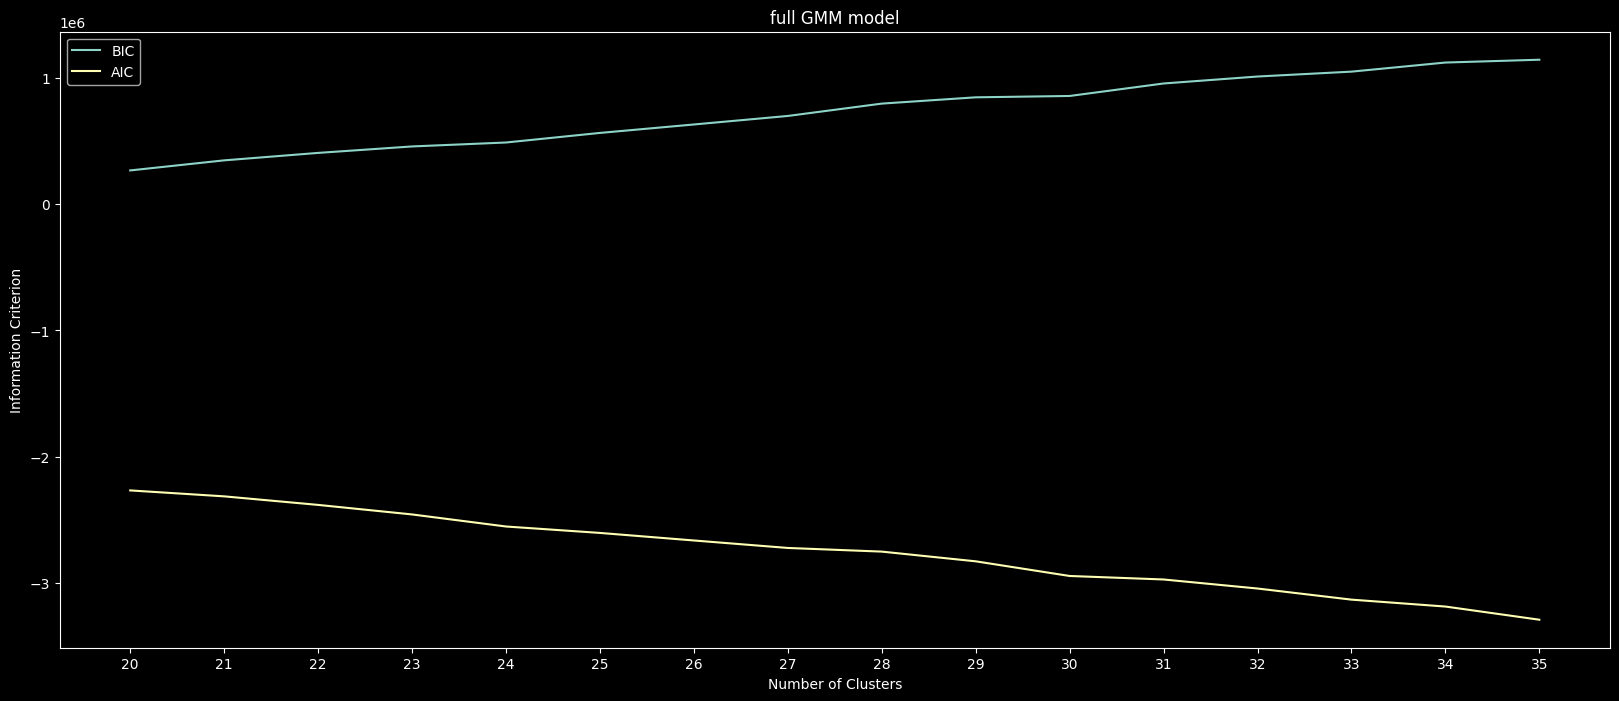

It took 723.878


<Figure size 640x480 with 0 Axes>

In [54]:
import time
start = time.time()
full_model_gmm,full_bic,full_aic = get_gaussian_mixture(k_min=20,k_max=35)
print(f"It took {round(time.time()-start,3)}")
save_dictionary('AIC_FULL',full_aic)
save_dictionary('BIC_FULL',full_bic)

100%|██████████| 16/16 [01:12<00:00,  4.56s/it]


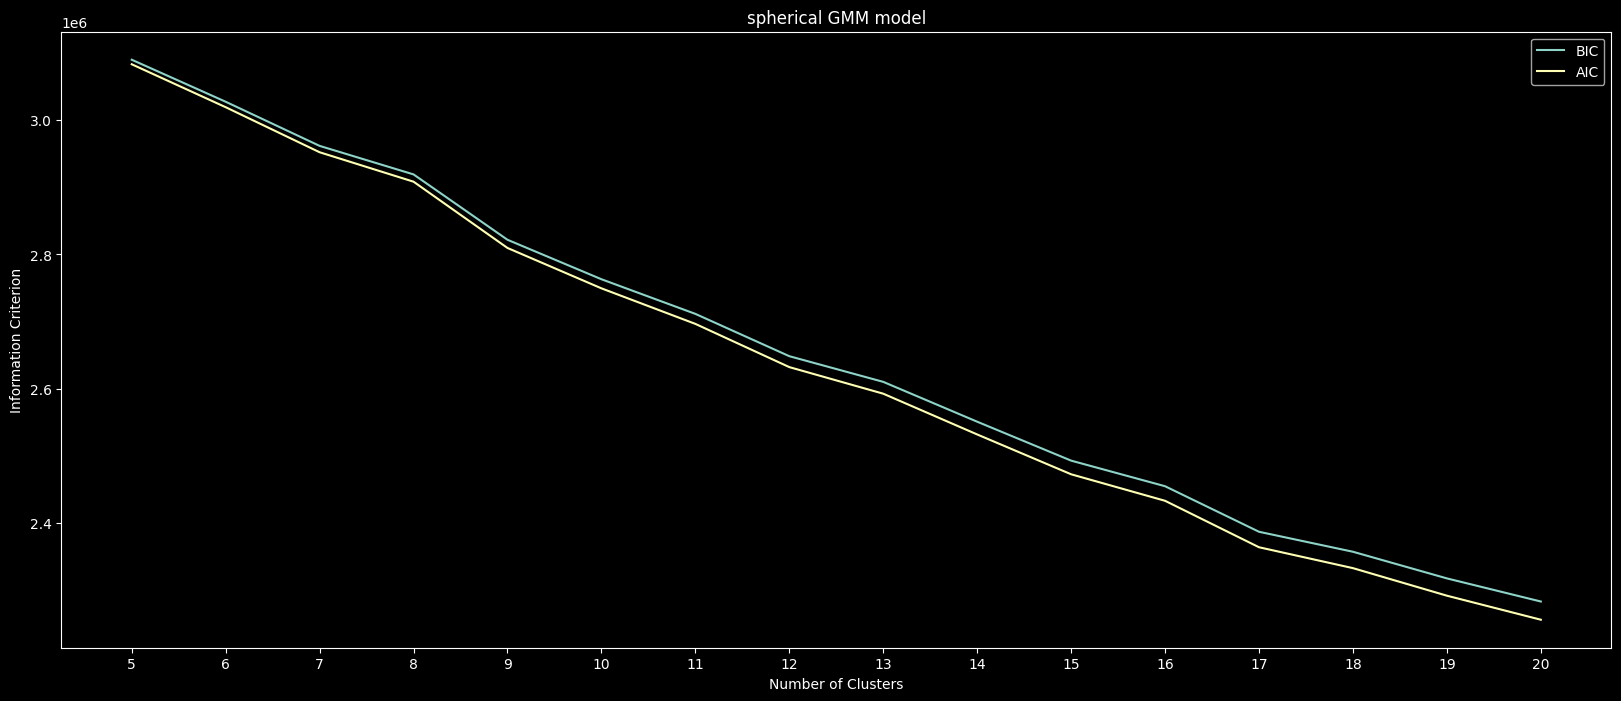

It took 73.366


<Figure size 640x480 with 0 Axes>

In [55]:
import time
start = time.time()
spherical_model_gmm,spherical_bic,spherical_aic = get_gaussian_mixture(k_min=20,k_max=35,covariance_type='spherical')
print(f"It took {round(time.time()-start,3)}")
save_dictionary('AIC_SPHERICAL',spherical_aic)
save_dictionary('BIC_SPHERICAL',spherical_bic)

100%|██████████| 16/16 [01:34<00:00,  5.91s/it]


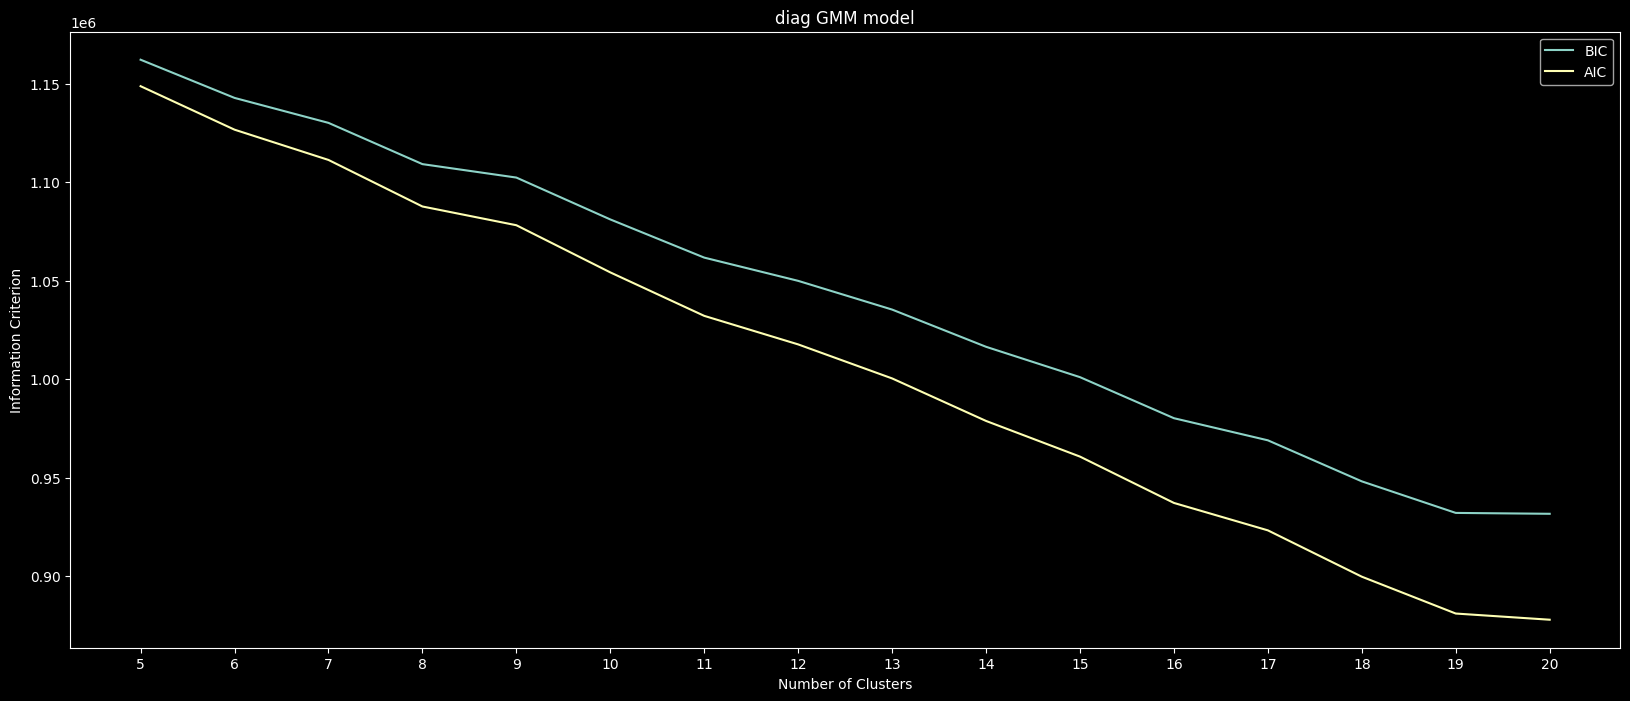

It took 94.989


<Figure size 640x480 with 0 Axes>

In [56]:
import time
start = time.time()
diag_model_gmm,diag_bic,diag_aic = get_gaussian_mixture(k_min=5,k_max=20,covariance_type='diag')
print(f"It took {round(time.time()-start,3)}")

save_dictionary('AIC_DIAG',diag_aic)
save_dictionary('BIC_DIAG',diag_bic)

100%|██████████| 16/16 [06:20<00:00, 23.75s/it]


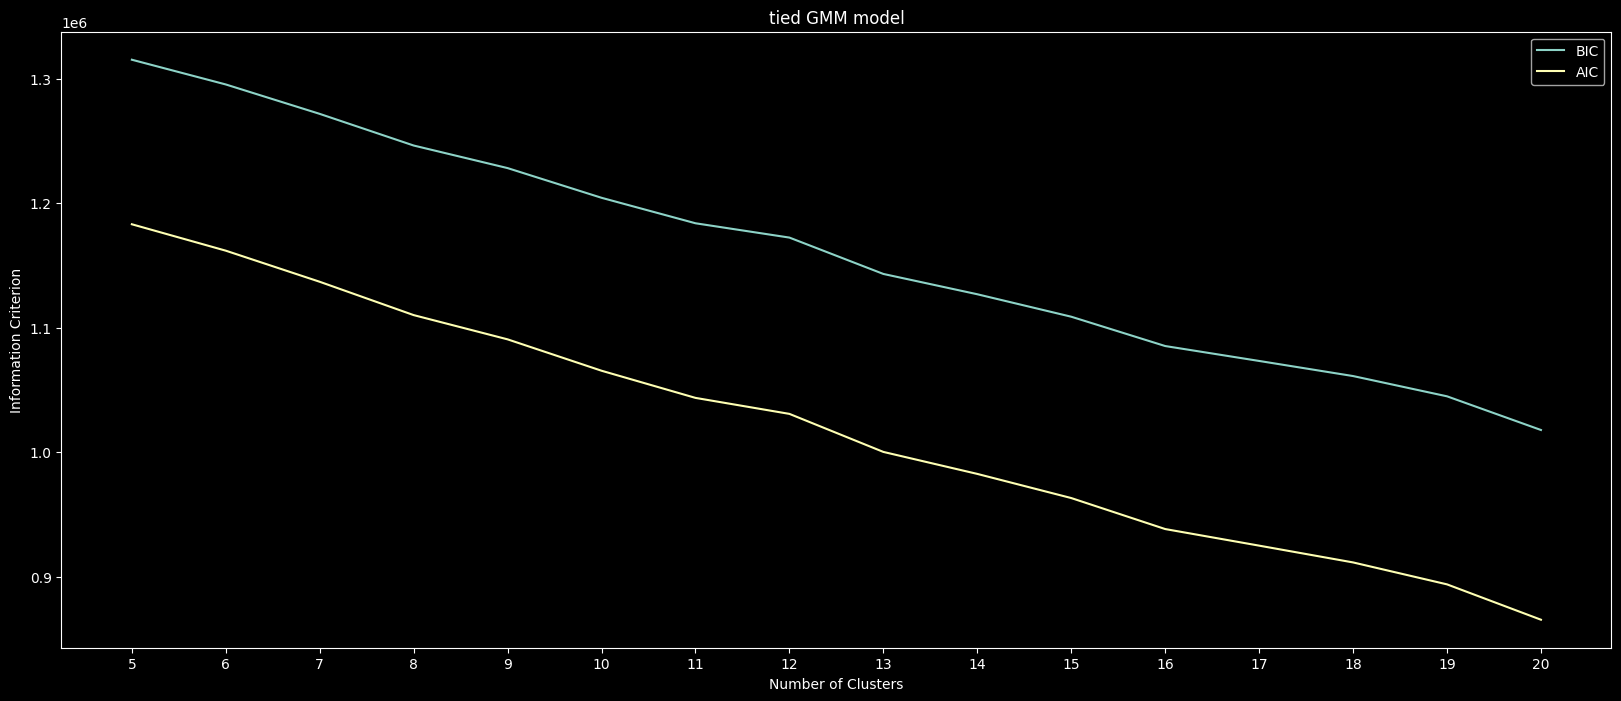

It took 380.528


<Figure size 640x480 with 0 Axes>

In [57]:
import time
start = time.time()
tied_model_gmm,tied_bic,tied_aic = get_gaussian_mixture(k_min=5,k_max=20,covariance_type='tied')
print(f"It took {round(time.time()-start,3)}")

save_dictionary('AIC_TIED',tied_aic)
save_dictionary('BIC_TIED',tied_bic)

## Q8 AND Q9
##### THE `COVARIANCE_TYPE=FULL` GAVE THE BEST RESULTS WITH NUMBER OF `CLUSTERS=20`. WE GOT THIS BY COMPARING THE BIC OF MULTIPLE COVARIANCE TYPES AND THE RANGE OF `20-35`. WE GOT THE MINIMUM BIC FOR COVARIANCE TYPE FULL AND NUMBER OF CLUSTERS=20. 

* In full all the components have their own general covariance matrix.
* In diag all the components have their own diagonal covariance matrix.
* In tied all components share  the same general covariance matrix.
* In spherical all the components have their own spherical covariance matrix.

So full one took a loot of time to train `723 seconds`, 
diag: `73s`
spherical: `94s`
tied: `380s`

In [58]:
best_gmm_model_full = GaussianMixture(n_components=20,n_init=5).fit(X_sub_gmm)

In [59]:
gmm_samples = best_gmm_model_full.sample(20)
X_sample,y_sample = gmm_samples

In [60]:
X_sample_recoverd = pca_trans.inverse_transform(X_sample)

## Q9: SAMPLE IMAGES FROM GMM

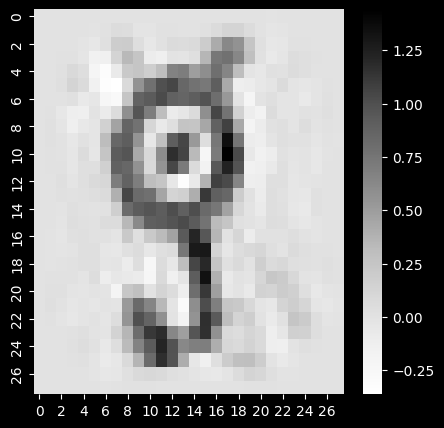

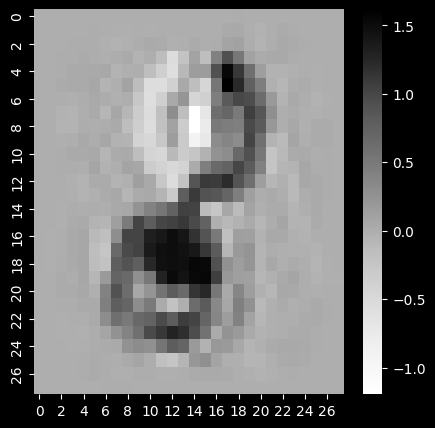

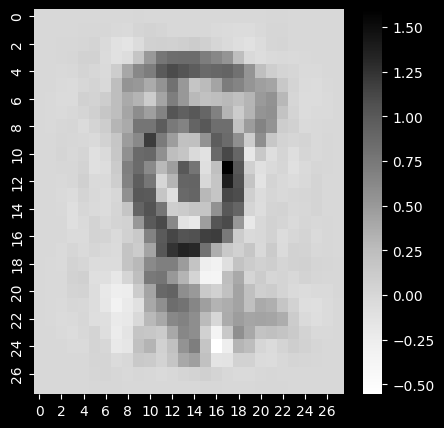

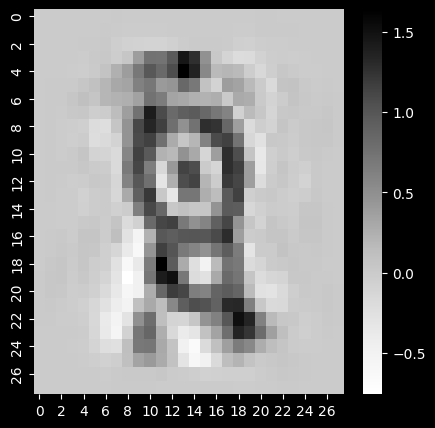

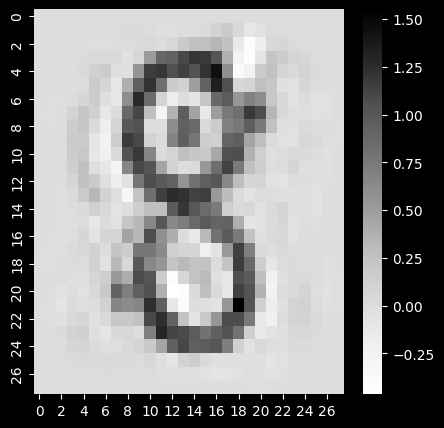

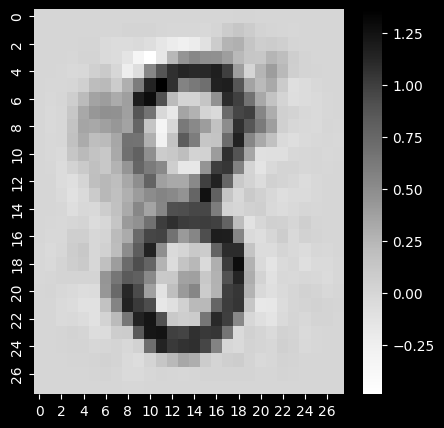

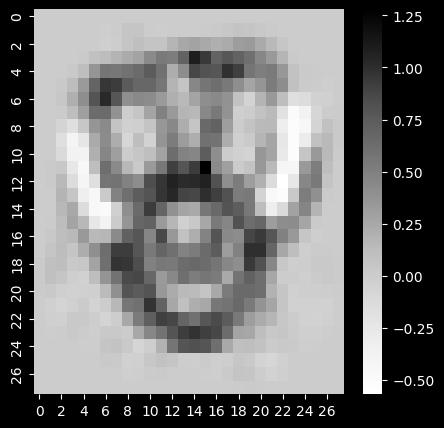

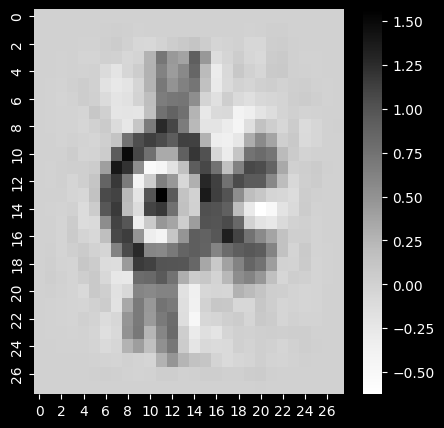

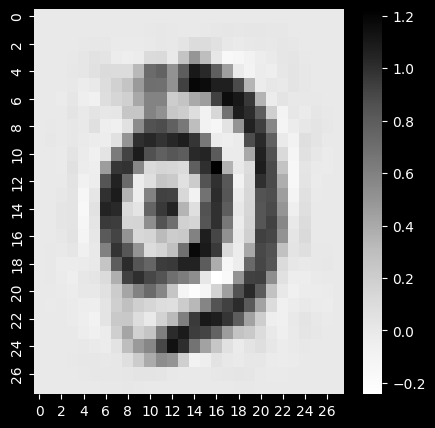

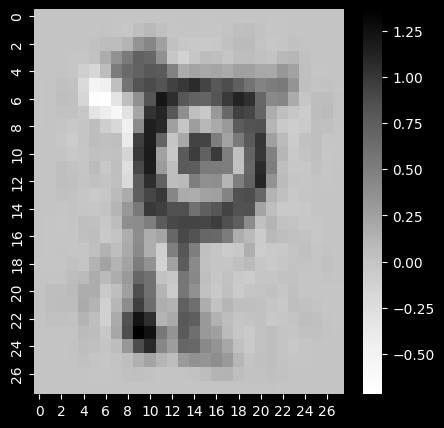

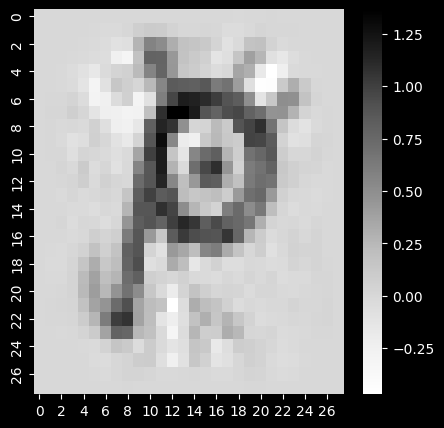

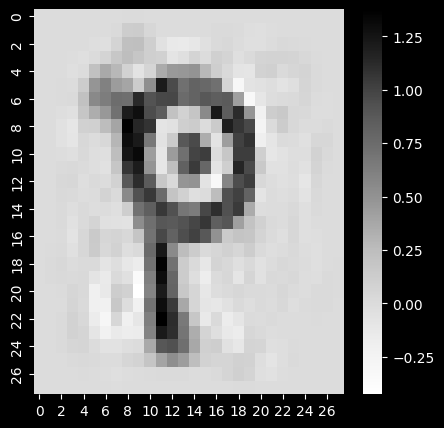

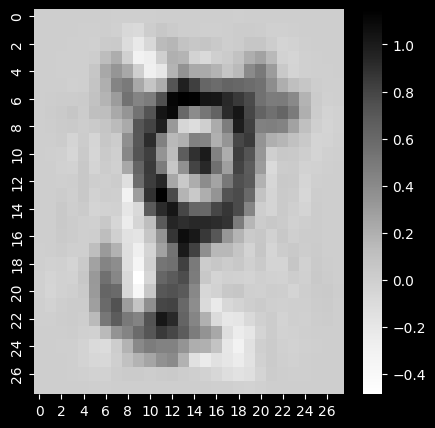

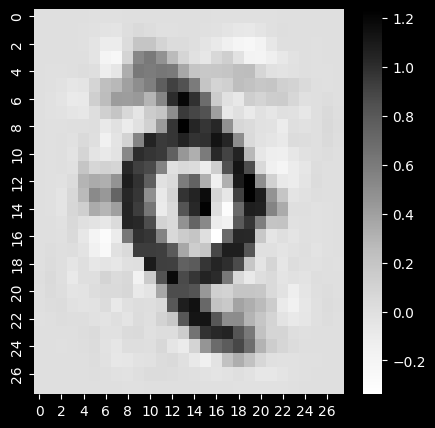

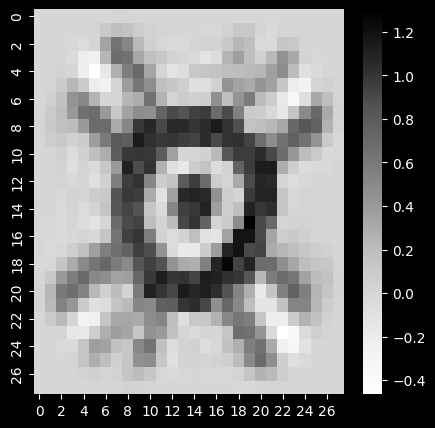

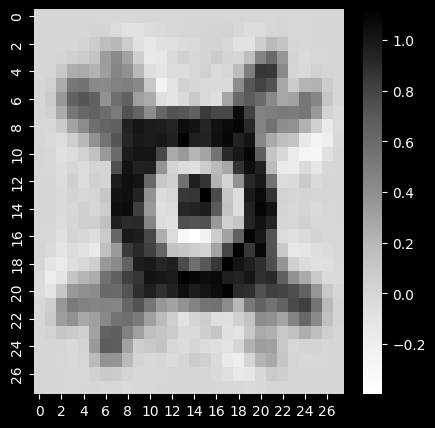

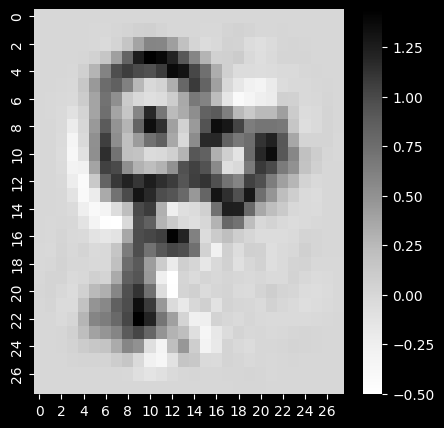

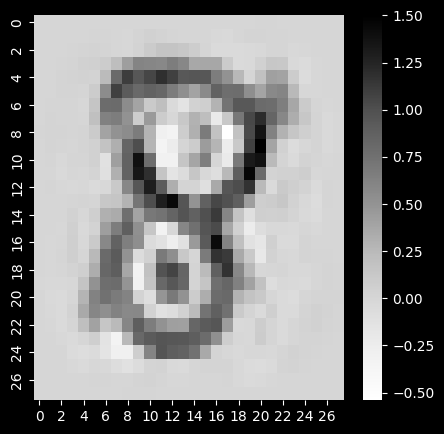

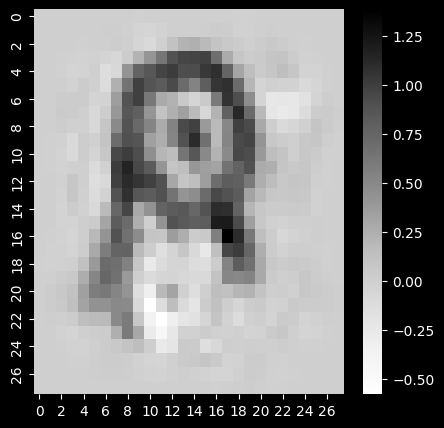

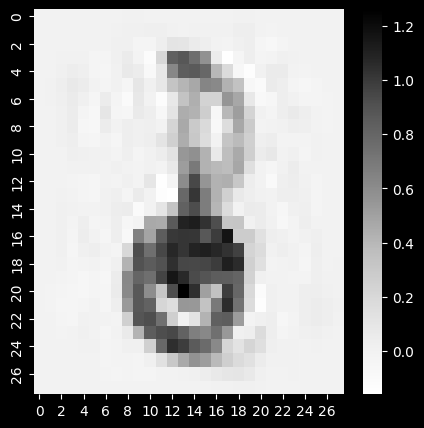

In [61]:
for idx in range(20):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(X_sample_recoverd[idx].reshape(28,28),ax=axs,cmap='Greys')
    # axs.set_title(f"Generated Image | True Label: {y_cols[y_sample[idx]]}",fontsize=10)

In [62]:
gmm_plot_df = pd.concat([X_sub_gmm,y_sub_gmm],axis=1)
gmm_plot_df = gmm_plot_df.sample(frac=0.1,random_state=42)
X_gmm_plot = gmm_plot_df[gmm_plot_df.columns[:-1]]
y_gmm_plot = gmm_plot_df['label']

In [63]:
gmm_plot_df['gmm_predicted_label'] = best_gmm_model_full.predict(X_gmm_plot)

In [64]:
num_clusters = 9

y_gmm_cols = [str(i) for i in range(num_clusters)]

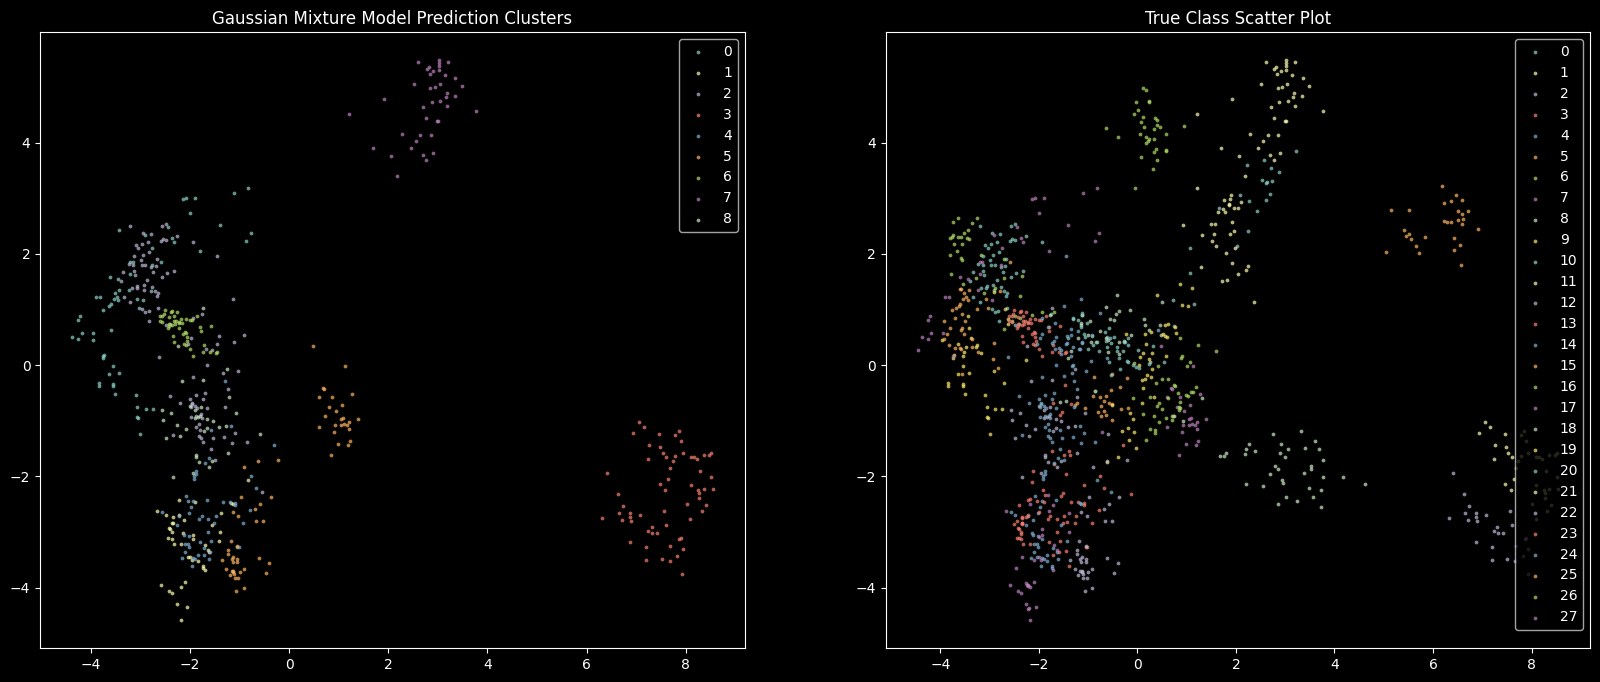

In [65]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(20,8)

for idx,y in enumerate(y_gmm_cols):
    # ax1 = plt.gca()
    sub_df = gmm_plot_df[gmm_plot_df.gmm_predicted_label==idx]
    sub_vals = sub_df.values
    ax1.scatter(sub_vals[:,0],sub_vals[:,1],label=y, marker=".", s=30, lw=0, alpha=0.7, edgecolor="k")
ax1.legend()
ax1.set_title('Gaussian Mixture Model Prediction Clusters')

for idx,y in enumerate(y_cols):
    # ax2 = plt.gca()
    sub_df = gmm_plot_df[gmm_plot_df.label==idx]
    sub_vals = sub_df.values
    ax2.scatter(sub_vals[:,0],sub_vals[:,1],label=y, marker=".", s=30, lw=0, alpha=0.7, edgecolor="k")
ax2.set_title('True Class Scatter Plot')
ax2.legend()
plt.show()

Cluster 0


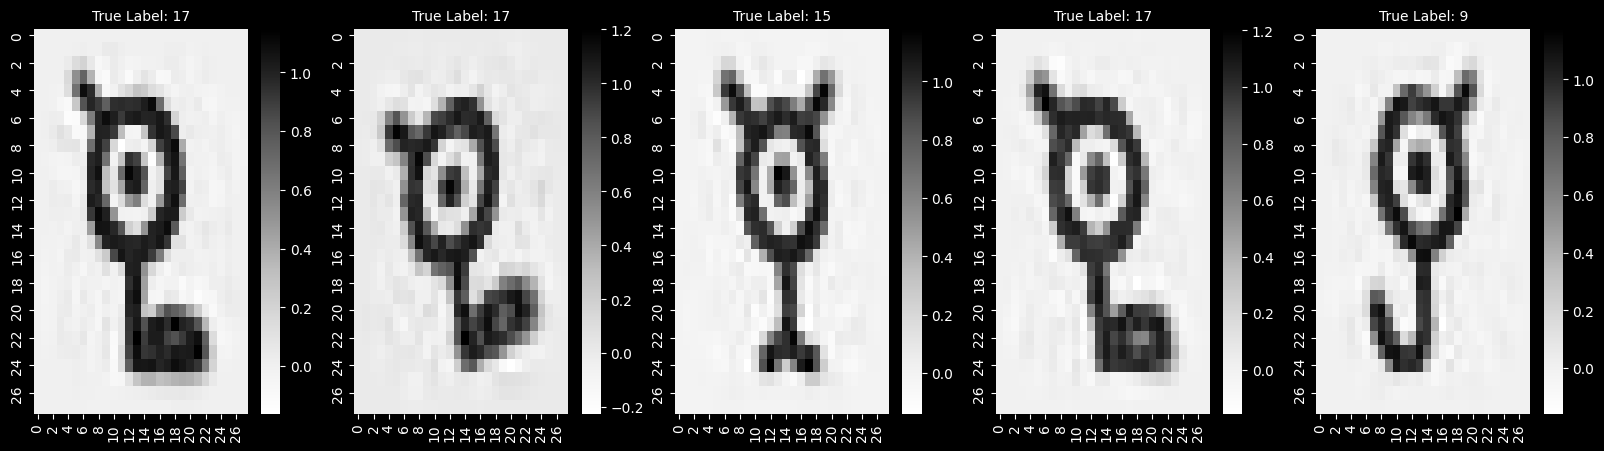

Cluster 1


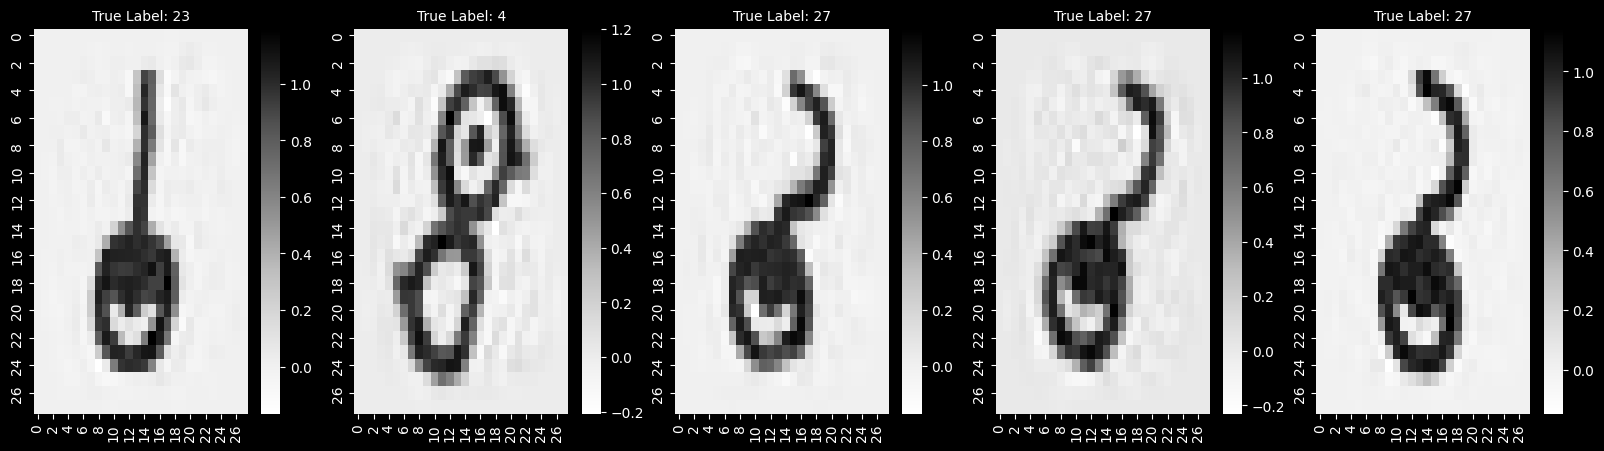

Cluster 2


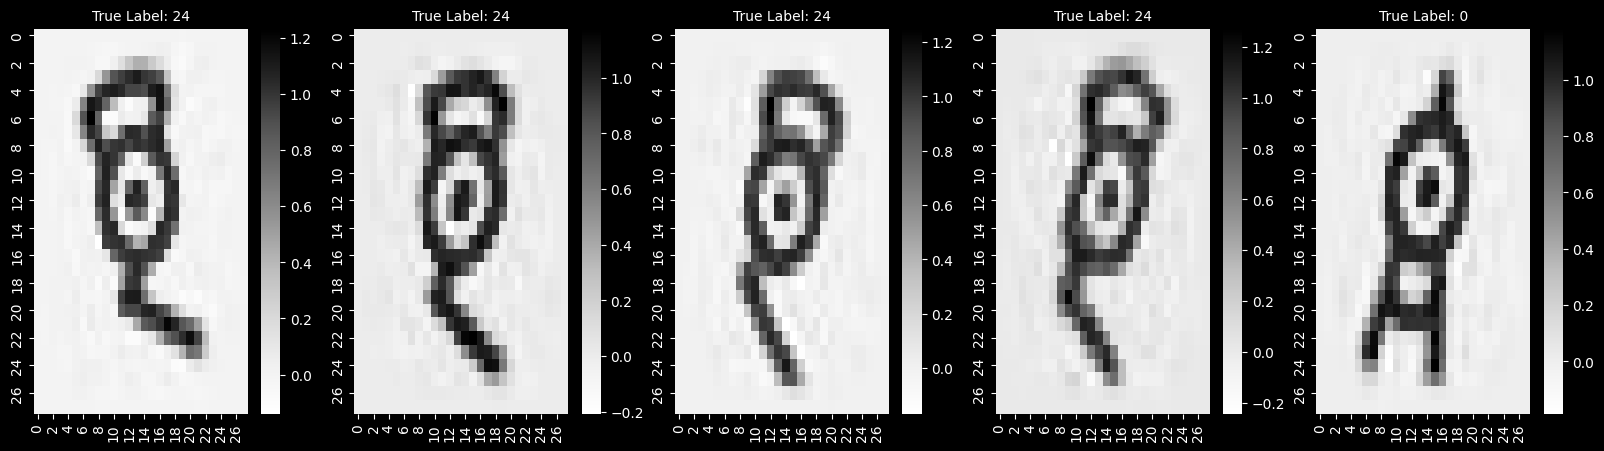

Cluster 3


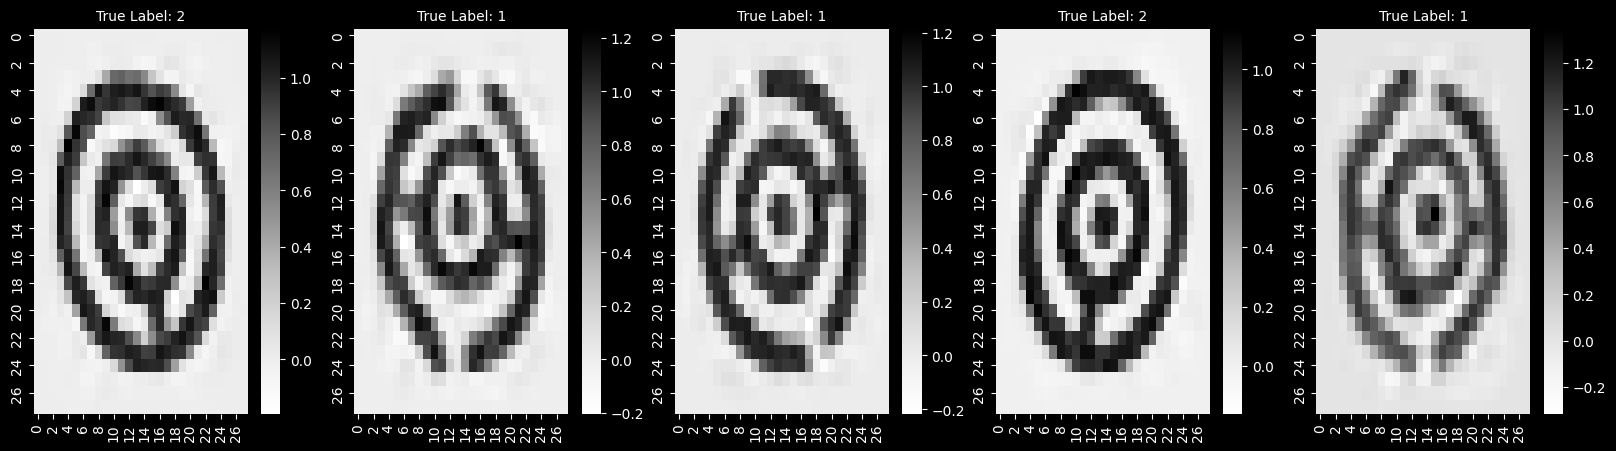

Cluster 4


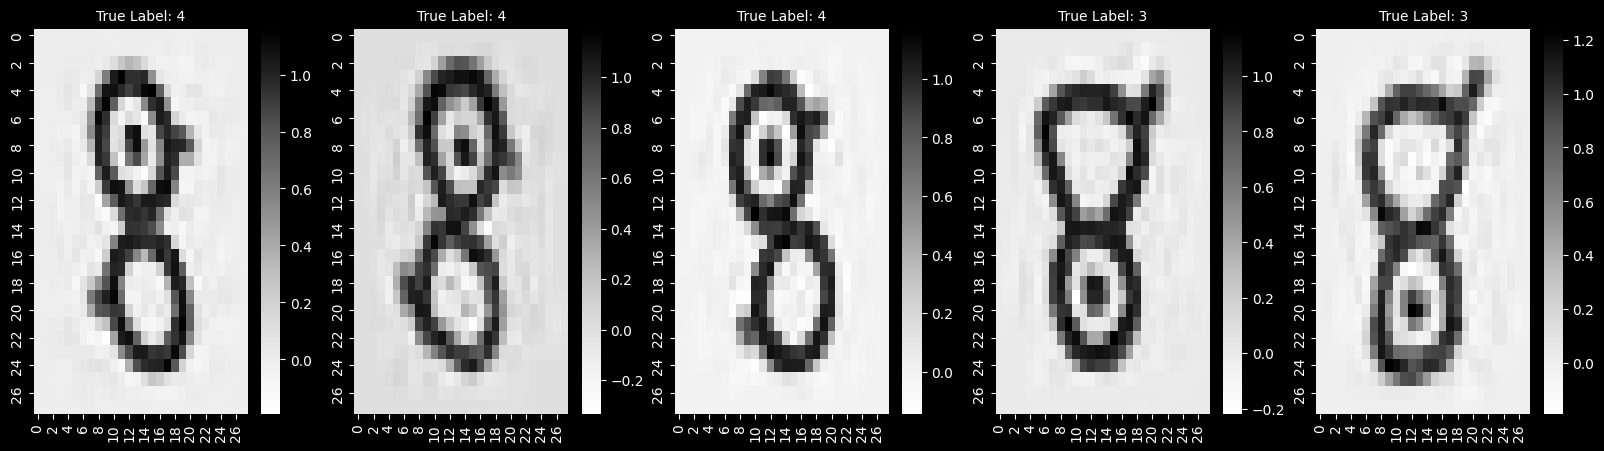

Cluster 5


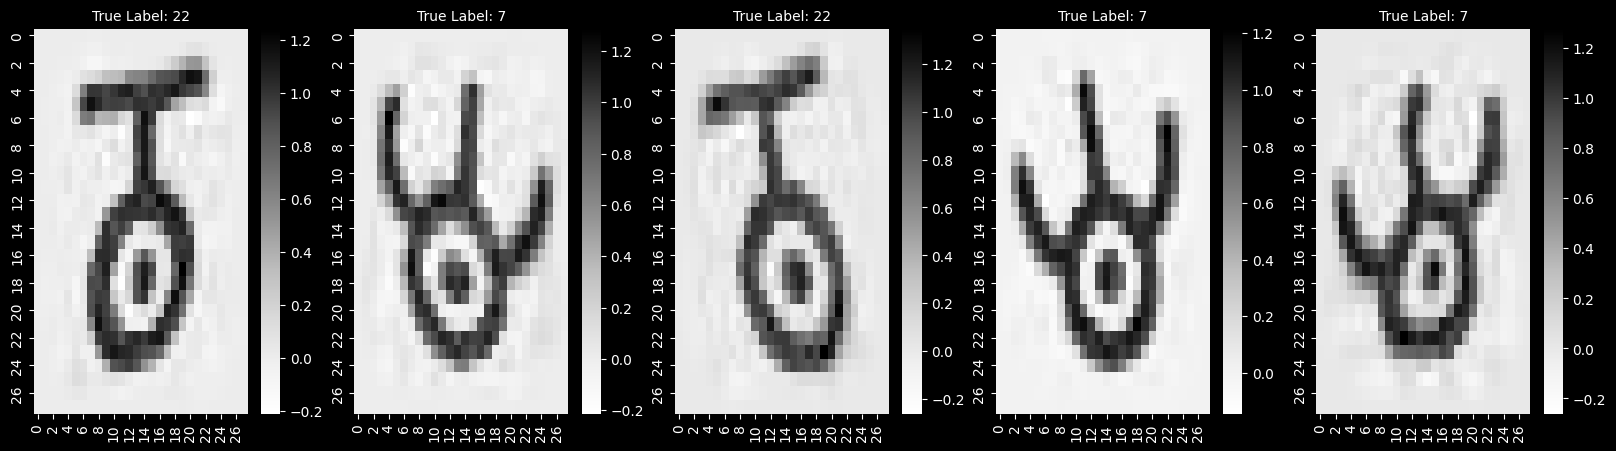

Cluster 6


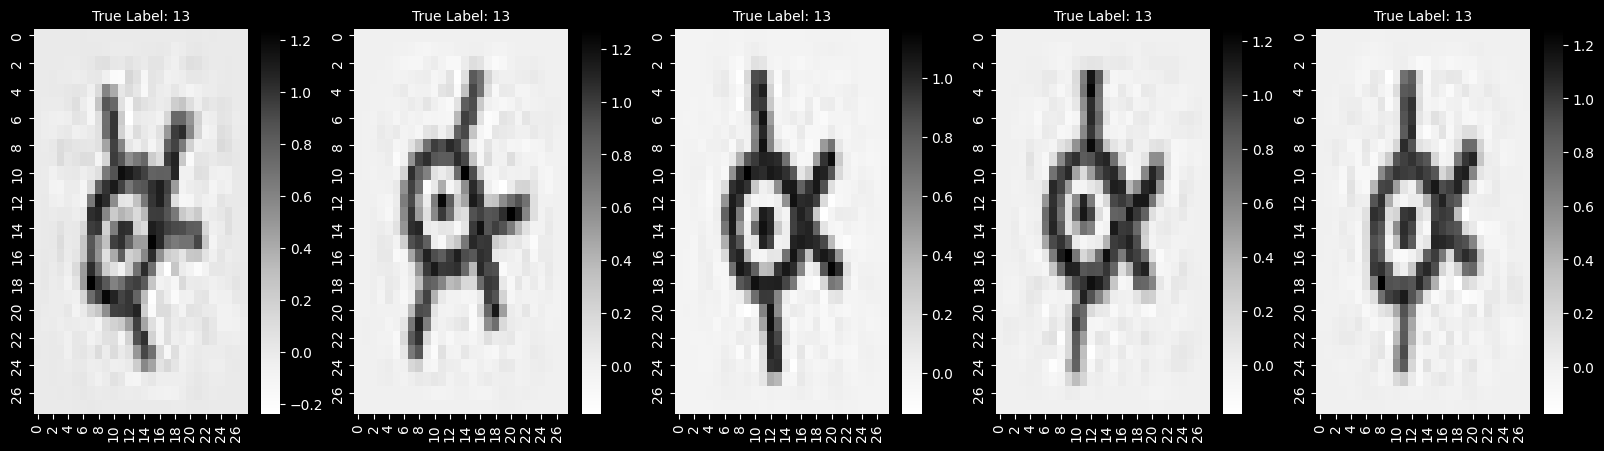

Cluster 7


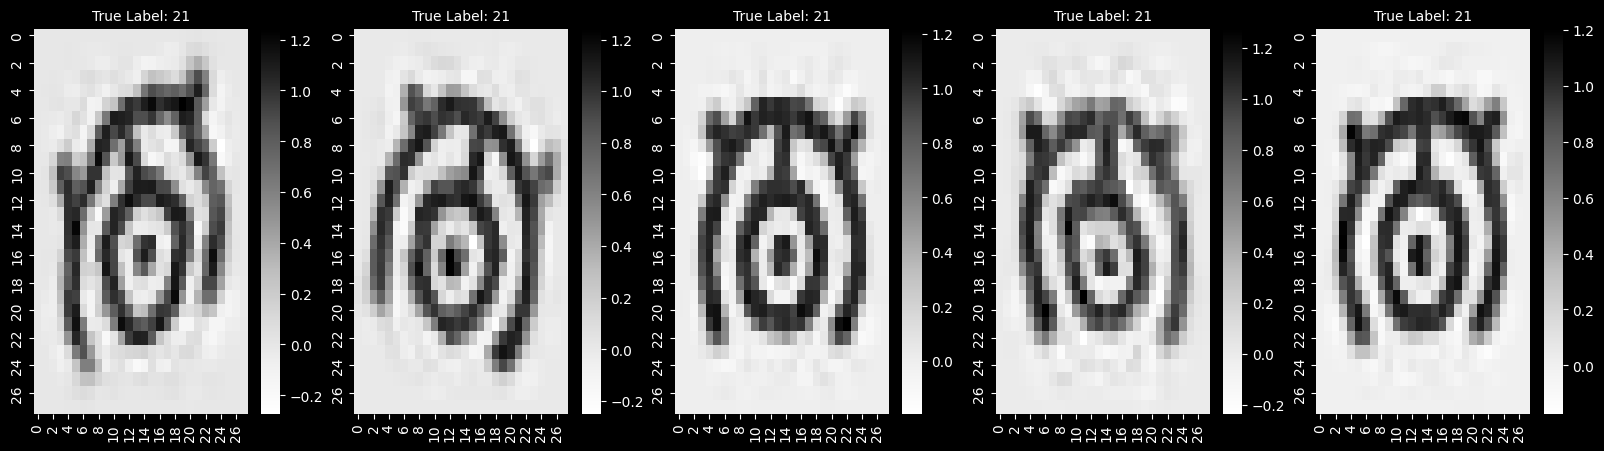

Cluster 8


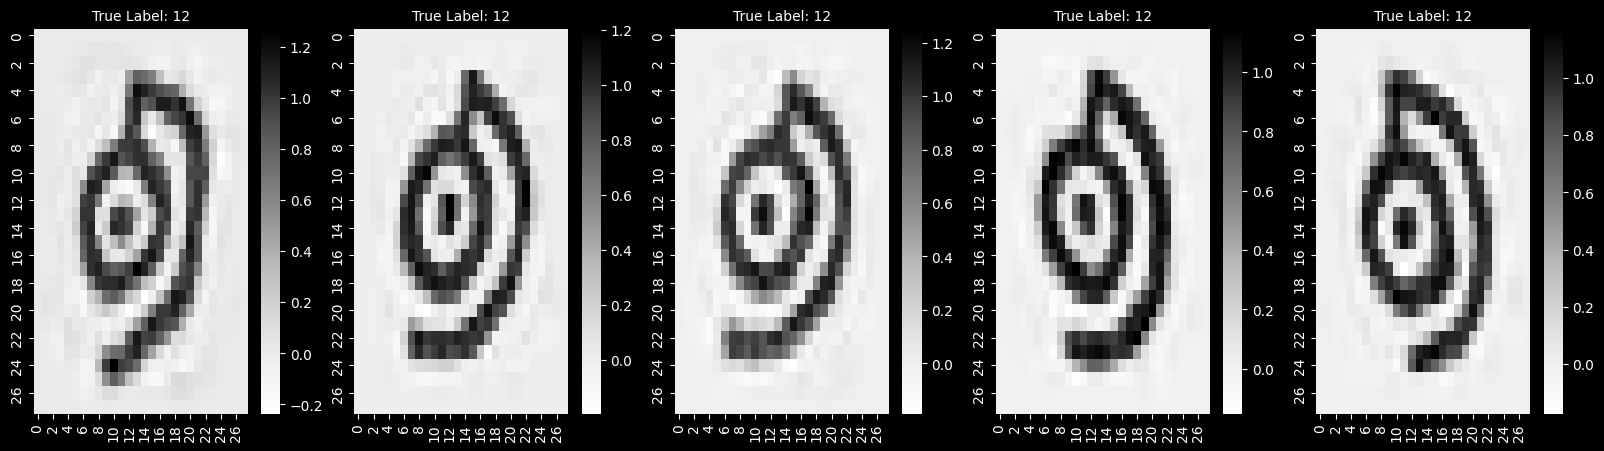

In [66]:
num_imgs = 5
for idx,y in enumerate(y_gmm_cols):
    # ax1 = plt.gca()
    sub_df = gmm_plot_df[gmm_plot_df.gmm_predicted_label==idx]
    sub_df = sub_df.sample(n=num_imgs)
    X_df = sub_df[sub_df.columns[:-2]].values
    X_df = pca_trans.inverse_transform(X_df)
    # print(X_df.shape)
    y_df = sub_df['label'].values
    fig,ax = plt.subplots(1,num_imgs,figsize=(20,5))
    print(f"Cluster {idx}")
    for i in range(num_imgs):
        sns.heatmap(X_df[i].reshape(28,28),cmap='Greys',ax=ax[i])
        ax[i].set_title(f"True Label: {y_cols[y_df[i]]}",fontsize=10)
    plt.show()

Visualizing the intra-cluster images from GMM, we can see that similar Pokemon are grouped together and it does a good job to segregate image itmes.

## NEURAL NETWORKS IMPLEMENTATION

In [2]:
import tensorflow as tf
from tensorflow import keras

In [13]:
from IPython.display import clear_output
lrs = [0.1,0.001,0.00001]
lr_dict = {}
for lr in lrs:
    model = keras.Sequential([
    keras.layers.Dense(200, activation='ReLU'),
    keras.layers.Dense(50, activation='ReLU'),
    keras.layers.Dense(28, activation='softmax')
        ])
    model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=100, validation_data=[X_val,y_val],verbose=1)
    lr_dict.update({str(lr):history})
    clear_output(wait=True)

Epoch 1/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.5987 - accuracy: 0.4330 - val_loss: 1.6701 - val_accuracy: 0.7616
Epoch 2/100
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0232 - accuracy: 0.9008 - val_loss: 0.5704 - val_accuracy: 0.9761
Epoch 3/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3632 - accuracy: 0.9873 - val_loss: 0.2276 - val_accuracy: 0.9922
Epoch 4/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1581 - accuracy: 0.9949 - val_loss: 0.1099 - val_accuracy: 0.9967
Epoch 5/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0800 - accuracy: 0.9978 - val_loss: 0.0592 - val_accuracy: 0.9982
Epoch 6/100
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0441 - accuracy: 0.9991 - val_loss: 0.0344 - val_accuracy: 0.9990
Epoch 7/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0260 - accuracy: 0.9995 - val_loss: 0.0212 - val_ac

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

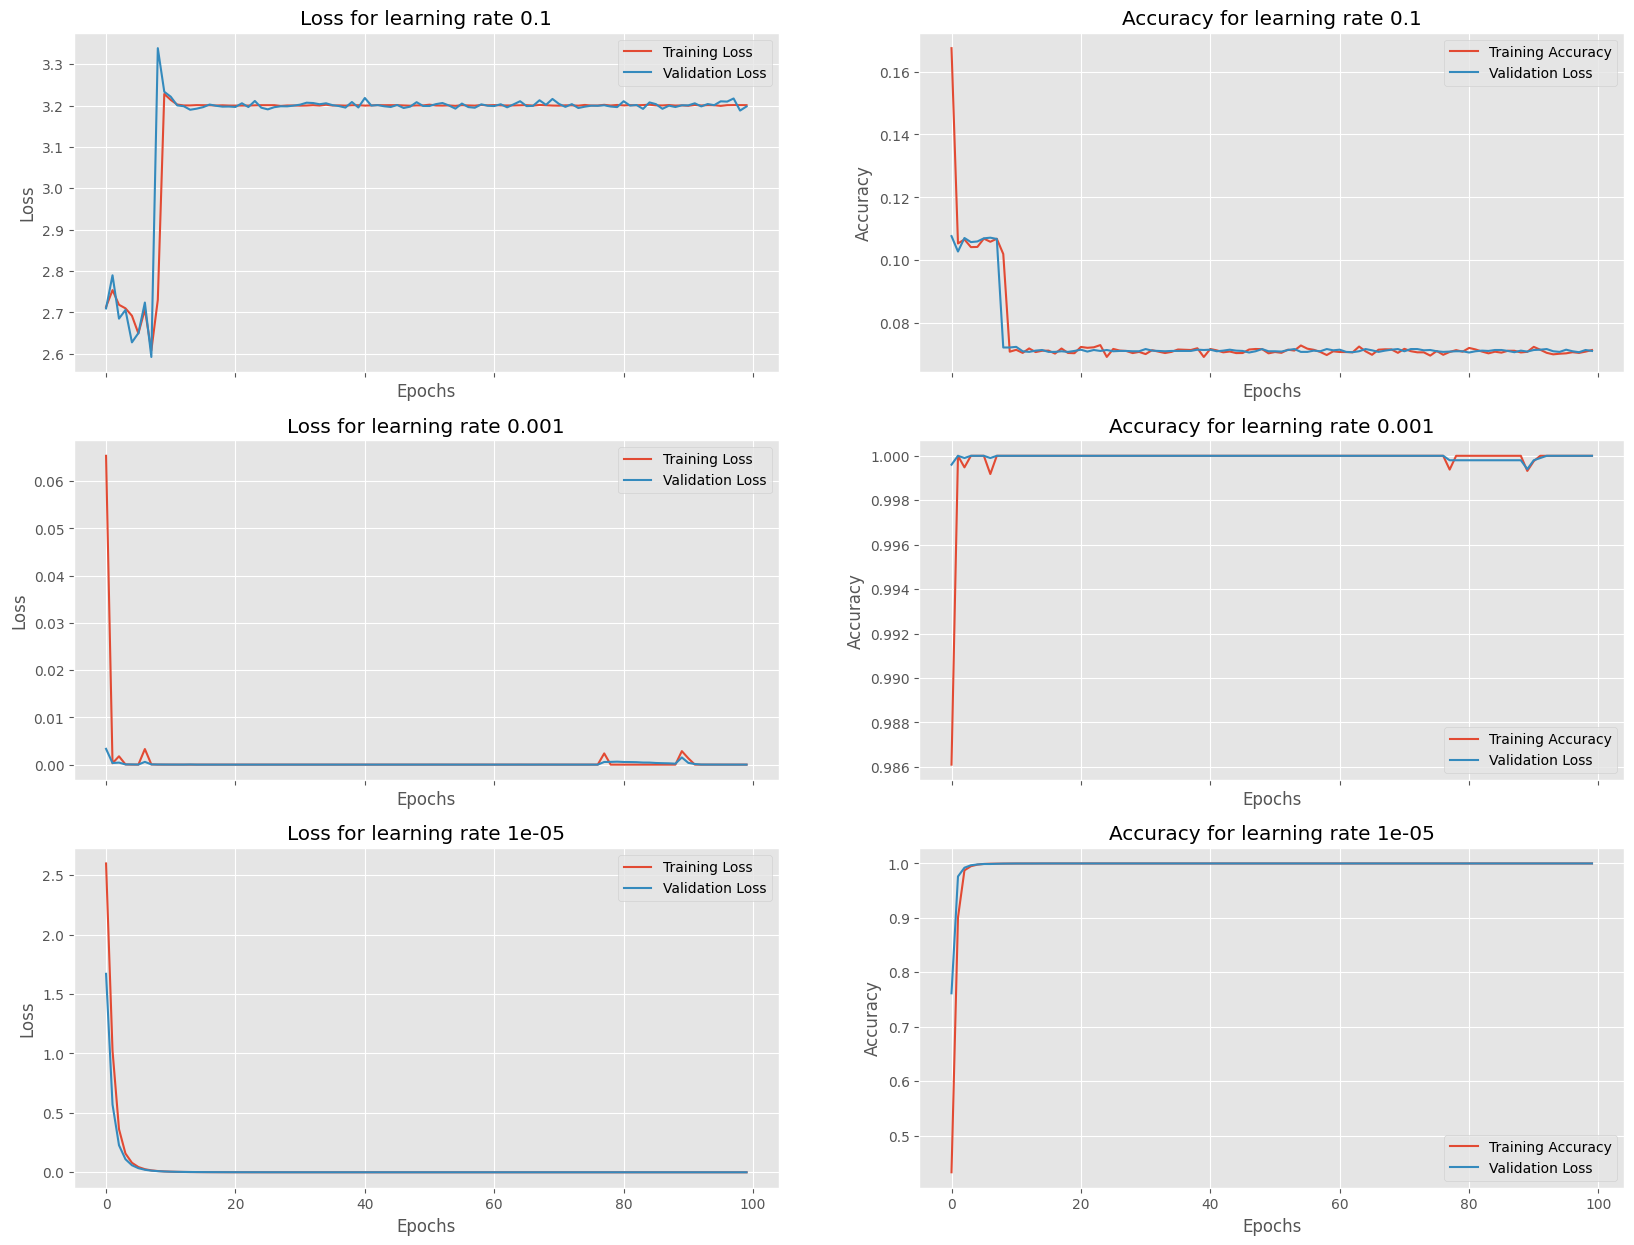

<Figure size 640x480 with 0 Axes>

In [16]:
plt.style.use('ggplot')
def plot_dictionary(lr_dict,save_name:str):
  dict_keys = [k for k in lr_dict.keys()]
  
  fig, axs = plt.subplots(3, 2,sharex=True)
  fig.set_size_inches(20,15)

  axs[0,0].plot(lr_dict[dict_keys[0]].history['loss'],label='Training Loss')
  axs[0,0].plot(lr_dict[dict_keys[0]].history['val_loss'],label='Validation Loss')
  axs[0,1].plot(lr_dict[dict_keys[0]].history['accuracy'],label='Training Accuracy')
  axs[0,1].plot(lr_dict[dict_keys[0]].history['val_accuracy'],label='Validation Loss')
  axs[0,0].set_title(f'Loss for learning rate {dict_keys[0]}')
  axs[0,1].set_title(f'Accuracy for learning rate {dict_keys[0]}')
  axs[0,0].set_xlabel('Epochs')
  axs[0,1].set_xlabel('Epochs')
  axs[0,0].set_ylabel('Loss')
  axs[0,1].set_ylabel('Accuracy')
  axs[0,0].legend()
  axs[0,1].legend()

  axs[1,0].plot(lr_dict[dict_keys[1]].history['loss'],label='Training Loss')
  axs[1,0].plot(lr_dict[dict_keys[1]].history['val_loss'],label='Validation Loss')
  axs[1,1].plot(lr_dict[dict_keys[1]].history['accuracy'],label='Training Accuracy')
  axs[1,1].plot(lr_dict[dict_keys[1]].history['val_accuracy'],label='Validation Loss')
  axs[1,0].set_title(f'Loss for learning rate {dict_keys[1]}')
  axs[1,1].set_title(f'Accuracy for learning rate {dict_keys[1]}')
  axs[1,0].set_xlabel('Epochs')
  axs[1,1].set_xlabel('Epochs')
  axs[1,0].set_ylabel('Loss')
  axs[1,1].set_ylabel('Accuracy')
  axs[1,0].legend()
  axs[1,1].legend()

  axs[2,0].plot(lr_dict[dict_keys[2]].history['loss'],label='Training Loss')
  axs[2,0].plot(lr_dict[dict_keys[2]].history['val_loss'],label='Validation Loss')
  axs[2,1].plot(lr_dict[dict_keys[2]].history['accuracy'],label='Training Accuracy')
  axs[2,1].plot(lr_dict[dict_keys[2]].history['val_accuracy'],label='Validation Loss')
  axs[2,0].set_title(f'Loss for learning rate {dict_keys[2]}')
  axs[2,1].set_title(f'Accuracy for learning rate {dict_keys[2]}')
  axs[2,0].set_xlabel('Epochs')
  axs[2,1].set_xlabel('Epochs')
  axs[2,0].set_ylabel('Loss')
  axs[2,1].set_ylabel('Accuracy')
  axs[2,0].legend()
  axs[2,1].legend()

  plt.show()
  plt.savefig(f'{save_name}.png')

plot_dictionary(lr_dict,'ReLU')

Here the training plots for higher learning rate is unstable and there are ocassional spikes in the plots. This signifies that smaller learning rate are essential for smooth learning, as you can see from learning rate of `1e-5`. We don't see any signs of overfitting or underfitting as the curves GO TOGETHER FOR RELU ACTIVATION FUNCTION

In [17]:
from IPython.display import clear_output

lrs = [0.1,0.001,0.00001]
lr_dict_linear = {}
for lr in lrs:
    model_linear = keras.Sequential([
    keras.layers.Dense(200, activation='linear'),
    keras.layers.Dense(50, activation='linear'),
    keras.layers.Dense(28, activation='softmax')
        ])
    model_linear.compile(loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics=['accuracy'])
    history = model_linear.fit(X_train, y_train, epochs=100, validation_data=[X_val,y_val],verbose=1)
    lr_dict_linear.update({str(lr):history})
    clear_output(wait=True)

Epoch 1/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.0454 - accuracy: 0.5693 - val_loss: 0.9931 - val_accuracy: 0.9119
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5839 - accuracy: 0.9597 - val_loss: 0.3293 - val_accuracy: 0.9854
Epoch 3/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2169 - accuracy: 0.9913 - val_loss: 0.1402 - val_accuracy: 0.9947
Epoch 4/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0980 - accuracy: 0.9969 - val_loss: 0.0679 - val_accuracy: 0.9982
Epoch 5/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0492 - accuracy: 0.9986 - val_loss: 0.0360 - val_accuracy: 0.9988
Epoch 6/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0267 - accuracy: 0.9994 - val_loss: 0.0206 - val_accuracy: 0.9993
Epoch 7/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0154 - accuracy: 0.9996 - val_loss: 0.0125 - val_ac

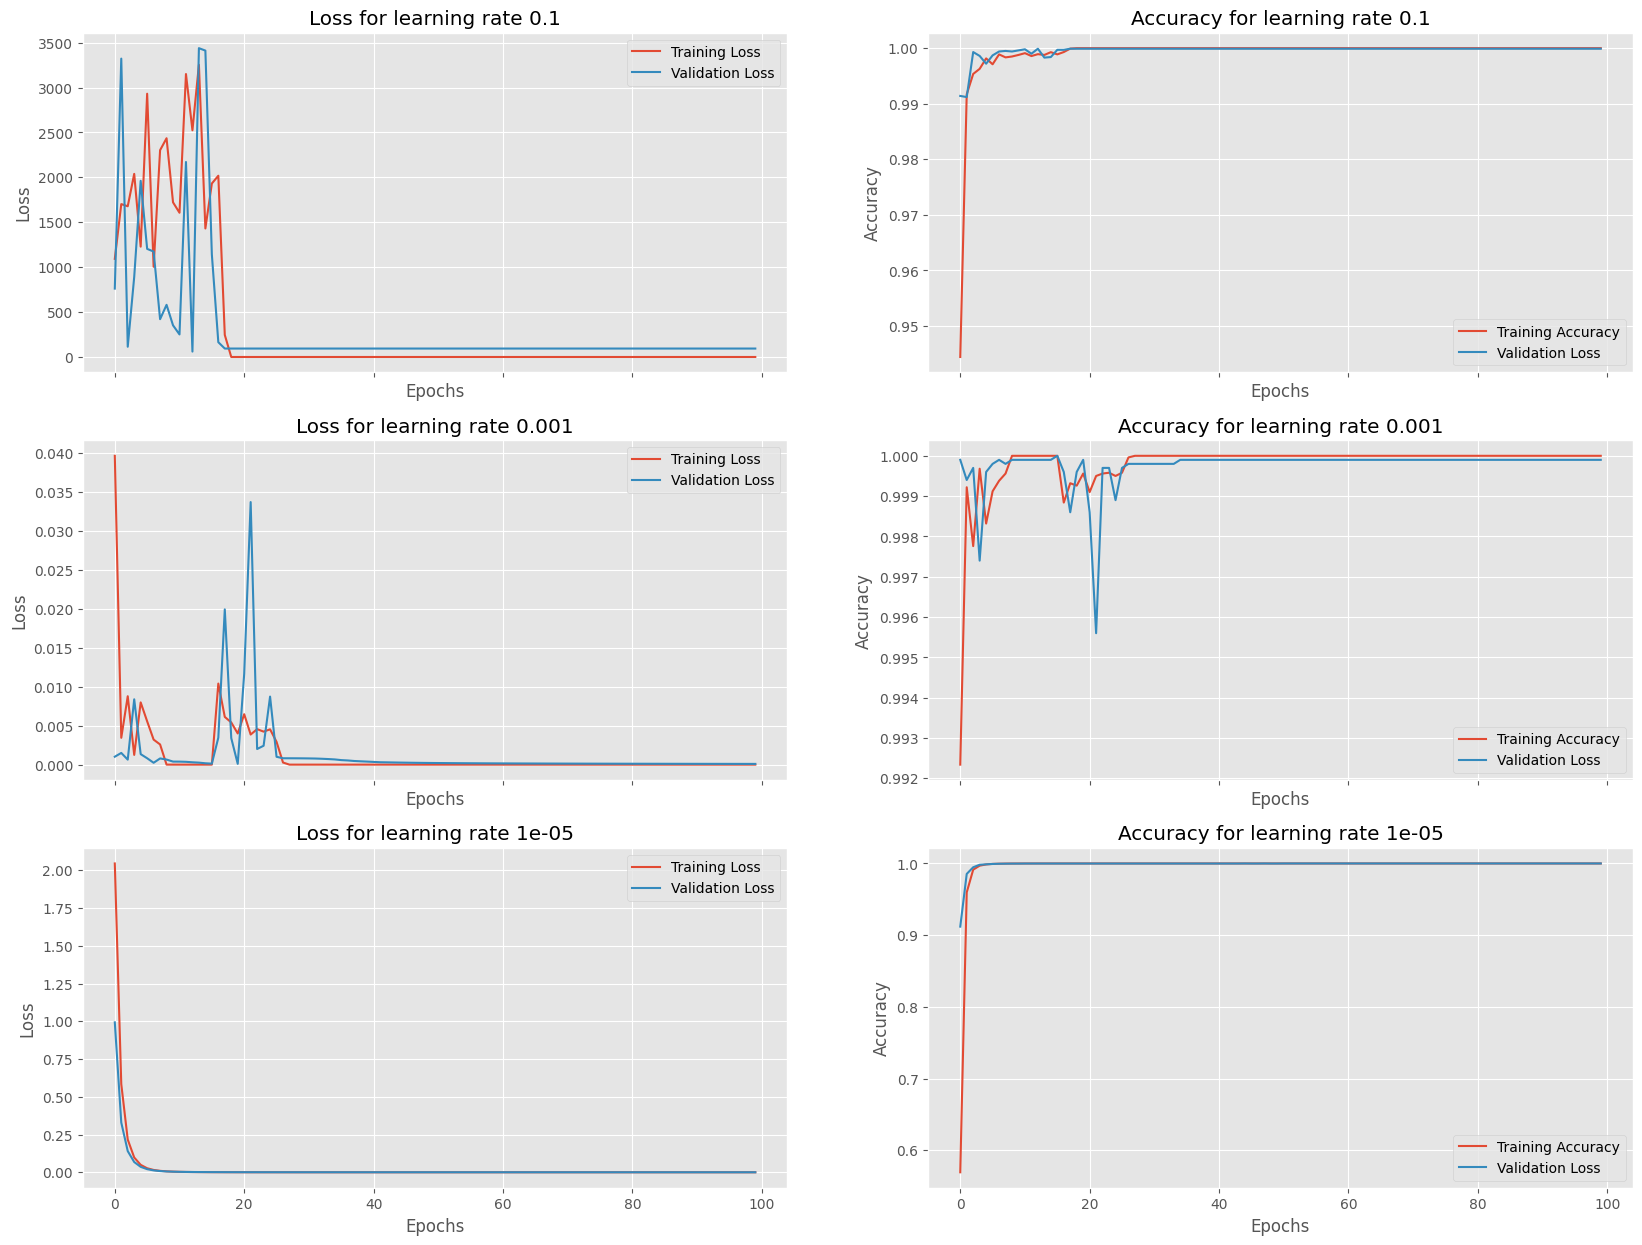

<Figure size 640x480 with 0 Axes>

In [18]:
plot_dictionary(lr_dict_linear,'Linear')

Here the training plots for higher learning rate is unstable and there are ocassional spikes in the plots. This signifies that smaller learning rate are essential for smooth learning, as you can see from learning rate of `1e-5`. We don't see any signs of overfitting or underfitting as the curves GO TOGETHER FOR LINEAR ACTIVATION FUNCTION

## YOU CAN SEE THAT THE MODEL CONVERGES AFTER 40 EPOCHS, HENCE WHILE BUILDING THE MODEL AGAIN WITHT HE BEST LEARNING RATE, WE ARE TRAINING FOR 40 EPOCHS ONLY.

In [25]:

model_relu = keras.Sequential([
    keras.layers.Dense(200, activation='ReLU'),
    keras.layers.Dense(50, activation='ReLU'),
    keras.layers.Dense(28, activation='softmax')
        ])
model_relu.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['accuracy'])
history = model_relu.fit(X_train, y_train, epochs=40, validation_data=[X_val,y_val],verbose=0)

In [20]:
model_relu.evaluate(X_test,  y_test, verbose=2)

313/313 - 1s - loss: 9.7583e-06 - accuracy: 1.0000 - 581ms/epoch - 2ms/step


[9.758261512615718e-06, 1.0]

In [26]:
model_linear = keras.Sequential([
    keras.layers.Dense(200, activation='linear'),
    keras.layers.Dense(50, activation='linear'),
    keras.layers.Dense(28, activation='softmax')
        ])
model_linear.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['accuracy'])
history = model_linear.fit(X_train, y_train, epochs=40, validation_data=[X_val,y_val],verbose=1)

Epoch 1/40
1563/1563 [==============================] - 7s 3ms/step - loss: 1.9427 - accuracy: 0.6192 - val_loss: 0.9334 - val_accuracy: 0.9240
Epoch 2/40
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5525 - accuracy: 0.9626 - val_loss: 0.3180 - val_accuracy: 0.9831
Epoch 3/40
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2126 - accuracy: 0.9879 - val_loss: 0.1388 - val_accuracy: 0.9932
Epoch 4/40
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0985 - accuracy: 0.9959 - val_loss: 0.0684 - val_accuracy: 0.9971
Epoch 5/40
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0502 - accuracy: 0.9985 - val_loss: 0.0364 - val_accuracy: 0.9988
Epoch 6/40
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0275 - accuracy: 0.9993 - val_loss: 0.0208 - val_accuracy: 0.9993
Epoch 7/40
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0160 - accuracy: 0.9996 - val_loss: 0.0127 - val_accuracy:

In [22]:
model_linear.evaluate(X_test,  y_test, verbose=2)

313/313 - 1s - loss: 7.9788e-06 - accuracy: 1.0000 - 782ms/epoch - 2ms/step


[7.97884877101751e-06, 1.0]

| Model           |  Accuracy Score  | Loss Score | 
| ----------------|---------------------|----------------------|
| ReLU Model     |    1.0              | 9.7e-06        |
| Linear Model  | 1.0                | 7.975e-06                 |

Here the marginal difference between both of these model is very small to conclude which one is better. It will certainly depend on other hyperparameters to determine what is the best model

## NUMBER OF PARAMETERS OF THE MODEL

In [23]:
print(model_relu.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 200)               157000    
                                                                 
 dense_34 (Dense)            (None, 50)                10050     
                                                                 
 dense_35 (Dense)            (None, 28)                1428      
                                                                 
Total params: 168,478
Trainable params: 168,478
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
num_biases = model_relu.layers[0].get_weights()[1].shape[0] + model_relu.layers[1].get_weights()[1].shape[0] + model_relu.layers[2].get_weights()[1].shape[0]

print("Number of bias parameters = ",num_biases)

Number of bias parameters =  278


The model has total 168,478 parameters and 278 bias parameters